In [76]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import statistics as stat
from termcolor import colored
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]
cmap = plt.get_cmap('jet_r')
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 18}
plt.rc('font', **font)

In [77]:
def show_profiling_overhead(file, aggregate=False):
    with open(file, 'rb') as f:
        profiling_data = pickle.load(f)
    profiled_rt_data = profiling_data[0]
    # print(profiled_rt_data)
    
    for i, profiled_rt in enumerate(profiled_rt_data):
        
        if aggregate:
            profiled_rt_data_aggregate = []
            for j in range(0, len(profiled_rt), aggregate):
                mean = stat.mean(profiled_rt[j:j+aggregate])
                for _ in range(0, aggregate):
                    profiled_rt_data_aggregate.append(mean)
            profiled_rt = profiled_rt_data_aggregate
        
        x_val = np.arange(len(profiled_rt))
        plt.xlabel('Req')
        plt.ylabel('Response time [s]')
        # plt.title('Profiled Response time')
        plt.plot(x_val, profiled_rt, label="Data " + str(i+1))

        avg_rt = stat.mean(profiled_rt)
        min_rt = min(profiled_rt)
        max_rt = max(profiled_rt)
        dev_rt = stat.variance(profiled_rt)
        print("Min: {:.4f}, Max: {:.4f}, Avg: {:.4f}, Std: {:.4f}".format(min_rt, max_rt, avg_rt, dev_rt))
    
    plt.legend(loc=1)
    plt.grid(True, linewidth=0.3, linestyle='-')
    plt.show()


def show_benchmark_overhead(files, aggregate=False):
    for i, file in enumerate(files):
        with open(file, 'rb') as f:
            benchmark_data = pickle.load(f)

        sampling_time = 2
        benchmark_rt = list(filter(lambda rt: rt is not None, benchmark_data[0]))
        benchmark_rt_process = list(filter(lambda rt: rt is not None, benchmark_data[1]))

        avg_rt = stat.mean(benchmark_rt)
        min_rt = min(benchmark_rt)
        max_rt = max(benchmark_rt)
        dev_rt = stat.variance(benchmark_rt)
        print("Min: {:.4f}, Max: {:.4f}, Avg: {:.4f}, Std: {:.4f}".format(min_rt, max_rt, avg_rt, dev_rt))
        avg_rt = stat.mean(benchmark_rt_process)
        min_rt = min(benchmark_rt_process)
        max_rt = max(benchmark_rt_process)
        dev_rt = stat.variance(benchmark_rt)
        print("PROCESS: Min: {:.4f}, Max: {:.4f}, Avg: {:.4f}, Std: {:.4f}\n".format(min_rt, max_rt, avg_rt, dev_rt))

        if aggregate:
            benchmark_rt_aggregate = []
            for j in range(0, len(benchmark_rt), aggregate):
                mean = stat.mean(benchmark_rt[j:j+aggregate])
                for _ in range(0, aggregate):
                    benchmark_rt_aggregate.append(mean)
            benchmark_rt = benchmark_rt_aggregate
        
        # plot
        x_val = np.arange(len(benchmark_rt))
        plt.xlabel('Time [s]')
        plt.ylabel('Response time [s]')
        # plt.title('Response Time')
        plt.plot(x_val*sampling_time, benchmark_rt, label="Data " + str(i+1))
        # plt.plot(x_val*sampling_time, [stat.mean(benchmark_rt)]*len(x_val), label="avg RT")
    plt.legend(loc=1)
    plt.grid(True, linewidth=0.3, linestyle='-')
    plt.show()

In [78]:
def show_values(file, sampling_time, title=False, verbose=False, aggregate=False, sla=1.1):
    with open(file, 'rb') as f:
        benchmark_data = pickle.load(f)

    benchmark_rt = list(filter(lambda rt: rt is not None, benchmark_data[0]))
    benchmark_rt_process = list(filter(lambda rt: rt is not None, benchmark_data[1]))
    benchmark_req = benchmark_data[2]
    benchmark_sent = benchmark_data[3]
    for i,_ in enumerate(benchmark_sent):
        for j,_ in enumerate(benchmark_sent[i]):
            benchmark_sent[i][j] = benchmark_sent[i][j] / sampling_time
    benchmark_model_sla = list(map(lambda v: v*sla, benchmark_data[4]))
    benchmark_containers = benchmark_data[5]

    bc_json = [response.json() for response in benchmark_containers]
    benchmark_container_quota = {}
    for container in bc_json[0]:
        benchmark_container_quota[container["container_id"]] = []
    for bc in bc_json:
        for sampled_c in bc:
            benchmark_container_quota[sampled_c["container_id"]].append(sampled_c["quota"]/100000)
            
            
    # aggregate values
    if aggregate:
        benchmark_aggregate = []
        for i in range(0, len(benchmark_rt), aggregate):
            mean = stat.mean(benchmark_rt[i:i+aggregate])
            for _ in range(0, aggregate):
                benchmark_aggregate.append(mean)
        benchmark_rt = benchmark_aggregate
        
    if aggregate:
        for container in benchmark_container_quota:
            benchmark_aggregate = []
            for i in range(0, len(benchmark_container_quota[container]), aggregate):
                mean = stat.mean(benchmark_container_quota[container][i:i+aggregate])
                for _ in range(0, aggregate):
                    benchmark_aggregate.append(mean)            
            benchmark_container_quota[container] = benchmark_aggregate

    if verbose:
        print("avgs rt: ", benchmark_rt)
        print("avg rt: ", stat.mean(benchmark_rt))
        print("req: ", benchmark_req)
        print("req sent: ", benchmark_sent)
        print("model_sla: ", benchmark_model_sla)
        # print("containers: ", benchmark_containers)
        print("containers_quota: ", benchmark_container_quota)
        
    # plot
    x_val = np.arange(len(benchmark_rt))
    while len(benchmark_model_sla) < len(x_val):
        benchmark_model_sla.append(0)
    # slas = set(benchmark_model_sla)
    plt.xlabel('Time [s]')
    plt.ylabel('Response time [s]')
    if title:
        plt.title('Response Time')
    
    plt.plot(x_val*sampling_time, benchmark_model_sla[:len(benchmark_rt)], ':', label="Model SLA", linewidth=3)
    plt.plot(x_val*sampling_time, benchmark_rt, label="Response Time", linewidth=3)
    # plt.plot(x_val*sampling_time, [stat.mean(benchmark_rt)]*len(benchmark_rt), '--', label="Avg RT")
    plt.legend(loc=1)
    plt.grid(True, linewidth=0.3, linestyle='-')
    plt.show()

    x_val = np.arange(len(benchmark_req))
    while len(benchmark_model_sla) < len(x_val):
        benchmark_model_sla.append(0)
    plt.xlabel('time [s]')
    plt.ylabel('# requests (completed + created)')
    if title:
        plt.title('# requests')
    plt.plot(x_val*sampling_time, benchmark_req, linewidth=3)
    plt.grid(True, linewidth=0.3, linestyle='-')
    plt.show()

    plt.xlabel('Time [s]')
    plt.ylabel('Load [r/s]')
    if title:
        plt.title('Workload')
    lines = plt.plot(x_val*sampling_time, benchmark_sent, linewidth=3)
    labels = []
    for l, _ in enumerate(benchmark_sent[0]):
        labels.append("load " + str(l+1))
    plt.legend(iter(lines), labels, loc=1)
    plt.grid(True, linewidth=0.3, linestyle='-')
    plt.show()

    plt.xlabel('Time [s]')
    plt.ylabel('SLA [s]')
    if title:
        plt.title('Model SLA')
    plt.plot(x_val*sampling_time, benchmark_model_sla[:len(x_val)], linewidth=3)
    plt.grid(True, linewidth=0.3, linestyle='-')
    plt.show()

    for container in benchmark_container_quota:
        plt.plot(x_val*sampling_time, benchmark_container_quota[container][:len(x_val)], label="Allocated Cores", linewidth=3) # label="container[:12]")
    plt.legend(loc=1)
    plt.xlabel('Time [s]')
    plt.ylabel('# cores')
    if title:
        plt.title('Allocated Cores')
    plt.grid(True, linewidth=0.3, linestyle='-')
    plt.show()
    
    # plot cores and sla
    x_val = np.arange(len(benchmark_model_sla))
    while len(benchmark_model_sla) < len(x_val):
        benchmark_model_sla.append(0)
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.grid(True, linewidth=0.3, linestyle='-')
    ax1.set_xlabel('Time [s]')
    ax1.set_ylabel('SLA [s]', color=color)
    lines = ax1.plot(x_val*sampling_time, benchmark_model_sla[:len(x_val)], ':', color=color, label="Model SLA", linewidth=3)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('# cores', color=color)
    for container in benchmark_container_quota:
        lines += ax2.plot(x_val*sampling_time, benchmark_container_quota[container][:len(x_val)], label="Allocated Cores", linewidth=3) # label="container[:12]")
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    if title:
        plt.title('Allocated Cores and Model SLA')
    labels = [l.get_label() for l in lines]
    plt.legend(iter(lines), labels, loc=1)
    plt.show()
    
    # plot cores and load
    x_val = np.arange(len(benchmark_sent))
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.grid(True, linewidth=0.3, linestyle='-')

    ax1.set_xlabel('Time [s]')
    ax1.set_ylabel('Load [r/s]', color=color)
    
    labels = []
    lines = ax1.plot(x_val*sampling_time, benchmark_sent, '--', linewidth=3)
    for l, _ in enumerate(benchmark_sent[0]):
        labels.append("Load " + str(l+1))
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:green'
    ax2.set_ylabel('# cores', color=color)
    for container in benchmark_container_quota:
        lines += ax2.plot(x_val*sampling_time, benchmark_container_quota[container][:len(x_val)], color=color, linewidth=3) # label="container[:12]")
        labels.append("Allocated Cores")
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    if title:
        plt.title('Workload and Model SLA')
    plt.legend(iter(lines), labels, loc=1)
    plt.show()

In [79]:
def plt_rt(model_id, file, sampling_time, color, verbose=False, aggregate=None):
    with open(file, 'rb') as f:
        benchmark_data = pickle.load(f)
    
    benchmark_rt = list(filter(lambda rt: rt is not None, benchmark_data[0]))
    
    # aggregate values
    if aggregate:
        benchmark_aggregate = []
        for i in range(0, len(benchmark_rt), aggregate):
            mean = stat.mean(benchmark_rt[i:i+aggregate])
            for _ in range(0, aggregate):
                benchmark_aggregate.append(mean)
        benchmark_rt = benchmark_aggregate
    
    benchmark_sent = benchmark_data[3]
    benchmark_model_sla = list(map(lambda v: v*1.1, benchmark_data[4]))
    
    if verbose:
        print("avgs rt: ", benchmark_rt)
        print("model_sla: ", benchmark_model_sla)
    
    # plot
    x_val = np.arange(len(benchmark_rt))
    slas = set(benchmark_model_sla)
    plt.xlabel('Time [s]')
    plt.ylabel('Response time [s]')
    # plt.title('Response Time')
    for i, sla in enumerate(slas):
        plt.plot(x_val*sampling_time, [sla]*len(x_val), ':', c=color, label="SLA " + str(model_id))
    plt.plot(x_val*sampling_time, benchmark_rt, c=color, label="RT " + str(model_id))
    # plt.plot(x_val*sampling_time, [stat.mean(benchmark_rt)]*len(benchmark_rt), '--', c=color, label="Avg RT " + str(model_id))
    plt.legend(loc=1)
    plt.grid(True, linewidth=0.3, linestyle='-')
    
def plt_sent(model_id, file, sampling_time, color, verbose=False):
    with open(file, 'rb') as f:
        benchmark_data = pickle.load(f)
    
    benchmark_sent = benchmark_data[3]
    benchmark_model_sla = list(map(lambda v: v*1.1, benchmark_data[4]))
    
    for i,_ in enumerate(benchmark_sent):
        for j,_ in enumerate(benchmark_sent[i]):
            benchmark_sent[i][j] = benchmark_sent[i][j] / sampling_time
    
    if verbose:
        print("req sent: ", benchmark_sent)
    
    x_val = np.arange(len(benchmark_sent))
    plt.xlabel('Time [s]')
    plt.ylabel('# requests sent')
    # plt.title('Workload')
    lines = plt.plot(x_val*sampling_time, benchmark_sent, c=color, label="Load " + str(model_id))
    labels = []
    for l, _ in enumerate(benchmark_sent[0]):
        labels.append("load " + str(l+1))
    plt.legend(iter(lines), labels)
    plt.legend(loc=1)
    plt.grid(True, linewidth=0.3, linestyle='-')
    
def plt_quota(model_id, file, sampling_time, color, max_c=None, show_c=None, verbose=False, aggregate=False):
    with open(file, 'rb') as f:
        benchmark_data = pickle.load(f)
    
    benchmark_containers = benchmark_data[5]

    bc_json = [response.json() for response in benchmark_containers]
    benchmark_container_quota = {}
    for container in bc_json[0]:
        benchmark_container_quota[container["container_id"]] = []
    for bc in bc_json:
        for sampled_c in bc:
            benchmark_container_quota[sampled_c["container_id"]].append(sampled_c["quota"]/100000)
            
    if aggregate:
        for container in benchmark_container_quota:
            benchmark_aggregate = []
            for i in range(0, len(benchmark_container_quota[container]), aggregate):
                mean = stat.mean(benchmark_container_quota[container][i:i+aggregate])
                for _ in range(0, aggregate):
                    benchmark_aggregate.append(mean)            
            benchmark_container_quota[container] = benchmark_aggregate
            
    if verbose:
        print("containers_quota: ", benchmark_container_quota)
    
    for container in benchmark_container_quota:
        x_val = np.arange(len(benchmark_container_quota[container]))
        if show_c is not None:
            if container in show_c:
                # print(container)
                plt.plot(x_val*sampling_time, benchmark_container_quota[container], c=color, label="Container " + str(model_id))
        else:
            plt.plot(x_val*sampling_time, benchmark_container_quota[container], c=color, label=container[:12])

    # print max cores
    if max_c:
        plt.plot(x_val*sampling_time, [max_c]*len(x_val), "--", c="m", label="Max")
    plt.legend(loc=1)
    plt.xlabel('Time [s]')
    plt.ylabel('# cores')
    # plt.title('Containers Cores')
    plt.grid(True, linewidth=0.3, linestyle='-')
    
def plt_req(model_id, file, sampling_time, color, verbose=False):
    with open(file, 'rb') as f:
        benchmark_data = pickle.load(f)

    benchmark_req = benchmark_data[2]
    if verbose:
        print("req: ", benchmark_req)

    x_val = np.arange(len(benchmark_req))
    plt.xlabel('Time [s]')
    plt.ylabel('# requests (completed + created)')
    # plt.title('# requests')
    plt.plot(x_val*sampling_time, benchmark_req, c=color)
    plt.grid(True, linewidth=0.3, linestyle='-')

In [80]:
def show_stats(file, sampling_time, aggregate=False):
    with open(file, 'rb') as f:
        benchmark_data = pickle.load(f)
    
    benchmark_rt = list(filter(lambda rt: rt is not None, benchmark_data[0]))
    benchmark_sent = benchmark_data[3]
    benchmark_model_sla = list(map(lambda v: v*1.1, benchmark_data[4]))
    
    # aggregate values
    if aggregate:
        benchmark_aggregate = []
        for i in range(0, len(benchmark_rt), aggregate):
            mean = stat.mean(benchmark_rt[i:i+aggregate])
            for _ in range(0, aggregate):
                benchmark_aggregate.append(mean)
        benchmark_rt = benchmark_aggregate
        
    
    print("RT: avg: {:.4f}, max: {:.4f}, std: {:.4f}\n".format(stat.mean(benchmark_rt),
                                                              max(benchmark_rt),
                                                              stat.stdev(benchmark_rt)))
    
    sla = benchmark_model_sla[0]
    violations = list(filter(lambda v: v > sla, benchmark_rt))
    
    print("Violations: {} - {:.2f}%\n".format(len(violations), len(violations)/len(benchmark_rt)*100))
    
    benchmark_containers = benchmark_data[5]

    bc_json = [response.json() for response in benchmark_containers]
    benchmark_container_quota = {}
    for container in bc_json[0]:
        # print(container)
        benchmark_container_quota[container["container_id"]] = []
    for bc in bc_json:
        for sampled_c in bc:
            benchmark_container_quota[sampled_c["container_id"]].append(sampled_c["quota"]/100000)
        
    if aggregate:
        for container in benchmark_container_quota:
            benchmark_aggregate = []
            for i in range(0, len(benchmark_container_quota[container]), aggregate):
                mean = stat.mean(benchmark_container_quota[container][i:i+aggregate])
                for _ in range(0, aggregate):
                    benchmark_aggregate.append(mean)            
            benchmark_container_quota[container] = benchmark_aggregate
    
    for container in benchmark_container_quota:
        quotas = benchmark_container_quota[container]
        active = sum(quotas)
        print("Container {}:\nactive: {:.2f}, total: {:.2f}\n".format(container, active, active*sampling_time))
        

---
### System
- [overhead](#Overhead)

### Controller
- [variable SLA](#Variable-SLA)
- [variable input](#Variable-Input)
- [variable workload](#Variable-Workload)

### App
- [Skyline + GoogLeNet](#Skyline-+-GooLeNet)
- [Resnet + Vgg16](#Resnet-+-Vgg16)
- [Skyline + GoogLeNet + Resnet + Vgg16](#Skyline-+-GoogLeNet-+-Resnet-+-Vgg16)

### Overhead

In [81]:
base_folder = "overhead/"

#### Profiling

--- PROFILING ---
googlenet
Min: 0.1046, Max: 0.1231, Avg: 0.1113, Std: 0.0000
Min: 0.1046, Max: 0.1160, Avg: 0.1092, Std: 0.0000
Min: 0.1035, Max: 0.1164, Avg: 0.1087, Std: 0.0000


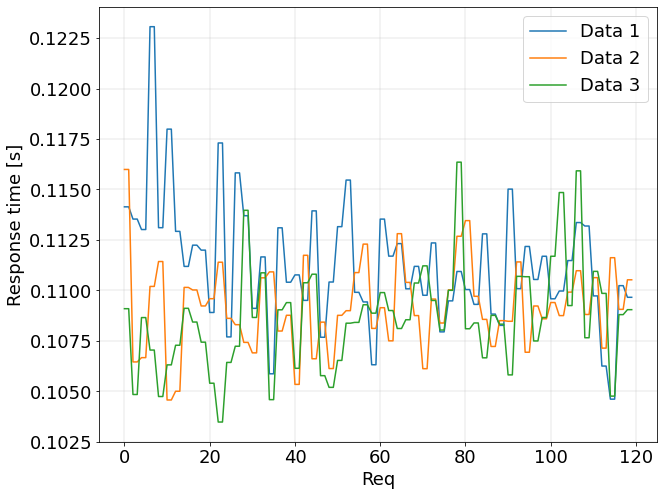

resnet_NHWC
Min: 0.0661, Max: 0.0798, Avg: 0.0695, Std: 0.0000
Min: 0.1724, Max: 0.1947, Avg: 0.1804, Std: 0.0000
Min: 0.2957, Max: 0.3261, Avg: 0.3078, Std: 0.0000


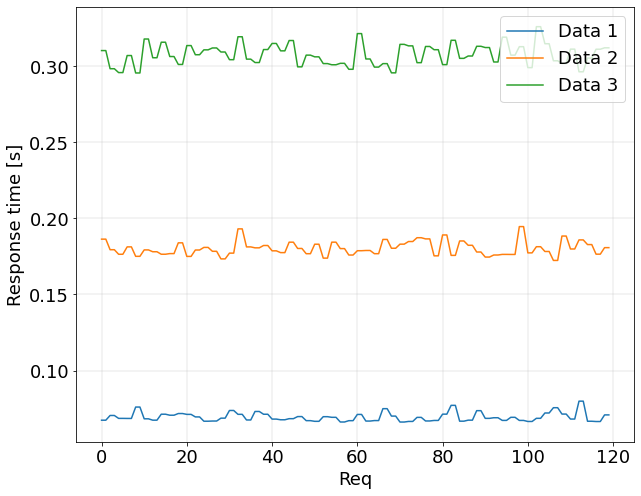

alexnet
Min: 0.1173, Max: 0.1371, Avg: 0.1217, Std: 0.0000
Min: 0.1142, Max: 0.1274, Avg: 0.1212, Std: 0.0000
Min: 0.1141, Max: 0.1266, Avg: 0.1184, Std: 0.0000


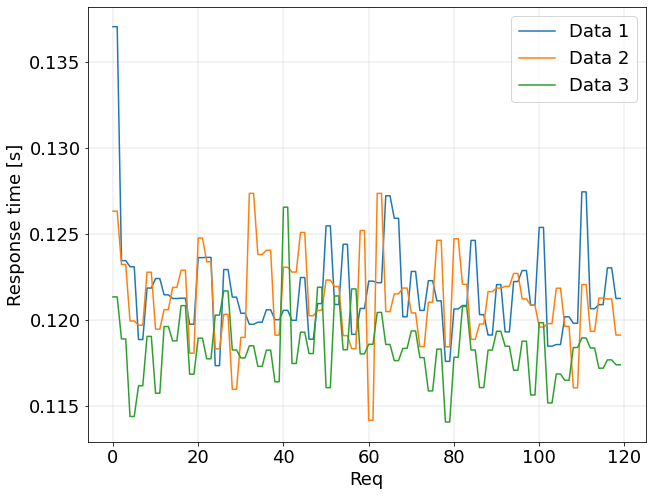

vgg16
Min: 0.2021, Max: 0.2217, Avg: 0.2077, Std: 0.0000
Min: 0.2005, Max: 0.2345, Avg: 0.2058, Std: 0.0000
Min: 0.1994, Max: 0.2141, Avg: 0.2043, Std: 0.0000


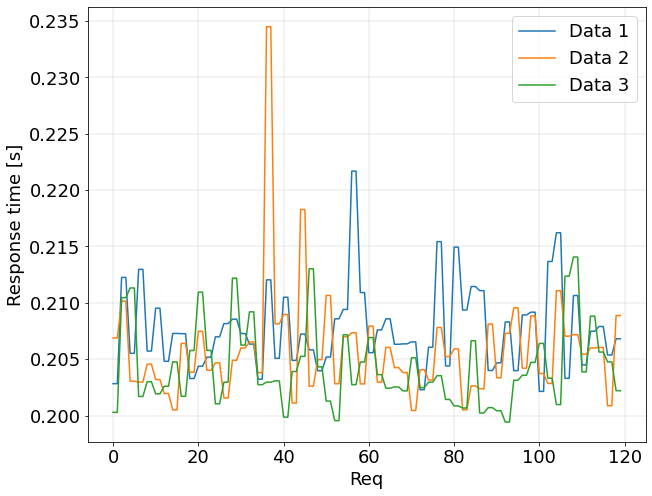

skyline_extraction
Min: 0.1245, Max: 0.1387, Avg: 0.1299, Std: 0.0000
Min: 0.1240, Max: 0.1380, Avg: 0.1297, Std: 0.0000
Min: 0.1250, Max: 0.1608, Avg: 0.1296, Std: 0.0000


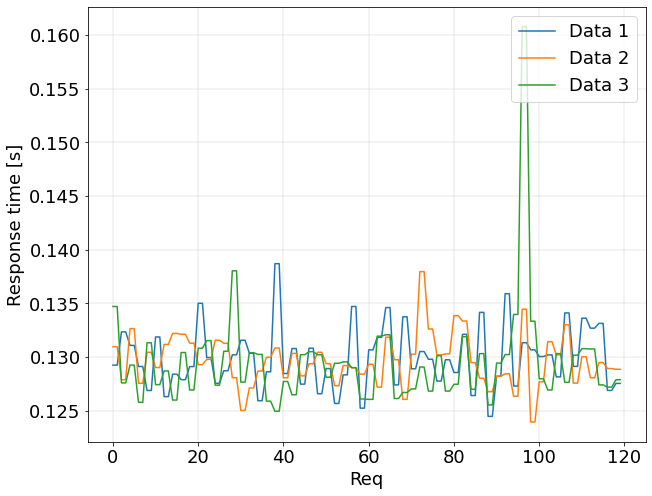

In [82]:
print("--- PROFILING ---")
for model in ["googlenet", "resnet_NHWC", "alexnet", "vgg16", "skyline_extraction"]:
    print(colored(model, "red"))
    show_profiling_overhead(base_folder + "profiling_" + model + ".out", aggregate=2)

#### Benchmark

--- BENCHMARK ---
resnet_NHWC
Min: 0.0685, Max: 0.0922, Avg: 0.0753, Std: 0.0000
PROCESS: Min: 0.0664, Max: 0.0908, Avg: 0.0734, Std: 0.0000

Min: 0.1806, Max: 0.2185, Avg: 0.1939, Std: 0.0000
PROCESS: Min: 0.1790, Max: 0.2179, Avg: 0.1926, Std: 0.0000

Min: 0.3105, Max: 0.3500, Avg: 0.3237, Std: 0.0001
PROCESS: Min: 0.3079, Max: 0.3473, Avg: 0.3207, Std: 0.0001



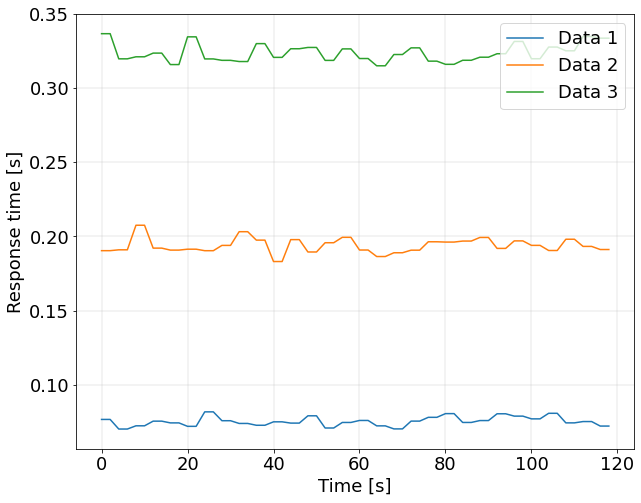

googlenet
Min: 0.1105, Max: 0.1266, Avg: 0.1190, Std: 0.0000
PROCESS: Min: 0.1057, Max: 0.1217, Avg: 0.1123, Std: 0.0000

Min: 0.1111, Max: 0.1354, Avg: 0.1194, Std: 0.0000
PROCESS: Min: 0.1067, Max: 0.1252, Avg: 0.1132, Std: 0.0000

Min: 0.1084, Max: 0.1246, Avg: 0.1167, Std: 0.0000
PROCESS: Min: 0.1055, Max: 0.1198, Avg: 0.1122, Std: 0.0000



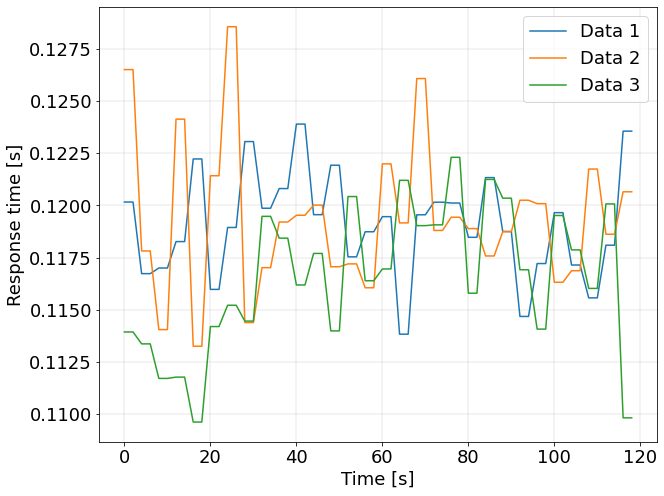

skyline
Min: 0.1321, Max: 0.1510, Avg: 0.1394, Std: 0.0000
PROCESS: Min: 0.1289, Max: 0.1463, Avg: 0.1353, Std: 0.0000

Min: 0.1319, Max: 0.1477, Avg: 0.1389, Std: 0.0000
PROCESS: Min: 0.1272, Max: 0.1371, Avg: 0.1327, Std: 0.0000

Min: 0.1320, Max: 0.1468, Avg: 0.1393, Std: 0.0000
PROCESS: Min: 0.1255, Max: 0.1379, Avg: 0.1319, Std: 0.0000



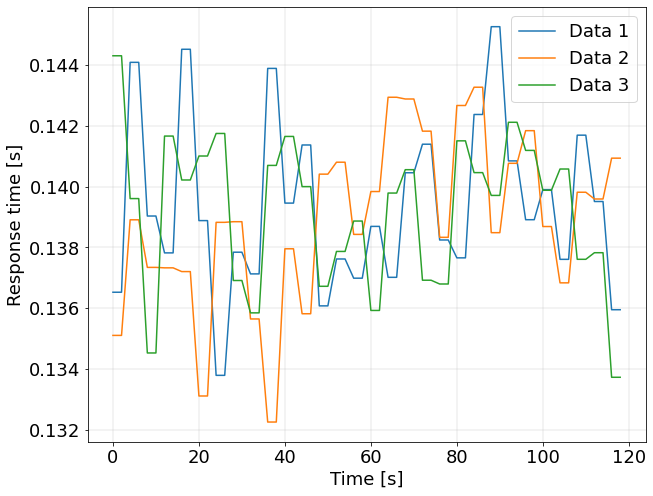

vgg16
Min: 0.2082, Max: 0.2320, Avg: 0.2188, Std: 0.0000
PROCESS: Min: 0.2040, Max: 0.2235, Avg: 0.2115, Std: 0.0000

Min: 0.2092, Max: 0.2293, Avg: 0.2172, Std: 0.0000
PROCESS: Min: 0.2040, Max: 0.2222, Avg: 0.2102, Std: 0.0000

Min: 0.2053, Max: 0.2499, Avg: 0.2154, Std: 0.0000
PROCESS: Min: 0.2029, Max: 0.2470, Avg: 0.2113, Std: 0.0000



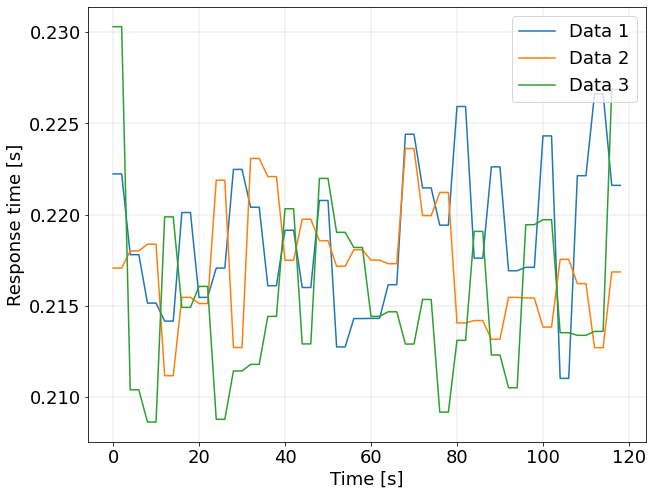

In [83]:
print("--- BENCHMARK ---")
load_sizes = ["small", "medium", "large"]
print(colored("resnet_NHWC", "red"))
show_benchmark_overhead([base_folder + "benchmark_resnet_NHWC_" + load_size + ".out" for load_size in load_sizes], aggregate=2)
print(colored("googlenet", "red"))
show_benchmark_overhead([base_folder + "benchmark_googlenet_" + load_size + ".out" for load_size in load_sizes], aggregate=2)
print(colored("skyline", "red"))
show_benchmark_overhead([base_folder + "benchmark_skyline_extraction_" + load_size + ".out" for load_size in load_sizes], aggregate=2)
print(colored("vgg16", "red"))
show_benchmark_overhead([base_folder + "benchmark_vgg16_" + load_size + ".out" for load_size in load_sizes], aggregate=2)

### Variable SLA

In [84]:
base_folder = "controller/sla/"

#### resnet_NHWC
- test executed with "large.jpg" input

1. thesis results


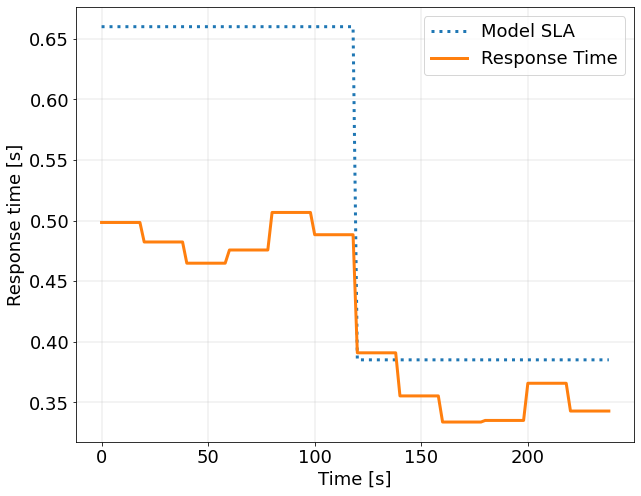

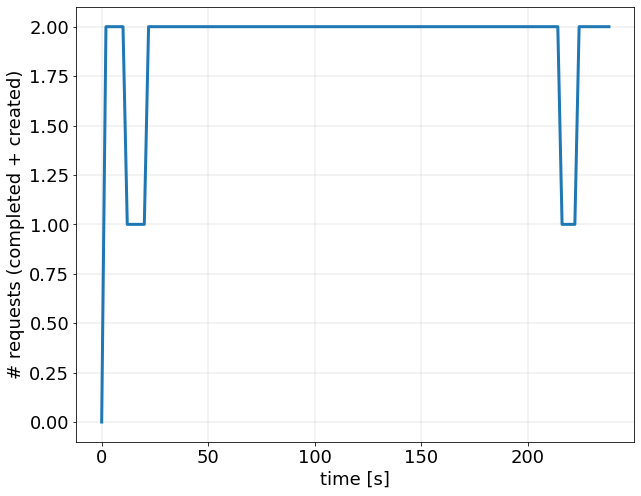

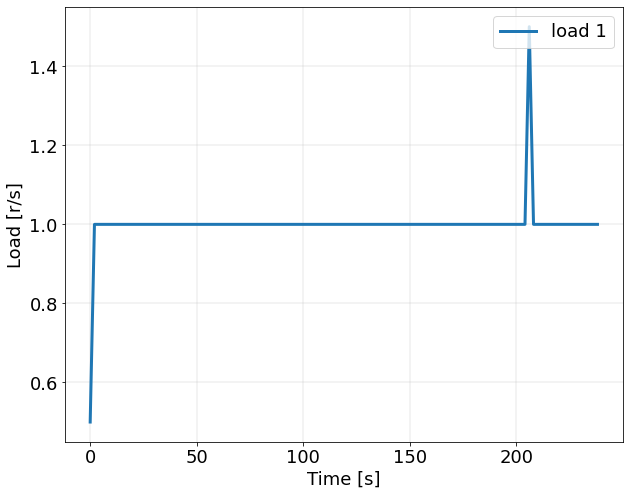

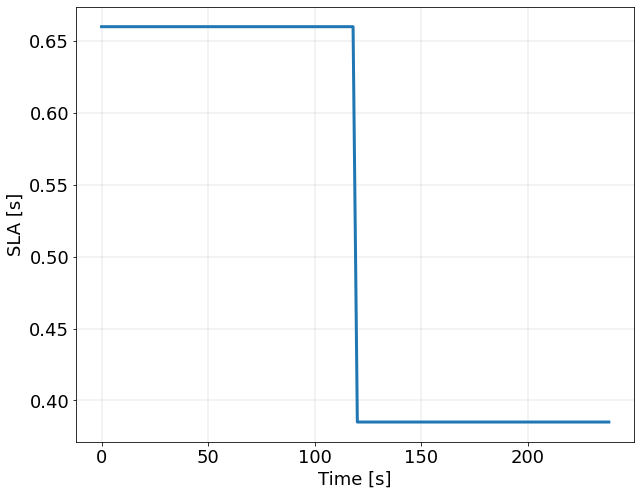

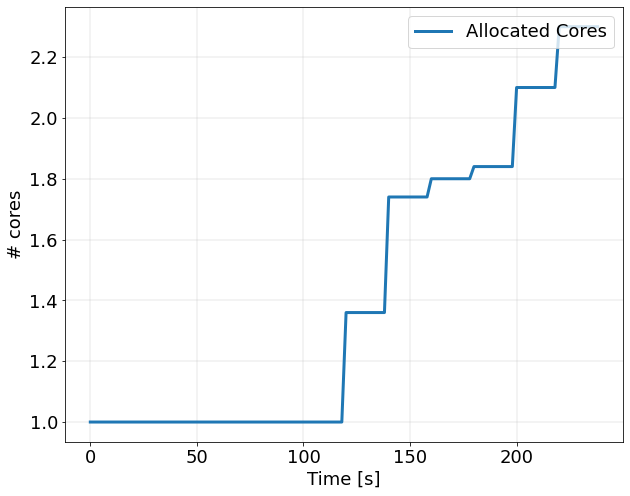

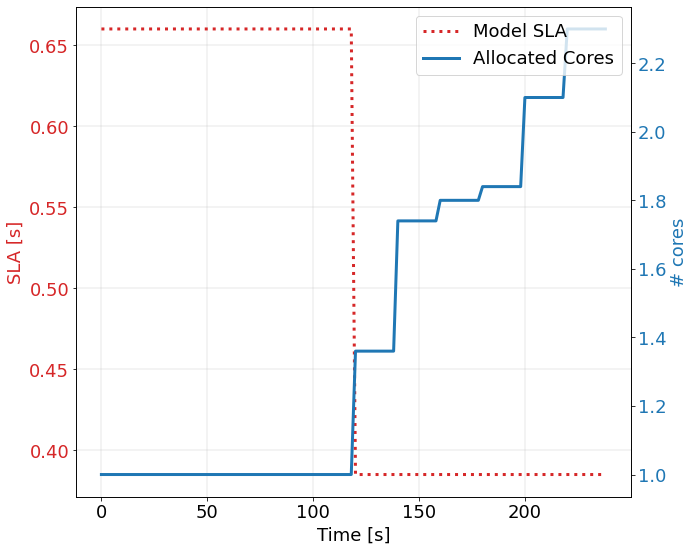

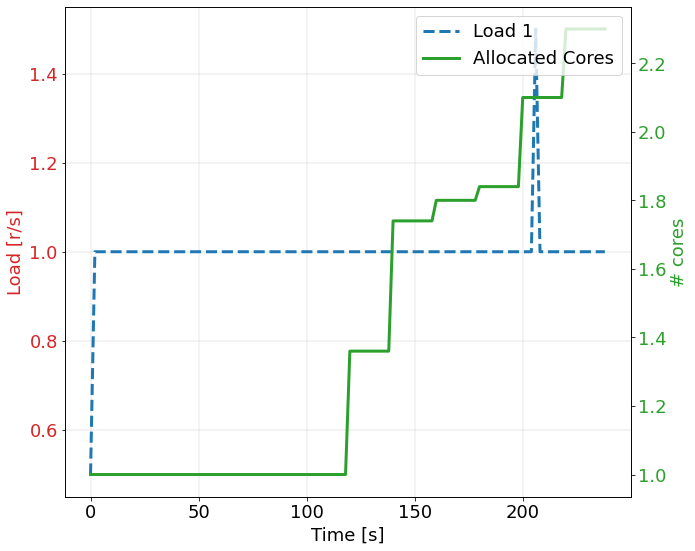

In [85]:
print(colored("1. thesis results", "red"))
show_values(base_folder + "benchmark_resnet_NHWC.out.old", 2, aggregate=10)
# print("--------------- with tfserving:latest")
# show_values(base_folder + "benchmark_resnet_NHWC.out", 2, aggregate=10)

2. new with tfserving:2.0.0


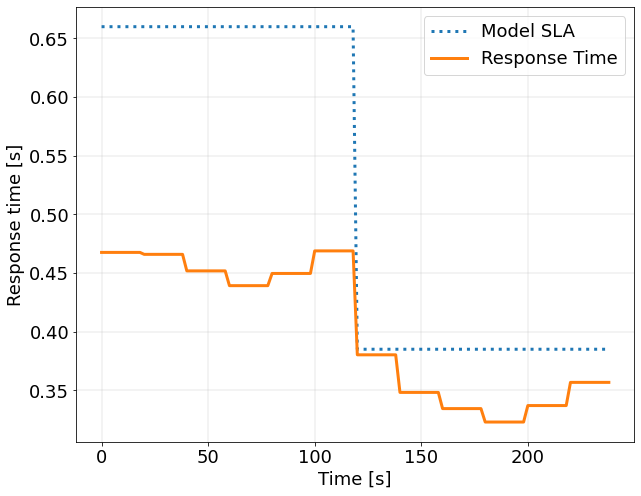

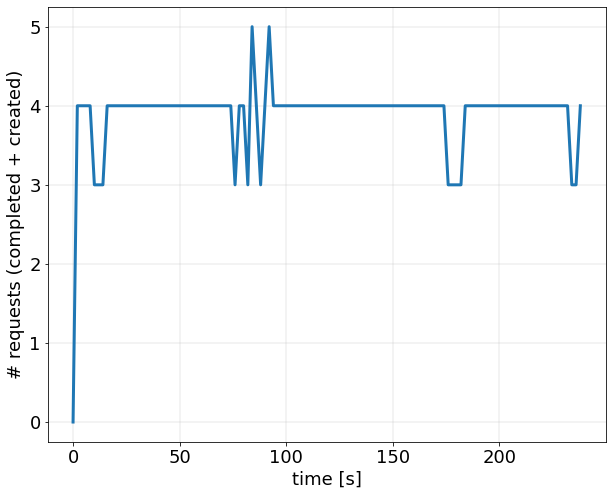

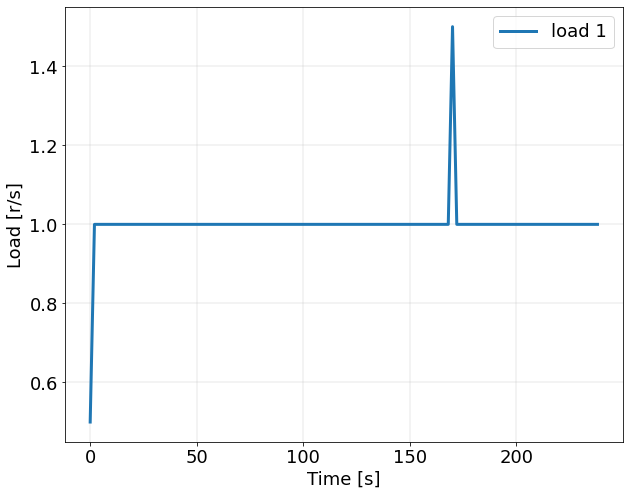

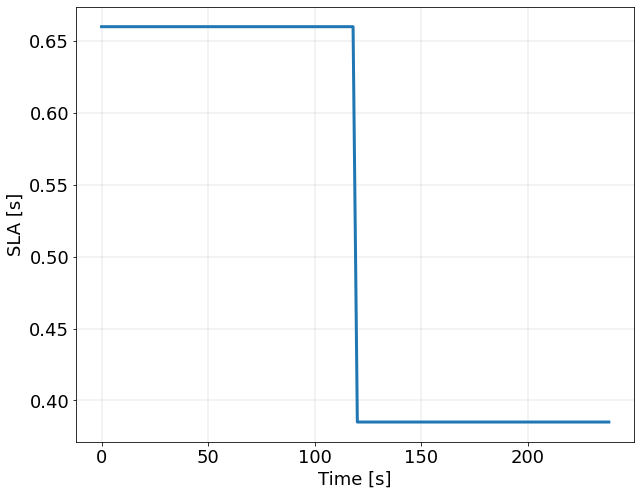

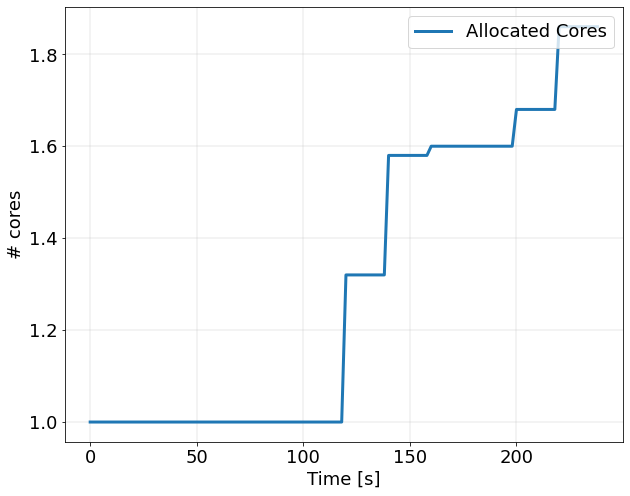

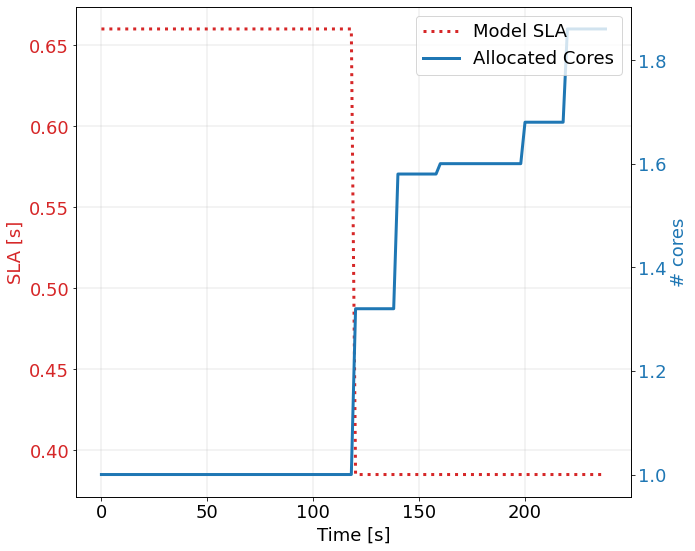

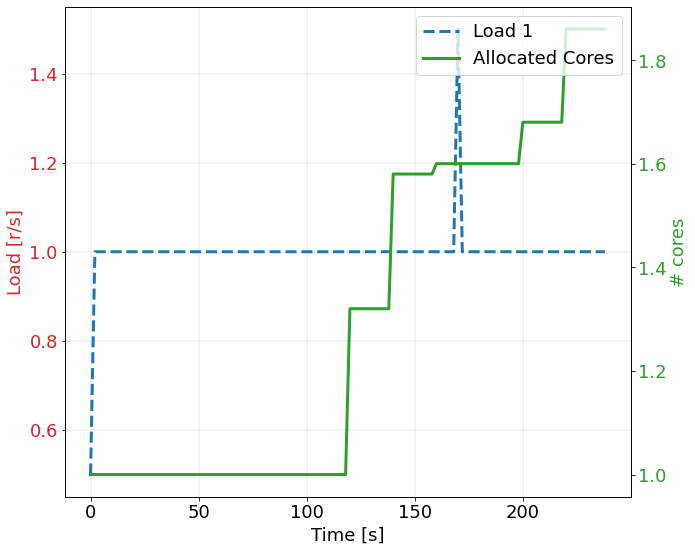

In [86]:
print(colored("2. new with tfserving:2.0.0", "red"))
show_values(base_folder + "benchmark_resnet_NHWC_2.0.0.out", 2, aggregate=10)

#### vgg16

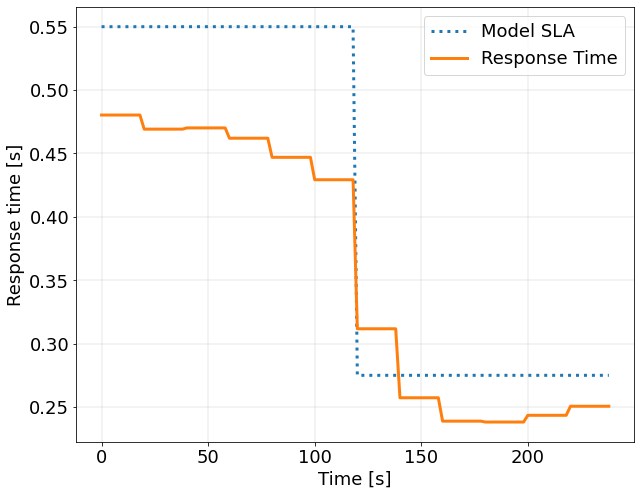

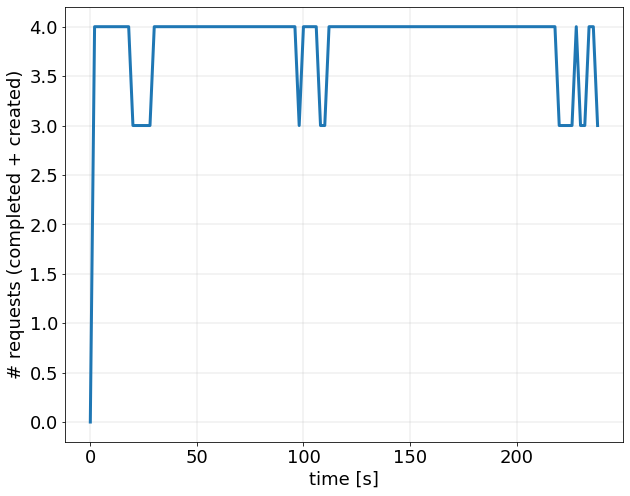

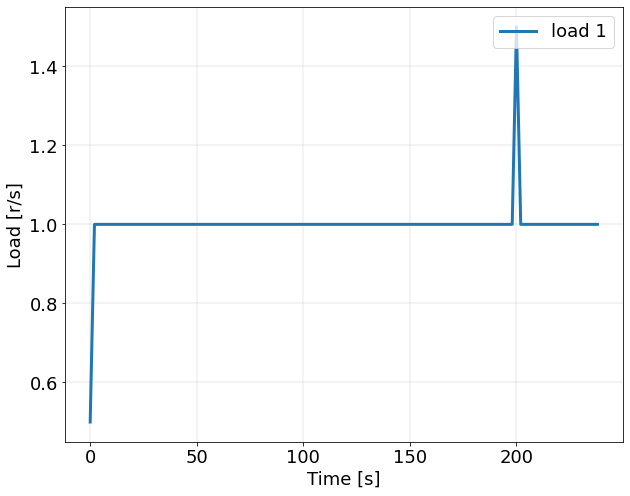

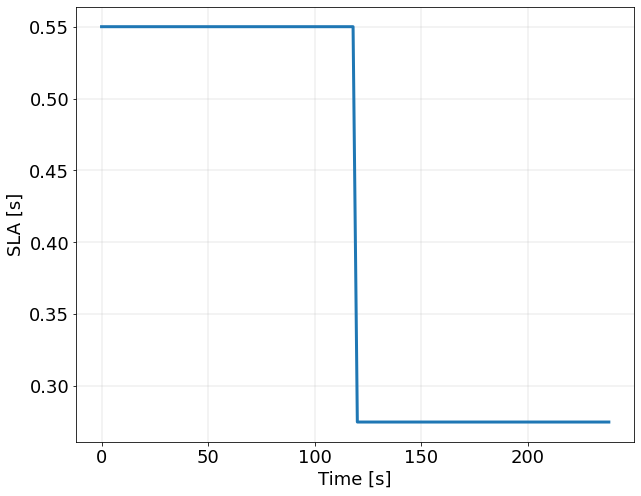

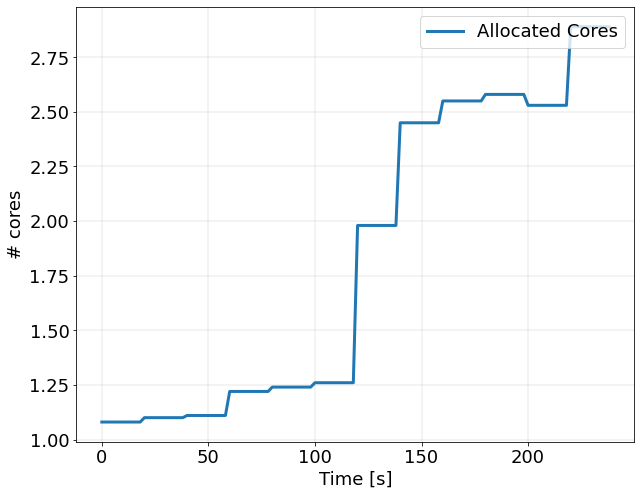

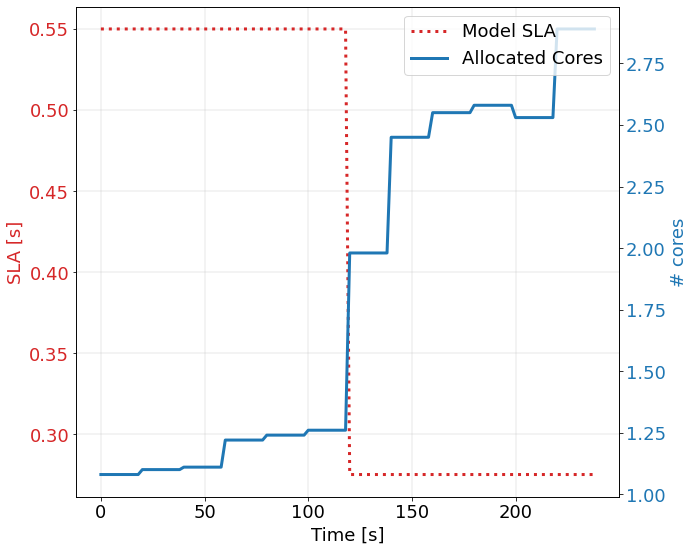

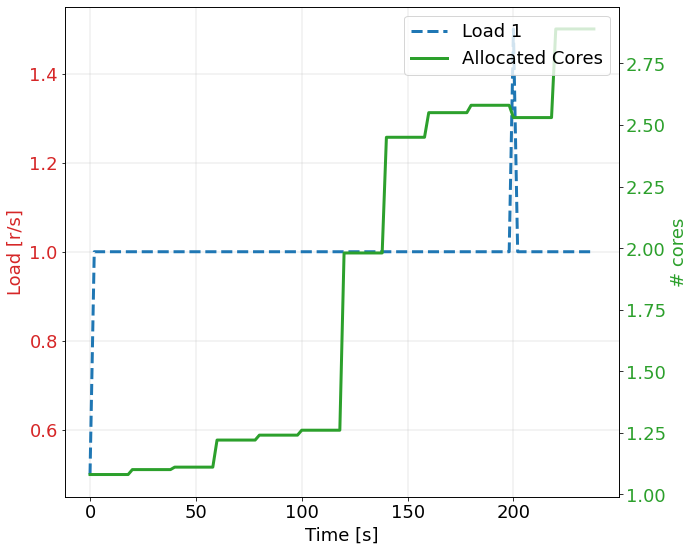

In [87]:
show_values(base_folder + "benchmark_vgg16.out", 2, aggregate=10)

#### googlenet

1. control period=1s, tf=2.0.0, rounding=3, p_c=¼ rispetto originale, sla=1.2


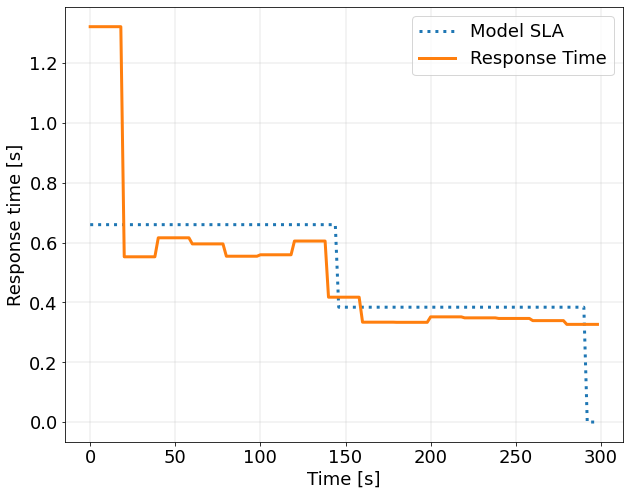

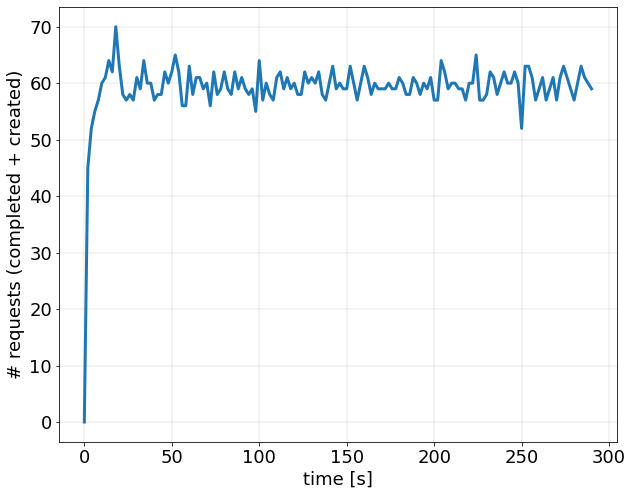

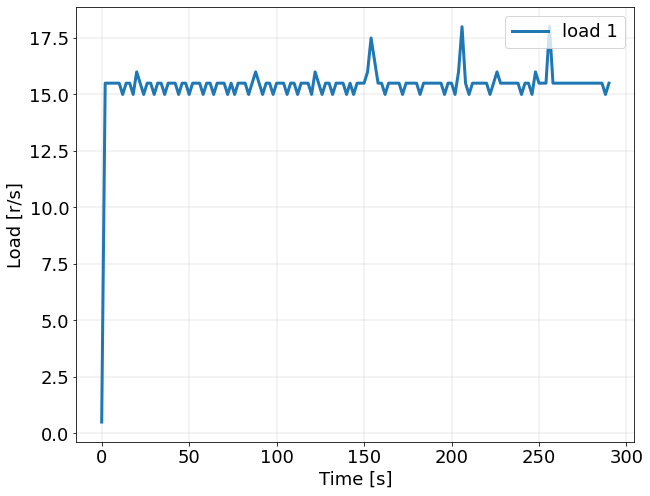

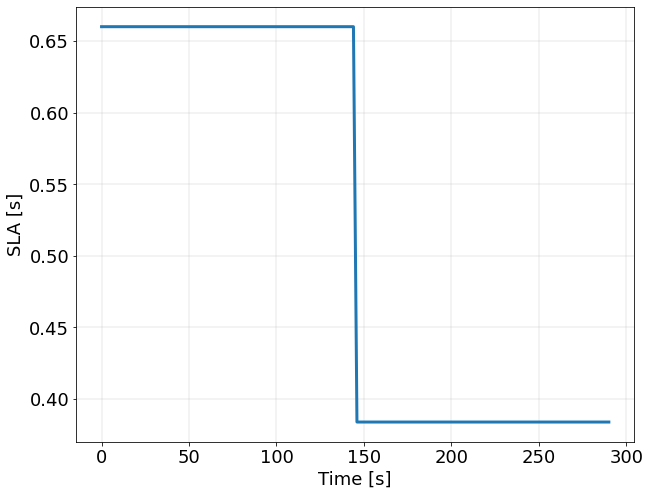

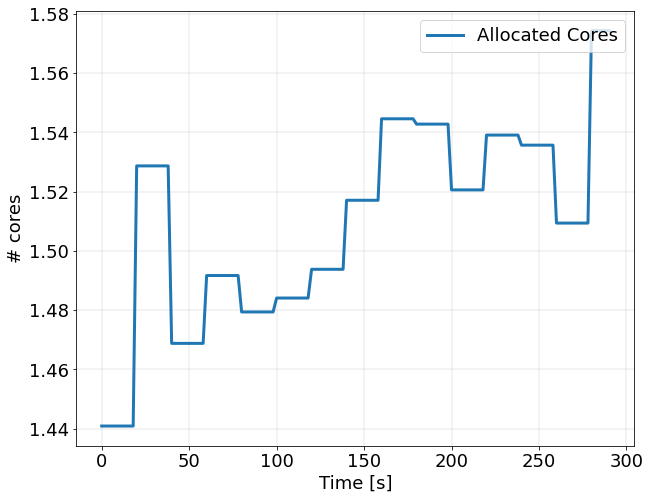

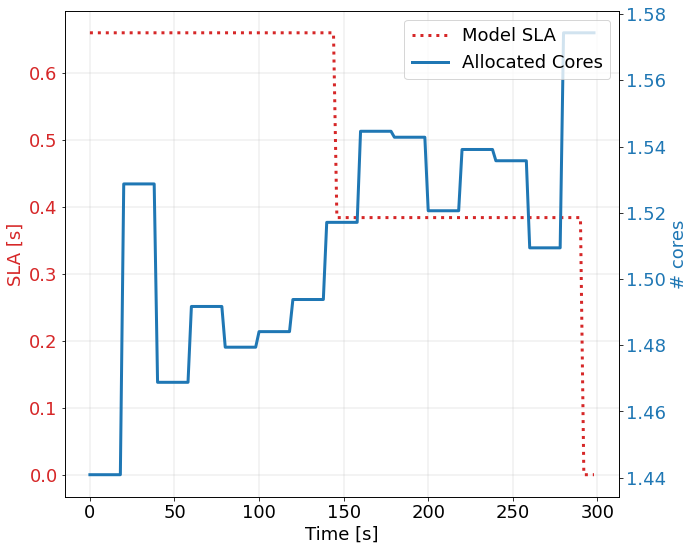

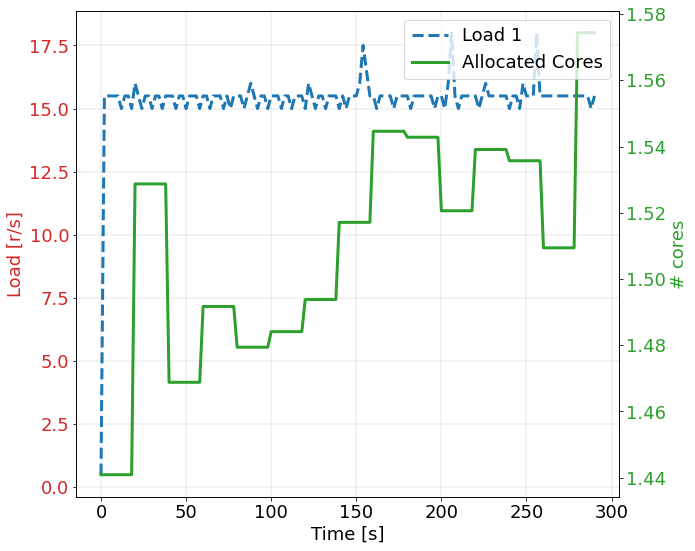

In [88]:
"""
print("--------------- 22/04")
show_values(base_folder + "benchmark_googlenet_2204.out", 2, aggregate=10)
print("--------------- control period=1s")
show_values(base_folder + "benchmark_googlenet_cp1s.out", 2, aggregate=10)
print("--------------- control period=1s, rounding 3rd decimal digit")
show_values(base_folder + "benchmark_googlenet_cp1s_round3.out", 2, aggregate=10)
print("--------------- control period=1s, b_c=0.15, d_c=0.11 (-0.05 rispetto originale)")
show_values(base_folder + "benchmark_googlenet_cp1s_-0.05.out", 2, aggregate=10)
print("--------------- control period=5s, b_c=0.15, d_c=0.11 (-0.05 rispetto originale)")
show_values(base_folder + "benchmark_googlenet_-0.05.out", 2, aggregate=10)
print("--------------- control period=1s, tf=2.0.0, rounding=3, b_c=0.10, d_c=0.08 (metà rispetto originale)")
show_values(base_folder + "benchmark_googlenet_p2.out", 2, aggregate=10)
print("--------------- control period=1s, tf=2.0.0, rounding=3, b_c=0.05, d_c=0.04 (¼ rispetto originale)")
show_values(base_folder + "benchmark_googlenet_p4.out", 2, aggregate=10)
"""
print(colored("1. control period=1s, tf=2.0.0, rounding=3, p_c=¼ rispetto originale, sla=1.2", "red"))
show_values(base_folder + "benchmark_googlenet_p4_2.out", 2, aggregate=10, sla=1.2)

#### skyline_extraction

1. control period=1s, tf=2.0.0, rounding=3, p_c=¼ rispetto originale, sla=1.2


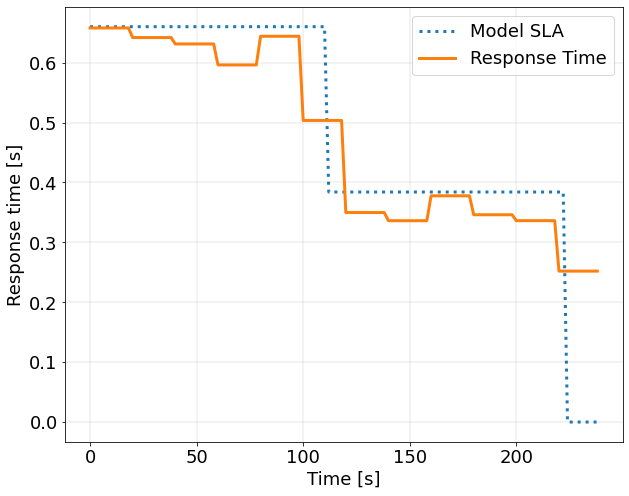

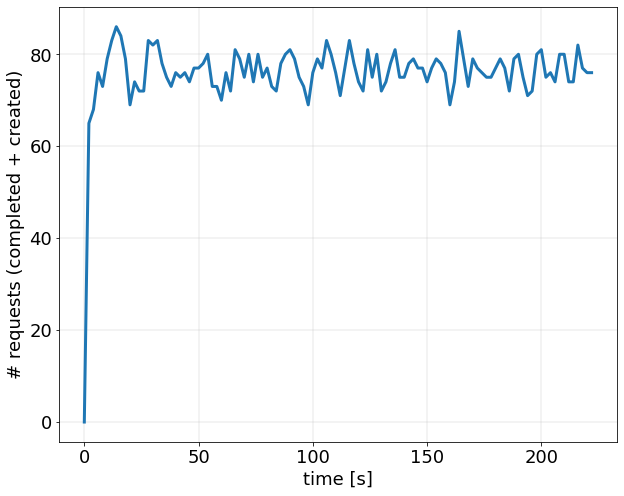

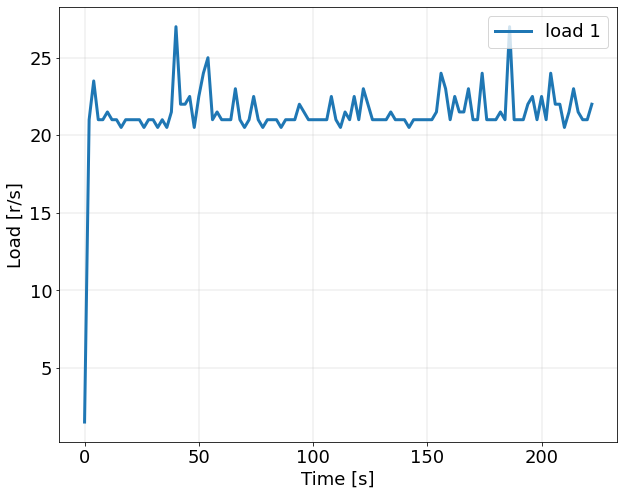

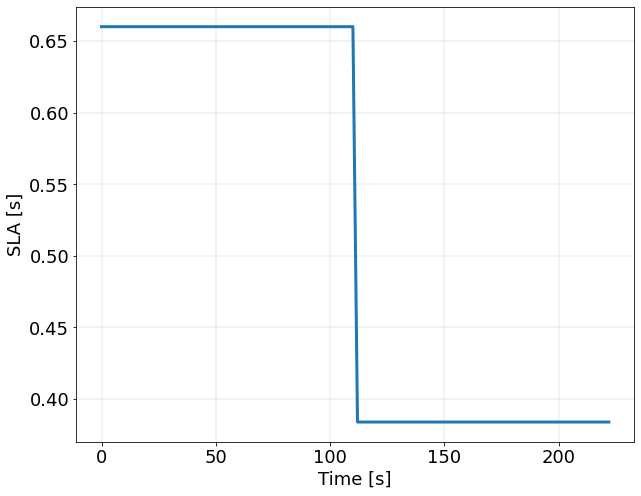

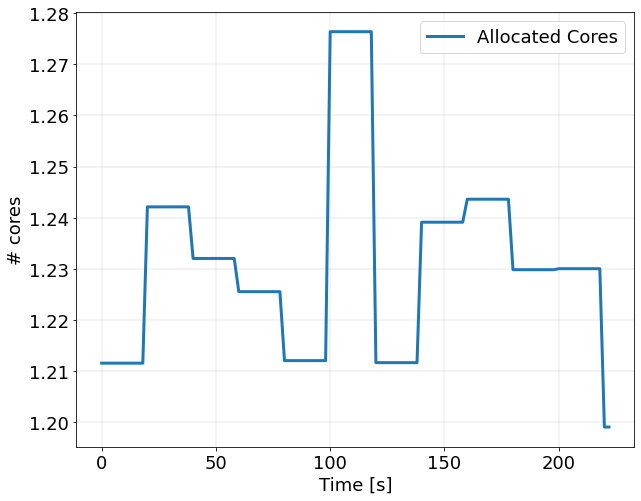

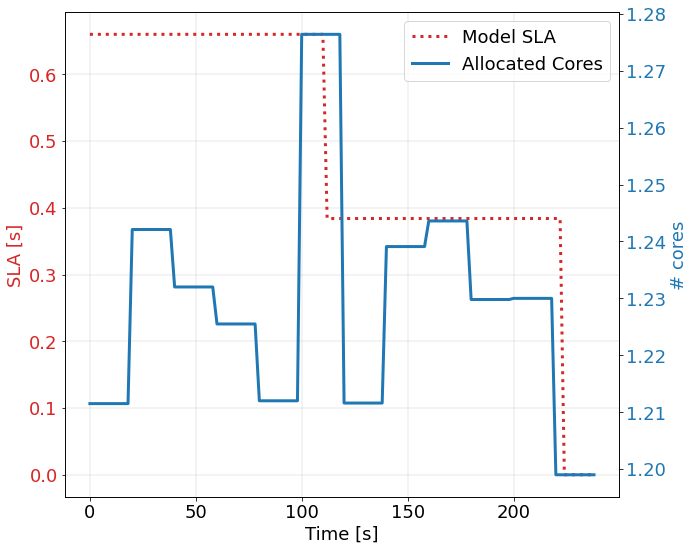

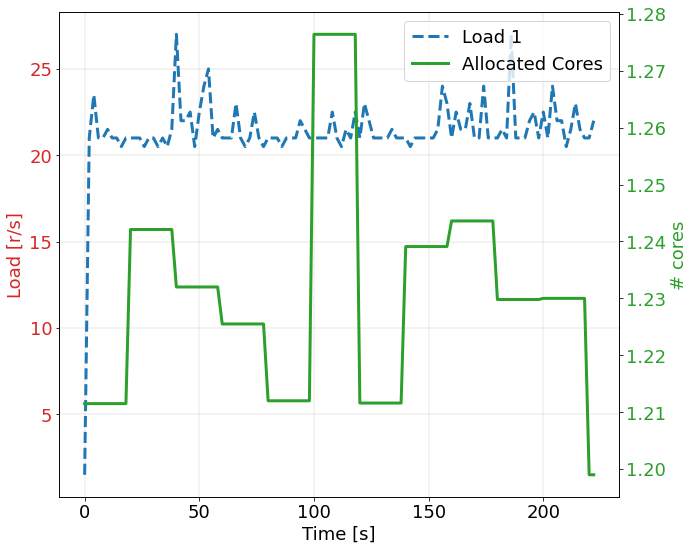

In [89]:
"""
print("--------------- 2204")
show_values(base_folder + "benchmark_skyline_extraction_2204.out", 2, aggregate=10)
print("--------------- control period=1s, tf=2.0.0, rounding=3, p_c=½ rispetto originale")
show_values(base_folder + "benchmark_skyline_extraction_p2.out", 2, aggregate=10)
print("--------------- control period=1s, tf=2.0.0, rounding=3, p_c=¼ rispetto originale")
show_values(base_folder + "benchmark_skyline_extraction_p4.out", 2, aggregate=10)
"""
print(colored("1. control period=1s, tf=2.0.0, rounding=3, p_c=¼ rispetto originale, sla=1.2", "red"))
show_values(base_folder + "benchmark_skyline_extraction_p4_2.out", 2, aggregate=10, sla=1.2)

### Variable Input

#### resnet_nhwc

1. resnet


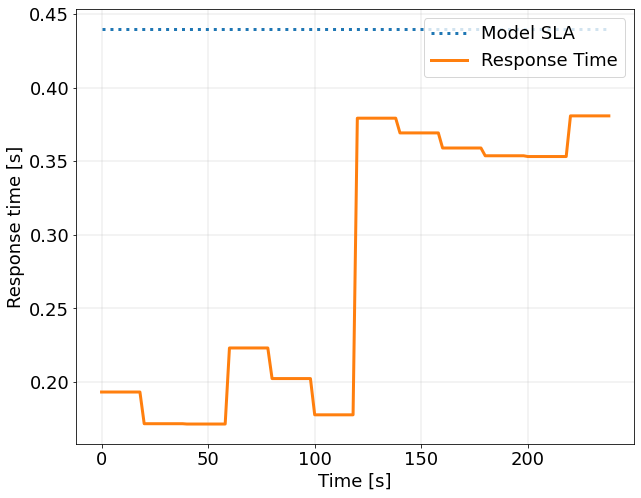

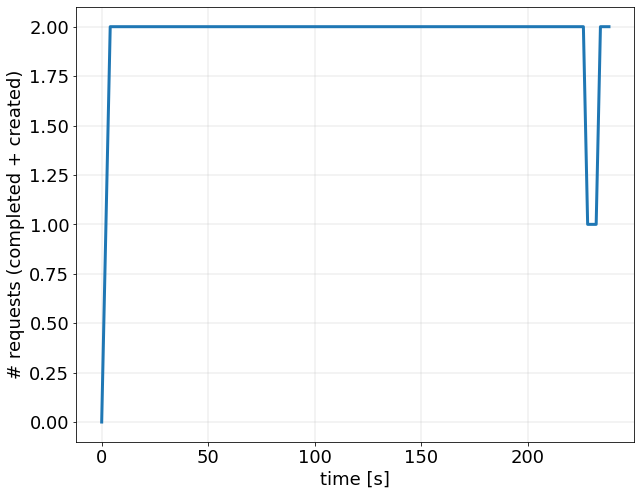

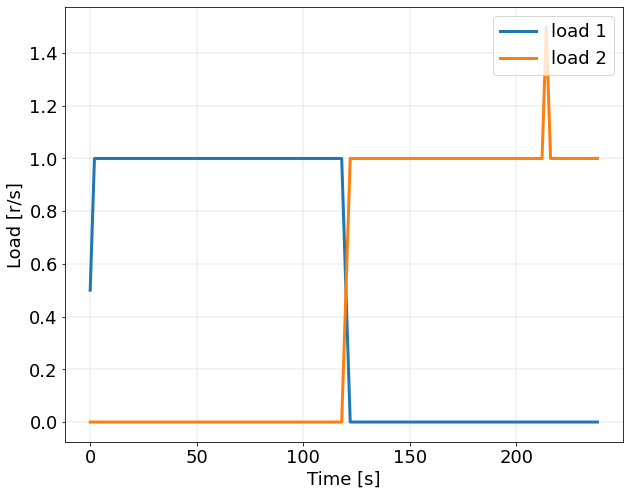

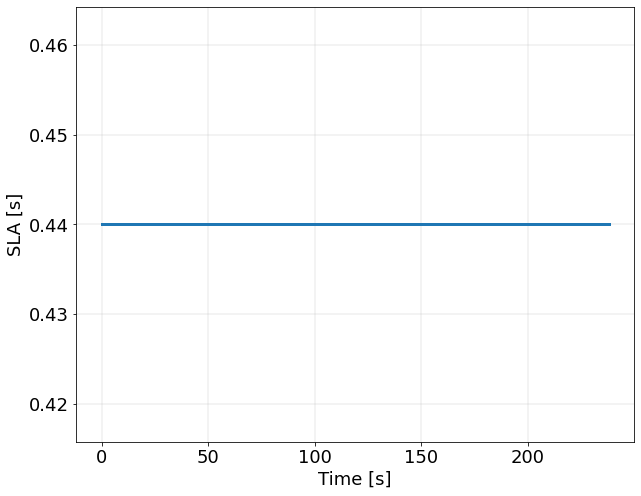

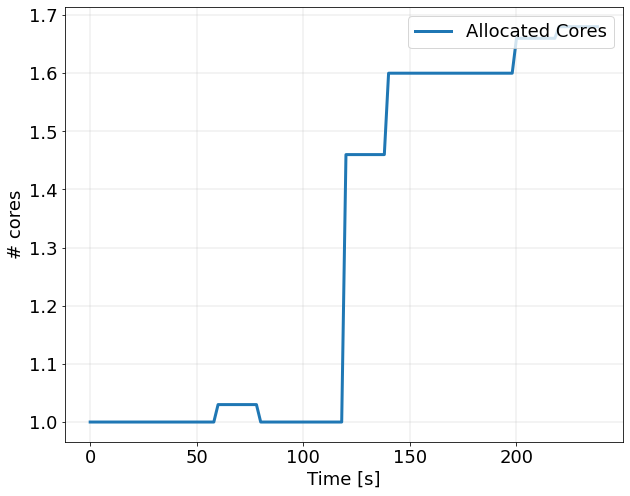

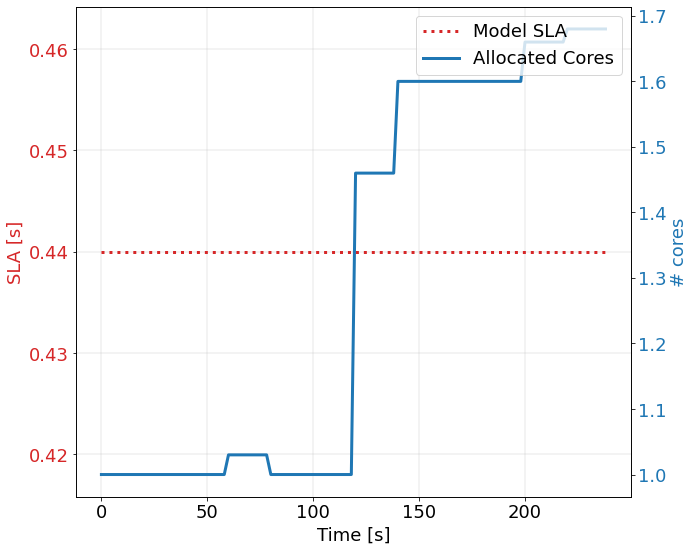

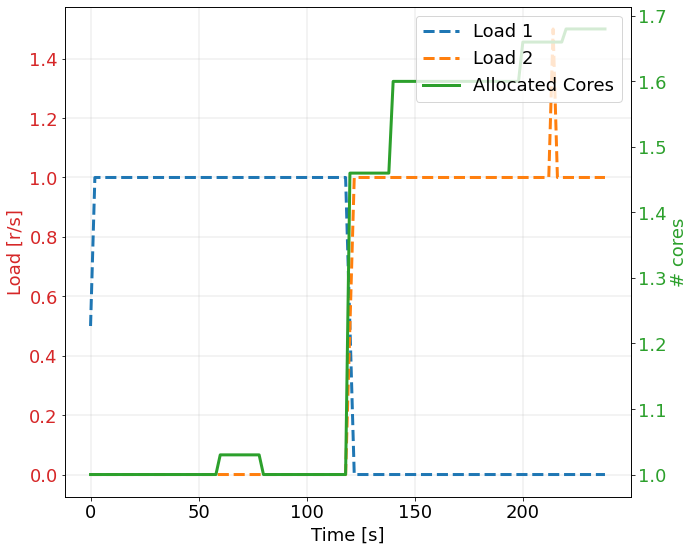

In [90]:
base_folder = "controller/input/"
print(colored("1. resnet", "red"))
show_values(base_folder + "benchmark_resnet_NHWC.out", 2, aggregate=10)

### Variable Workload

In [91]:
base_folder = "controller/reqs/"

#### resnet_nhwc

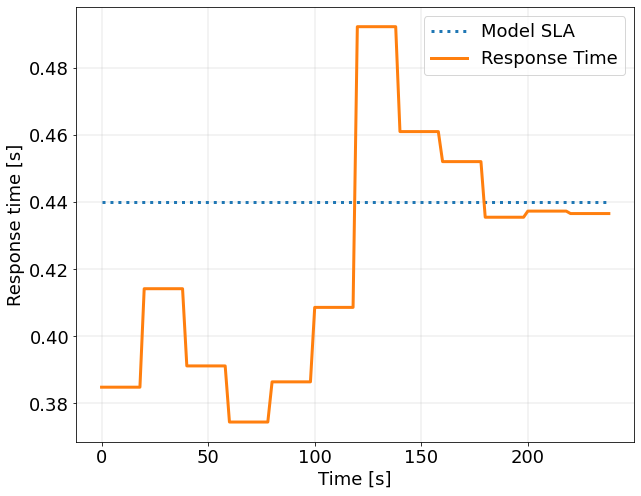

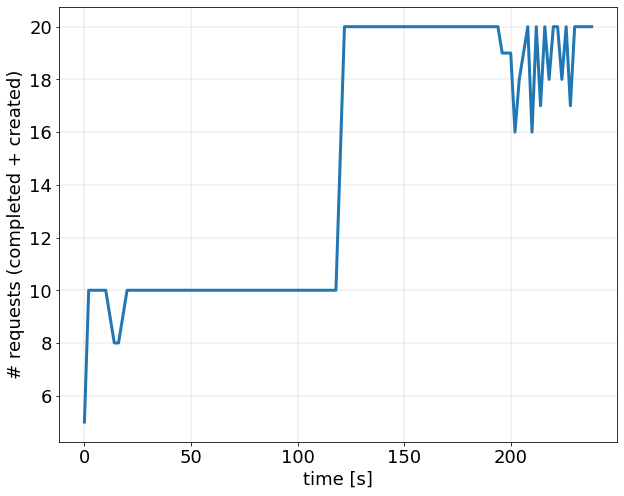

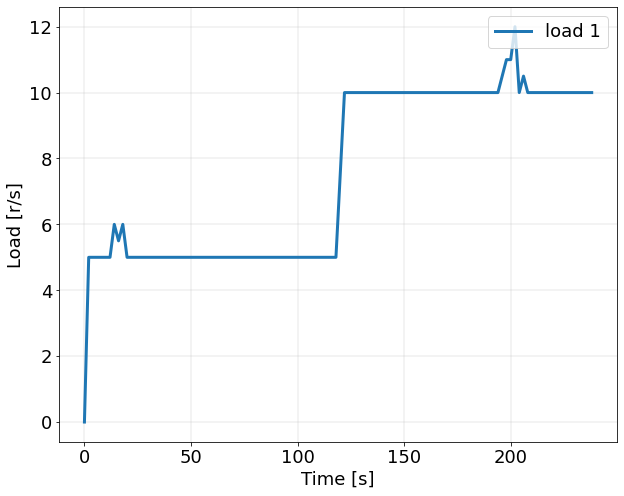

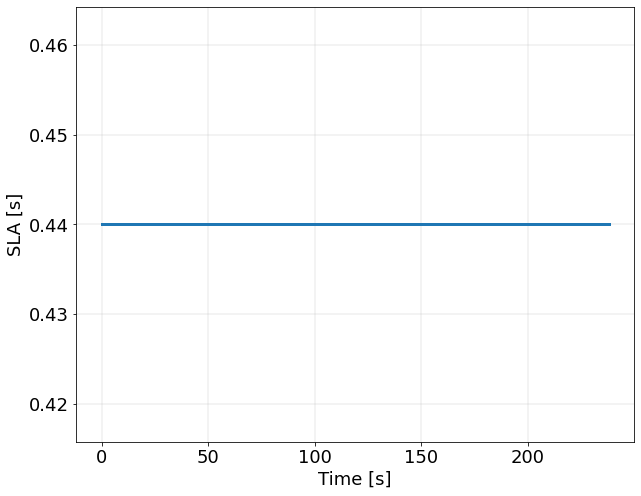

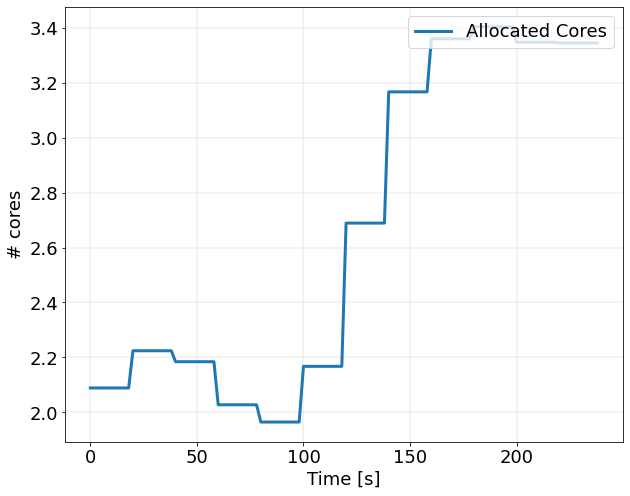

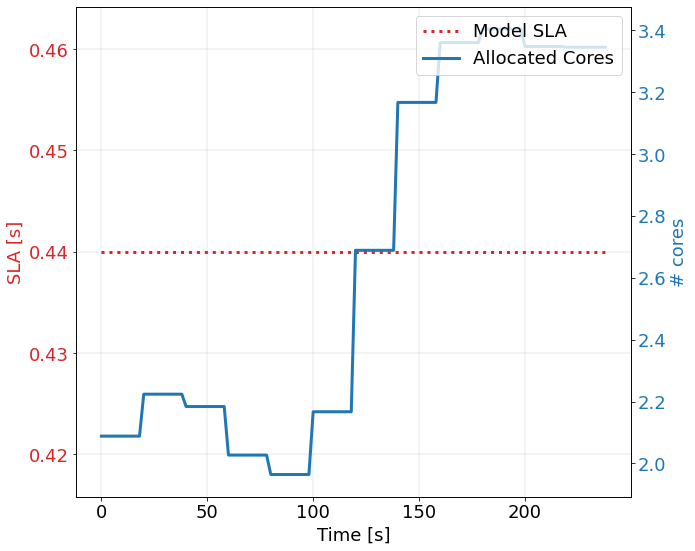

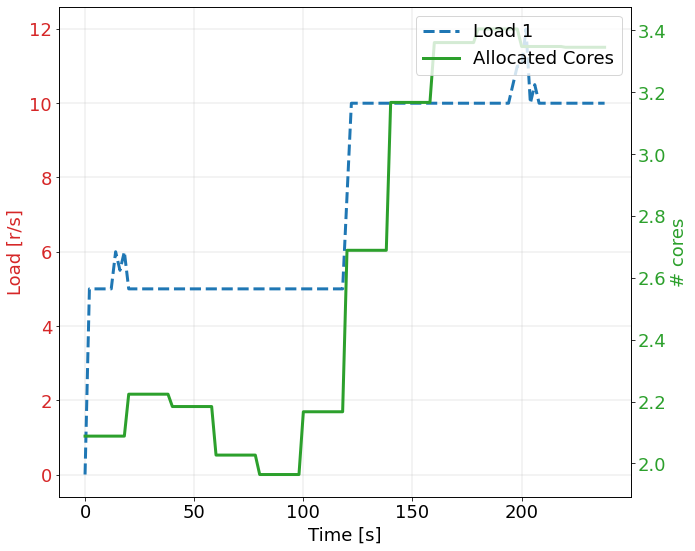

In [92]:
show_values(base_folder + "benchmark_resnet_NHWC_small.out", 2,aggregate=10)

#### vgg16

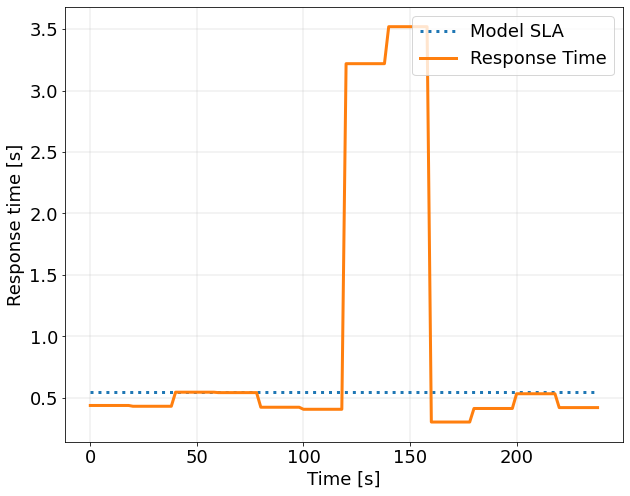

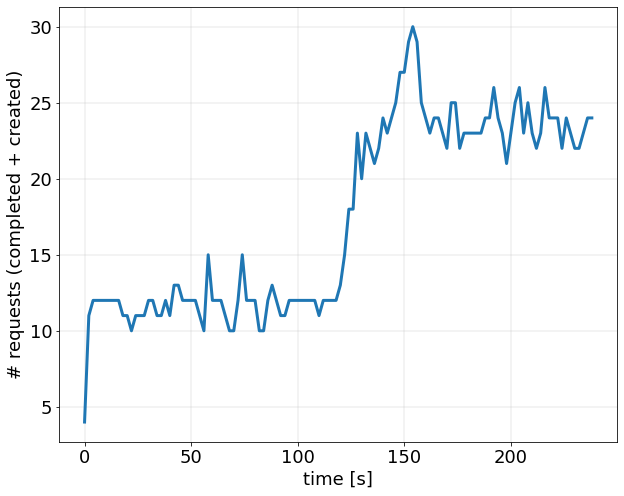

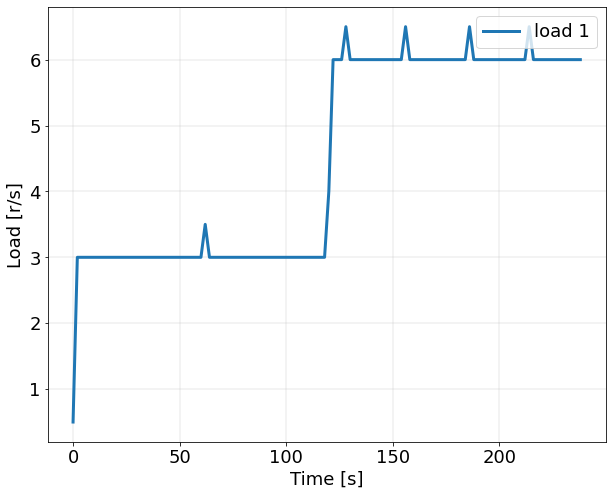

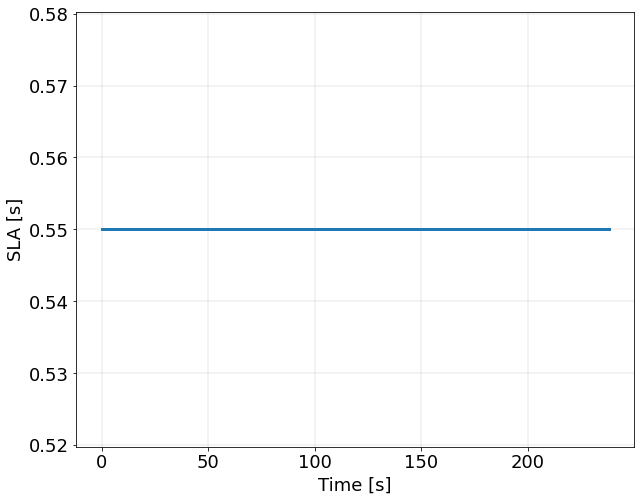

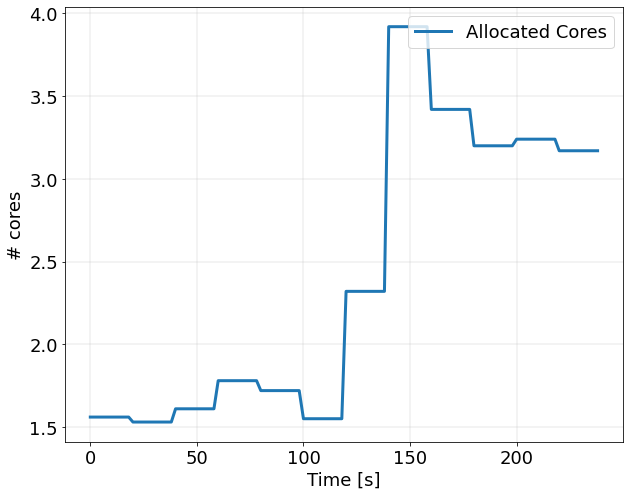

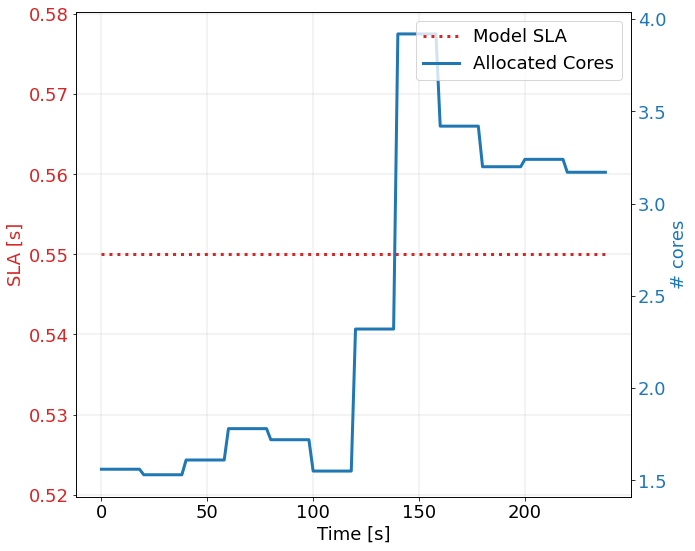

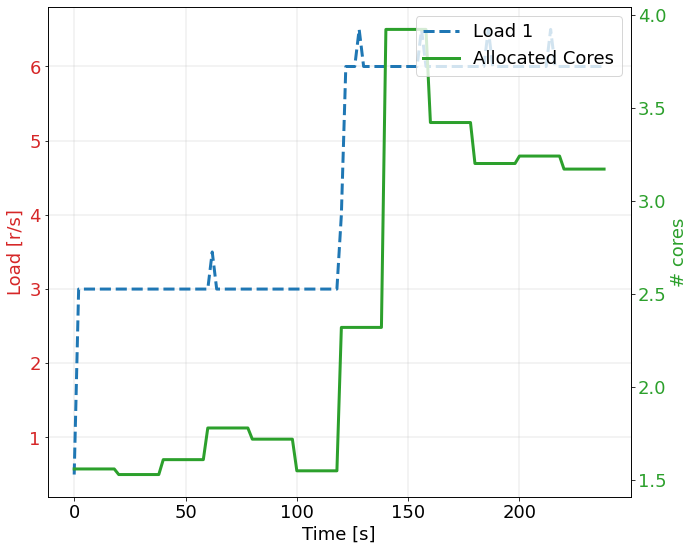

In [93]:
show_values(base_folder + "benchmark_vgg16_small.out", 2, aggregate=10)

#### googlenet

1. control period=1s, tf=2.0.0, rounding=3, p_c=½ rispetto originale, sla=1.2, d=300s, 15->20


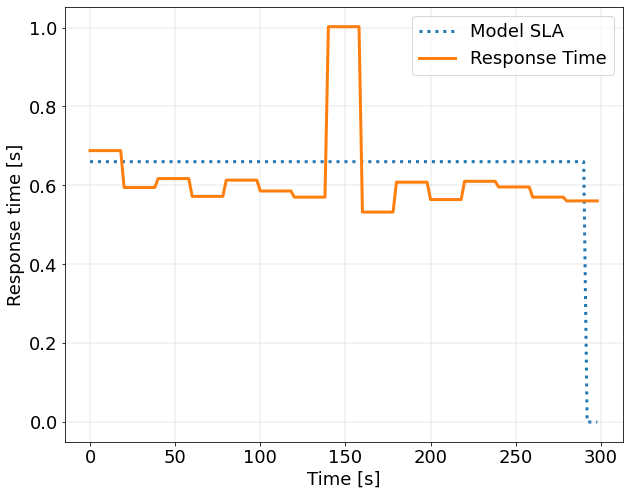

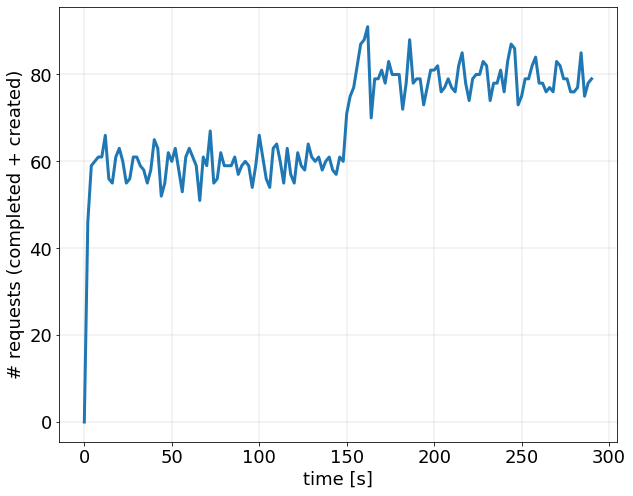

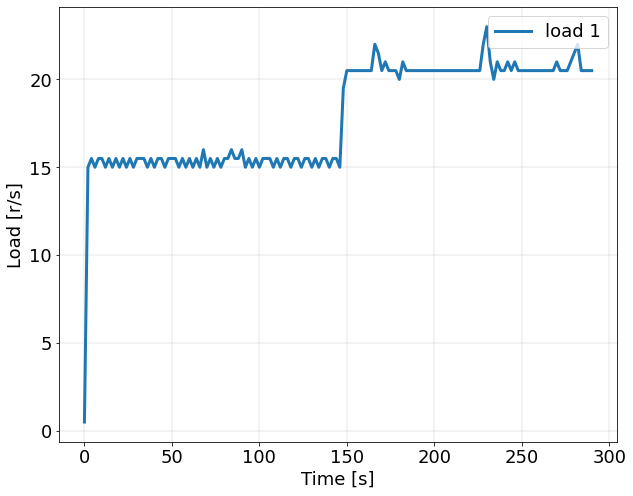

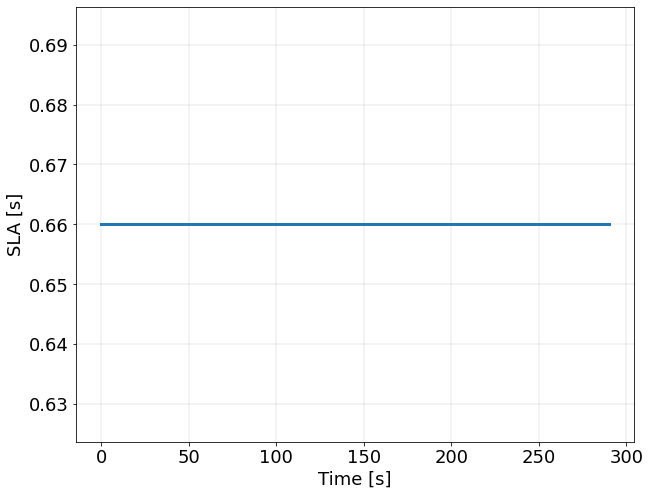

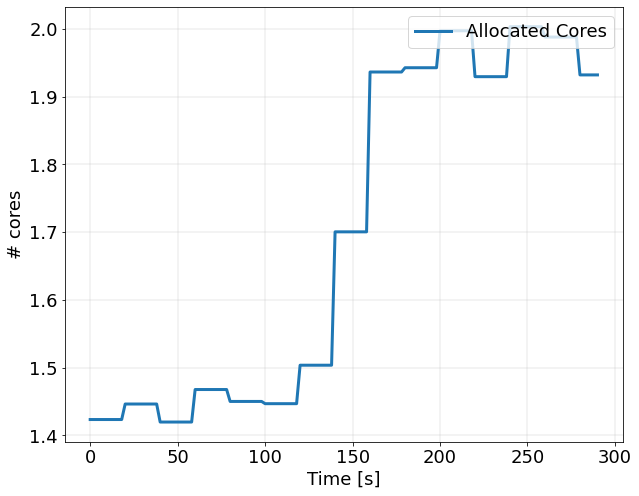

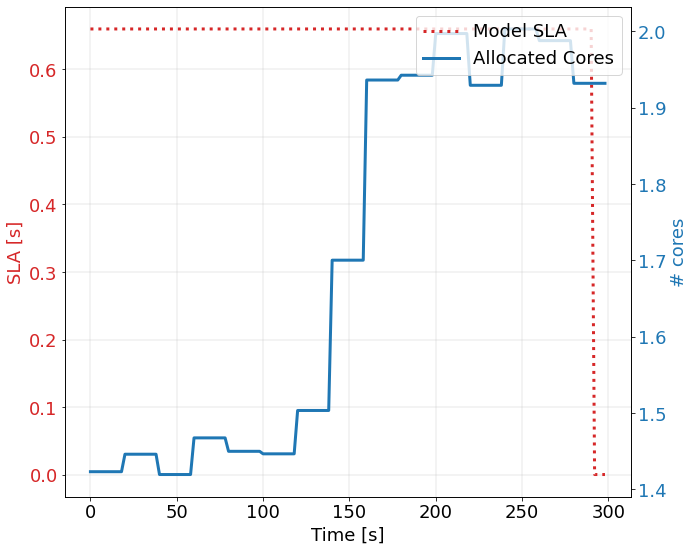

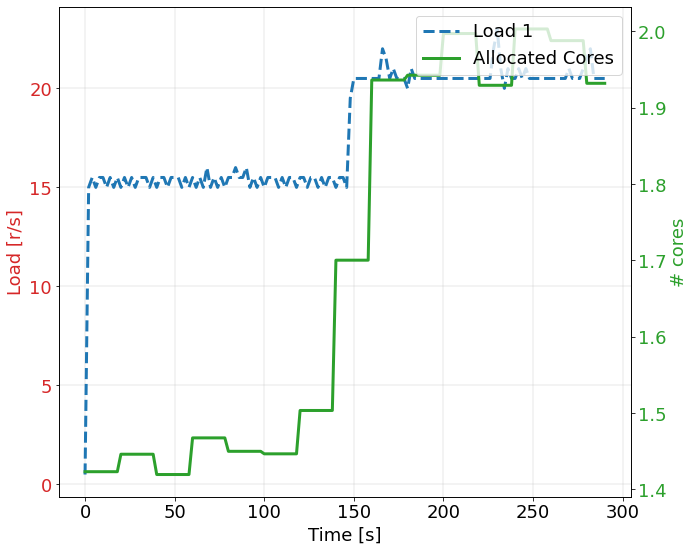

'\nprint("----------- control period=1s, tf=2.0.0, rounding=3, p_c=¼ rispetto originale, sla=1.2, d=300s")\nshow_values(base_folder + "benchmark_googlenet_small_p4.out", 2, aggregate=10, sla=1.2)\nprint("----------- rules control period=15s, tf=2.0.0, sla=1.2, d=300s")\nshow_values(base_folder + "benchmark_googlenet_small_rules.out", 2, aggregate=False, sla=1.2)\n'

In [94]:
"""
print("----------- 2204")
show_values(base_folder + "benchmark_googlenet_small.out", 2, aggregate=10)
print("----------- control period=1s, tf=2.0.0, rounding=3, p_c=½ rispetto originale, sla=1.2, d=300s")
show_values(base_folder + "benchmark_googlenet_small_p2.out", 2, aggregate=10, sla=1.2)
"""
print(colored("1. control period=1s, tf=2.0.0, rounding=3, p_c=½ rispetto originale, sla=1.2, d=300s, 15->20", "red"))
show_values(base_folder + "benchmark_googlenet_small_p2_2.out", 2, aggregate=10, sla=1.2)
"""
print("----------- control period=1s, tf=2.0.0, rounding=3, p_c=¼ rispetto originale, sla=1.2, d=300s")
show_values(base_folder + "benchmark_googlenet_small_p4.out", 2, aggregate=10, sla=1.2)
print("----------- rules control period=15s, tf=2.0.0, sla=1.2, d=300s")
show_values(base_folder + "benchmark_googlenet_small_rules.out", 2, aggregate=False, sla=1.2)
"""

#### skyline_extraction

1. control period=1s, tf=2.0.0, rounding=3, p_c=¼ rispetto originale, sla=1.2, d=300s


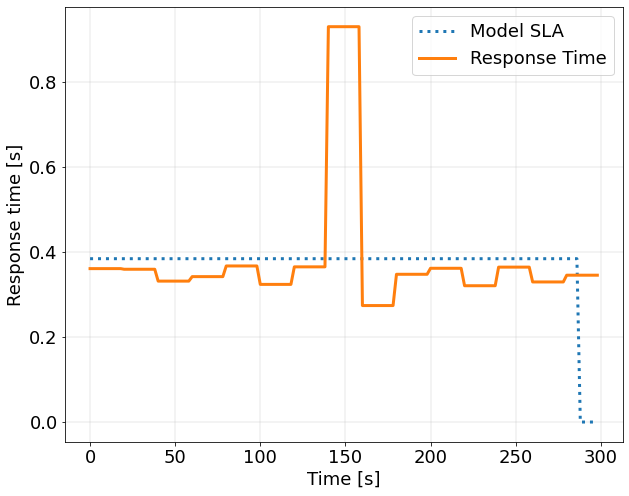

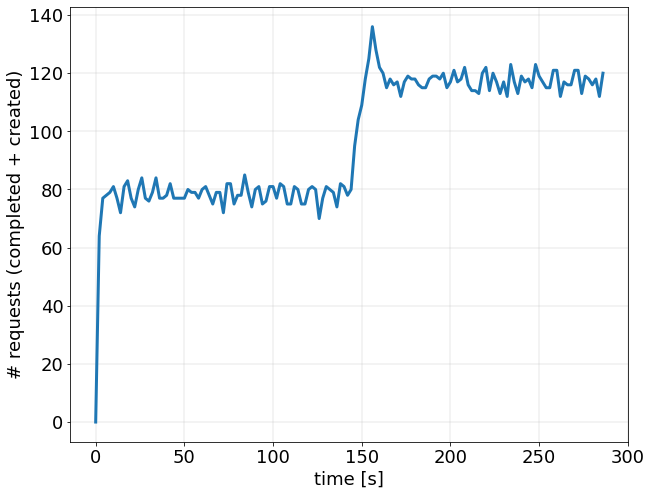

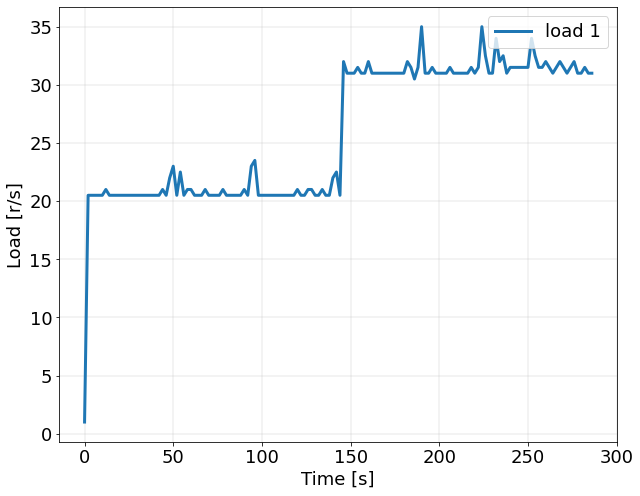

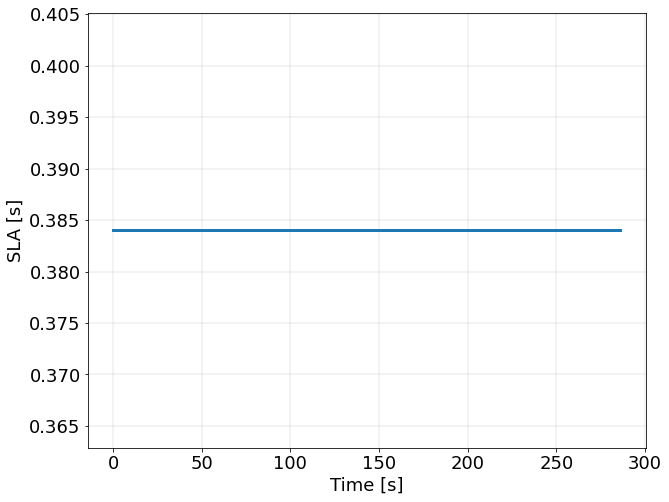

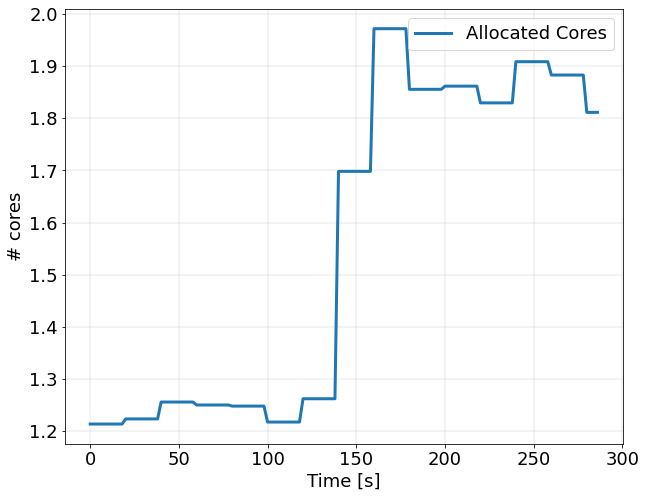

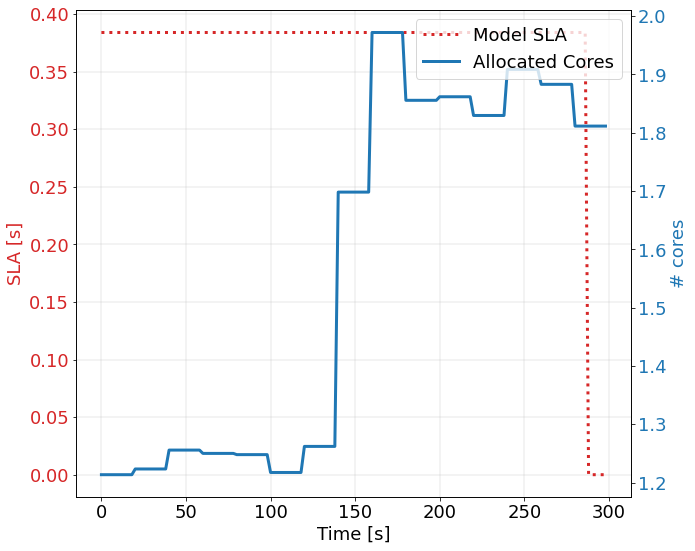

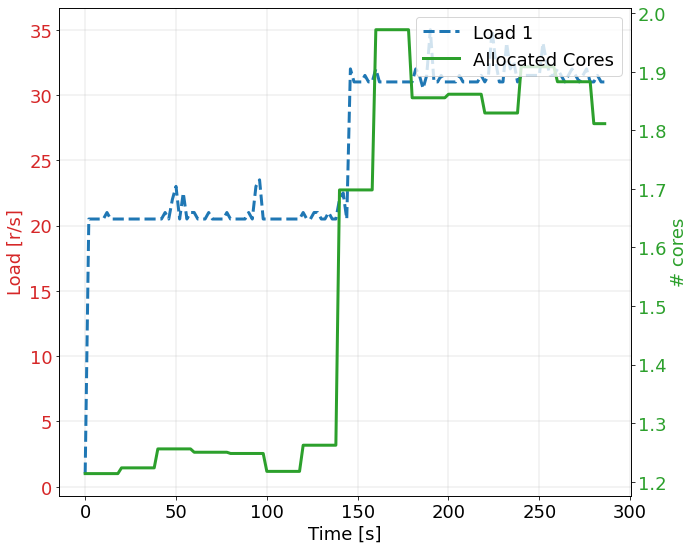

In [95]:
"""
print("----------- set point=0.25")
show_values(base_folder + "benchmark_skyline_extraction_small_025.out", 2, aggregate=10)
print("----------- set point=0.35")
show_values(base_folder + "benchmark_skyline_extraction_small_035.out", 2, aggregate=10)
"""
print(colored("1. control period=1s, tf=2.0.0, rounding=3, p_c=¼ rispetto originale, sla=1.2, d=300s", "red"))
show_values(base_folder + "benchmark_skyline_extraction_small_p4.out", 2, aggregate=10, sla=1.2)

# App
- control, control_period = 3s
- rules, control_period = 15s

### Skyline + GooLeNet
- default controller parameters (b_c = 0.21, d_c = 0.17)

complete/control/new/h1/1/
++++++ AGGREGATED
---------------- Skyline
RT: avg: 0.1721, max: 0.2035, std: 0.0196

Violations: 0 - 0.00%

Container ddc9887c279f23d421966bea799e5a1fa5cc4574f24af325da34420725419ec8:
active: 174.00, total: 348.00

Container 201e90c5d501dcbce202add51df82eec3fa6771db7cd60647e99934c1c102dd6:
active: 174.35, total: 348.70

---------------- GoogLeNet
RT: avg: 0.1650, max: 0.2455, std: 0.0426

Violations: 0 - 0.00%

Container ea5ef811333af1b031b8f206d0208b7b6ae64a94f6fd85b925e01ec859542291:
active: 199.97, total: 399.95

Container ebe70259b766911e0fc4870750daac4b79055d9149af75b99675b05577a8ac95:
active: 201.60, total: 403.20

++++++ AGGREGATED


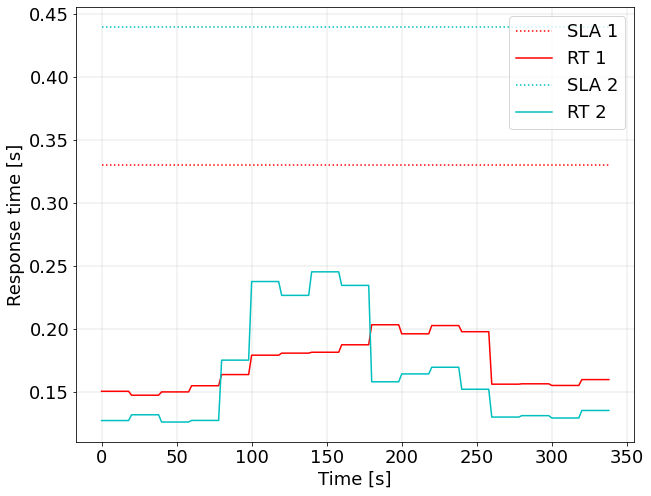

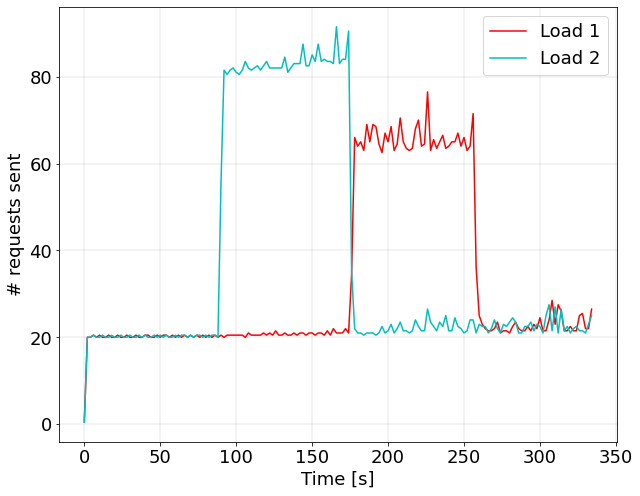

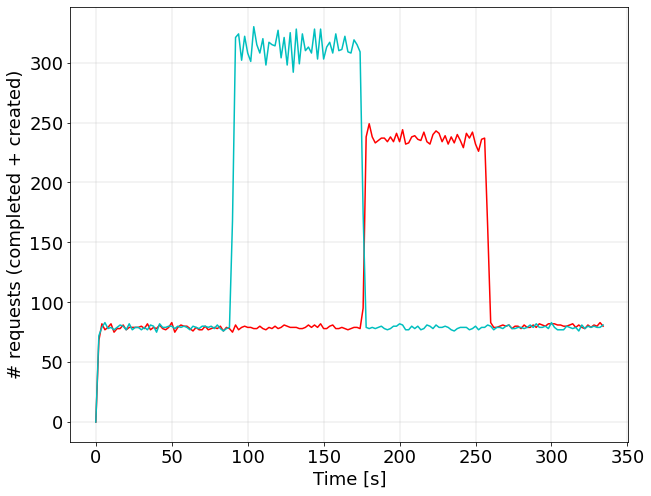

++++++ NOT AGGREGATED


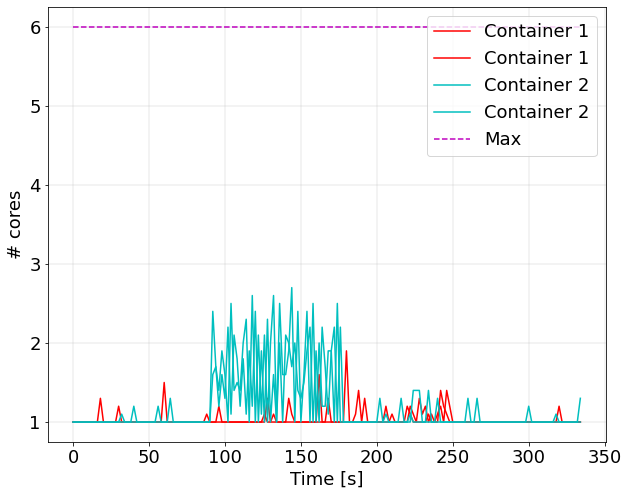

complete/control/new/rr/1/
++++++ AGGREGATED
---------------- Skyline
RT: avg: 0.1838, max: 0.2309, std: 0.0284

Violations: 0 - 0.00%

Container ddc9887c279f23d421966bea799e5a1fa5cc4574f24af325da34420725419ec8:
active: 180.82, total: 361.64

Container 201e90c5d501dcbce202add51df82eec3fa6771db7cd60647e99934c1c102dd6:
active: 180.41, total: 360.82

---------------- GoogLeNet
RT: avg: 0.2037, max: 0.3581, std: 0.0782

Violations: 0 - 0.00%

Container ea5ef811333af1b031b8f206d0208b7b6ae64a94f6fd85b925e01ec859542291:
active: 213.40, total: 426.80

Container ebe70259b766911e0fc4870750daac4b79055d9149af75b99675b05577a8ac95:
active: 218.60, total: 437.20

++++++ AGGREGATED


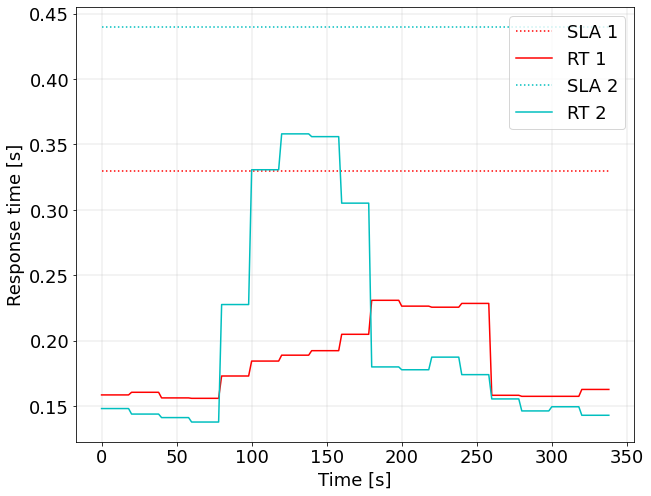

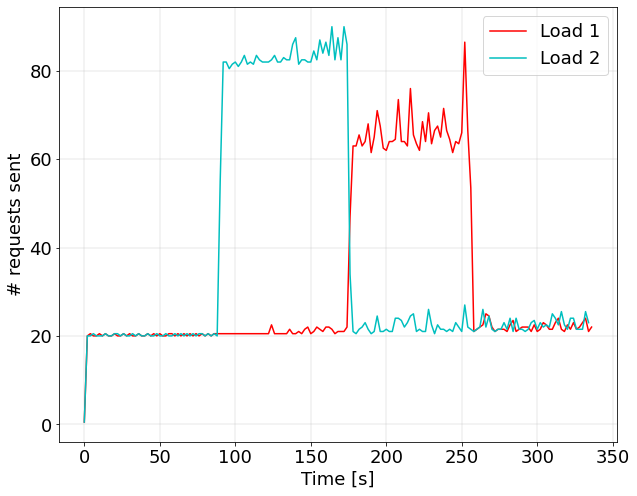

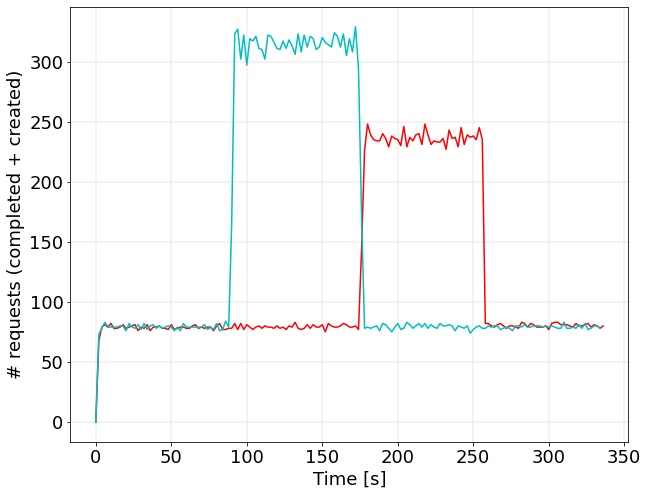

++++++ NOT AGGREGATED


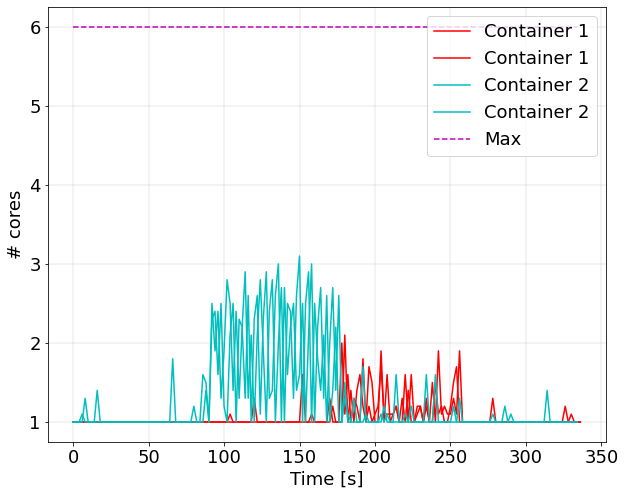

complete/no_control_max_cpu/new/rr/1/
++++++ AGGREGATED
---------------- Skyline
RT: avg: 0.1707, max: 0.1916, std: 0.0155

Violations: 0 - 0.00%

Container ddc9887c279f23d421966bea799e5a1fa5cc4574f24af325da34420725419ec8:
active: 1020.00, total: 2040.00

Container 201e90c5d501dcbce202add51df82eec3fa6771db7cd60647e99934c1c102dd6:
active: 1020.00, total: 2040.00

---------------- GoogLeNet
RT: avg: 0.1336, max: 0.1488, std: 0.0128

Violations: 0 - 0.00%

Container ea5ef811333af1b031b8f206d0208b7b6ae64a94f6fd85b925e01ec859542291:
active: 1080.00, total: 2160.00

Container ebe70259b766911e0fc4870750daac4b79055d9149af75b99675b05577a8ac95:
active: 1080.00, total: 2160.00

++++++ AGGREGATED


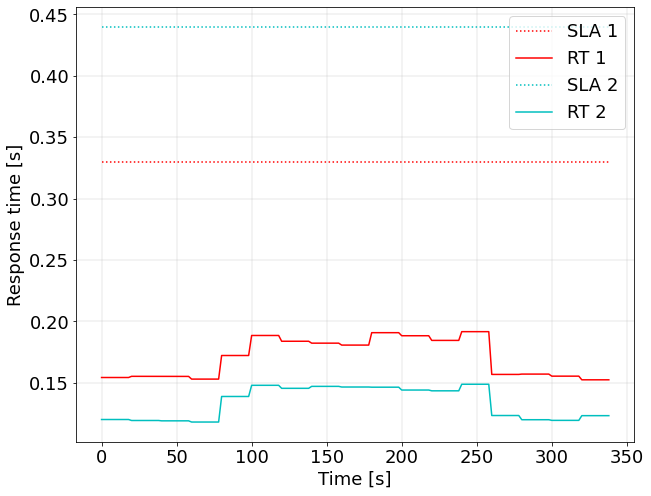

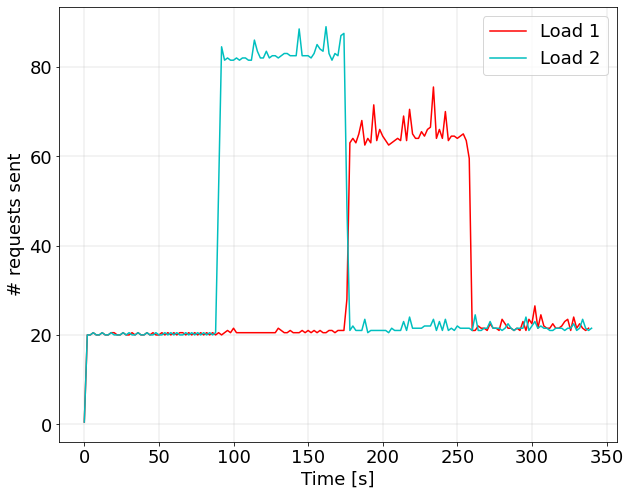

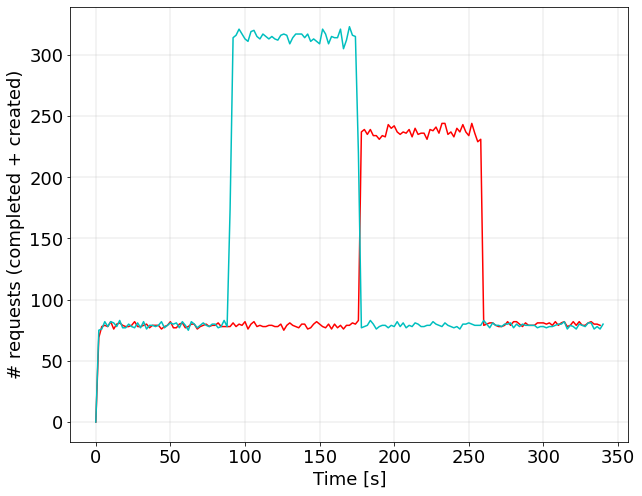

++++++ NOT AGGREGATED


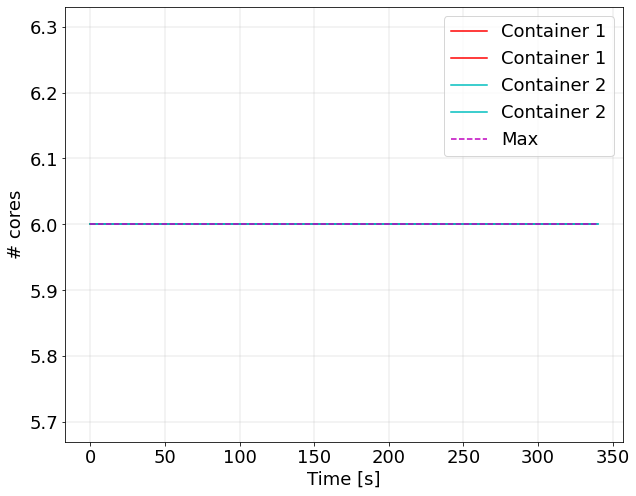

complete/no_control_min_cpu/new/rr/1/
++++++ AGGREGATED
---------------- Skyline
RT: avg: 0.1967, max: 0.3074, std: 0.0543

Violations: 0 - 0.00%

Container ddc9887c279f23d421966bea799e5a1fa5cc4574f24af325da34420725419ec8:
active: 180.00, total: 360.00

Container 201e90c5d501dcbce202add51df82eec3fa6771db7cd60647e99934c1c102dd6:
active: 180.00, total: 360.00

---------------- GoogLeNet
RT: avg: 0.3594, max: 1.0539, std: 0.3201

Violations: 40 - 23.53%

Container ea5ef811333af1b031b8f206d0208b7b6ae64a94f6fd85b925e01ec859542291:
active: 180.00, total: 360.00

Container ebe70259b766911e0fc4870750daac4b79055d9149af75b99675b05577a8ac95:
active: 180.00, total: 360.00

++++++ AGGREGATED


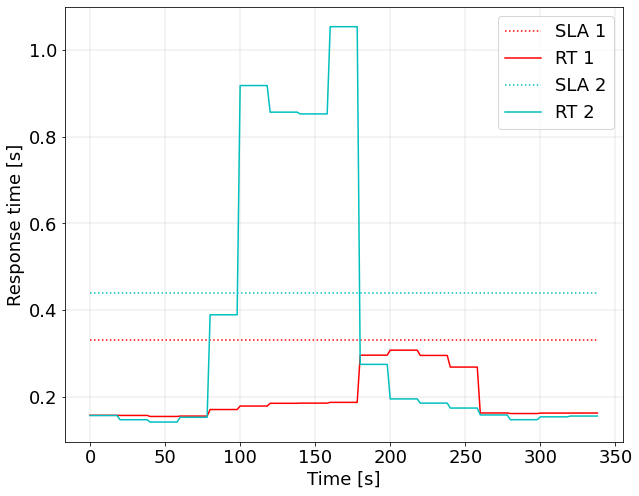

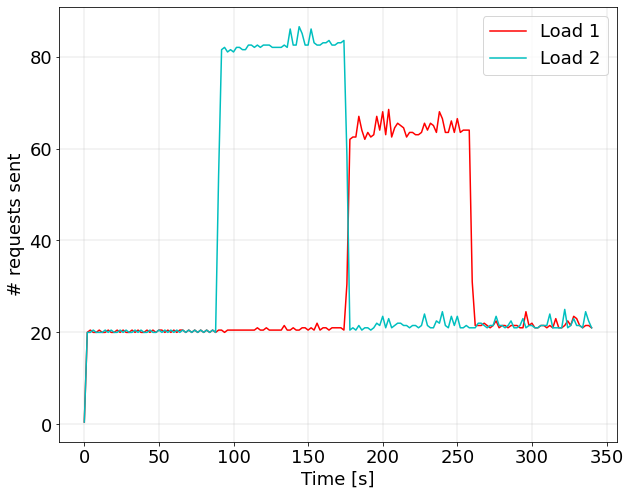

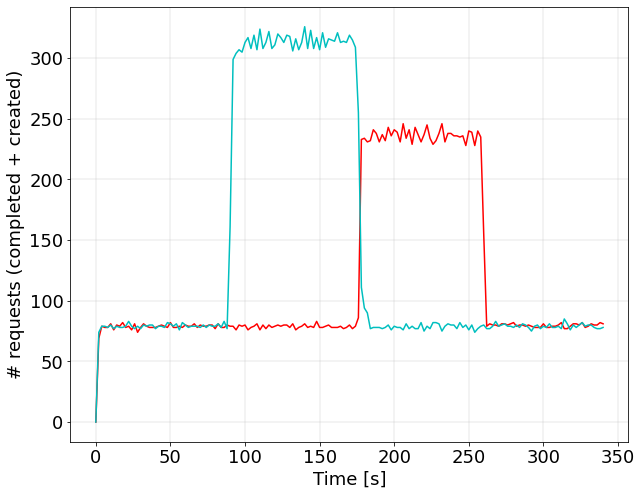

++++++ NOT AGGREGATED


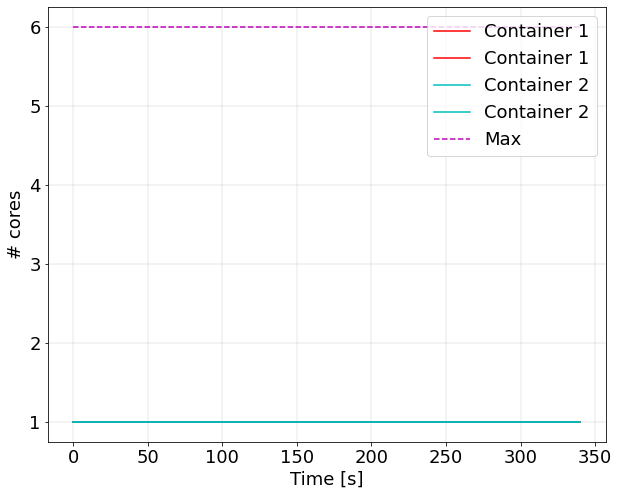

complete/rules/new/rr/1/
++++++ AGGREGATED
---------------- Skyline
RT: avg: 0.1750, max: 0.2358, std: 0.0232

Violations: 0 - 0.00%

Container ddc9887c279f23d421966bea799e5a1fa5cc4574f24af325da34420725419ec8:
active: 284.00, total: 568.00

Container 201e90c5d501dcbce202add51df82eec3fa6771db7cd60647e99934c1c102dd6:
active: 277.00, total: 554.00

---------------- GoogLeNet
RT: avg: 0.1966, max: 0.6382, std: 0.1270

Violations: 10 - 5.56%

Container ea5ef811333af1b031b8f206d0208b7b6ae64a94f6fd85b925e01ec859542291:
active: 320.00, total: 640.00

Container ebe70259b766911e0fc4870750daac4b79055d9149af75b99675b05577a8ac95:
active: 320.00, total: 640.00

++++++ AGGREGATED


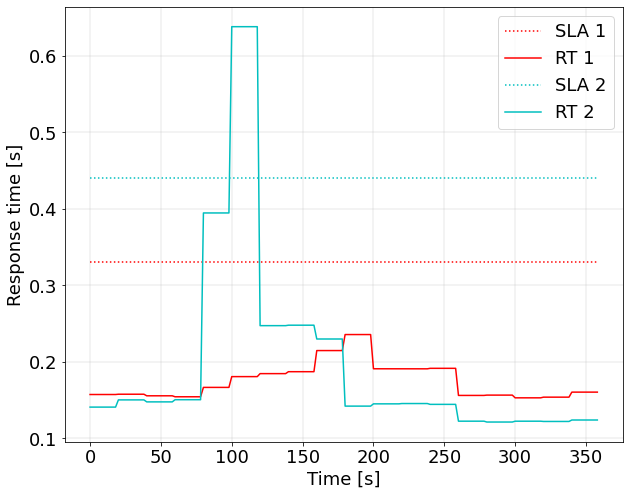

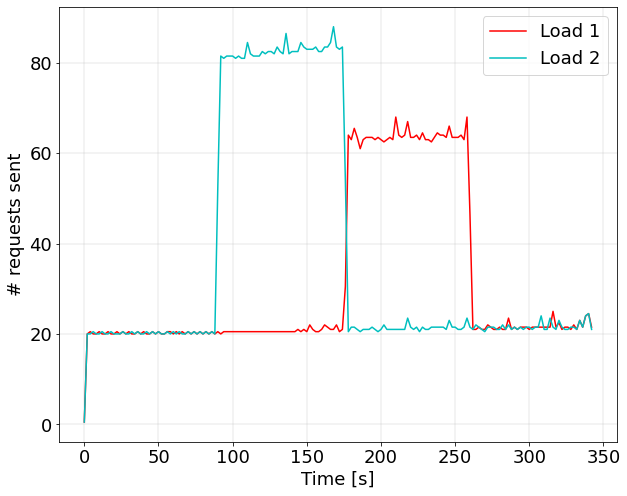

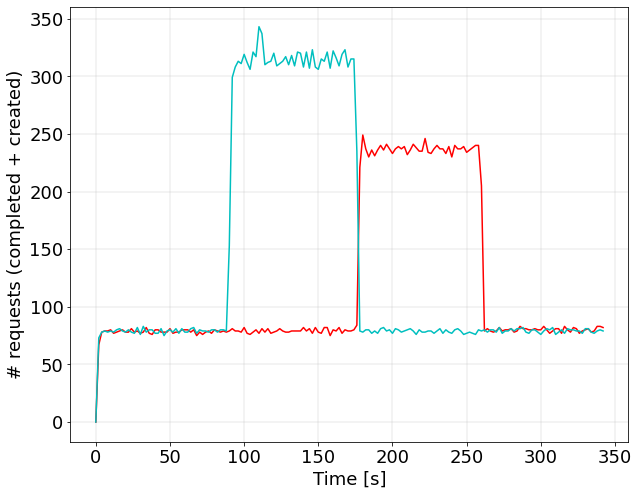

++++++ NOT AGGREGATED


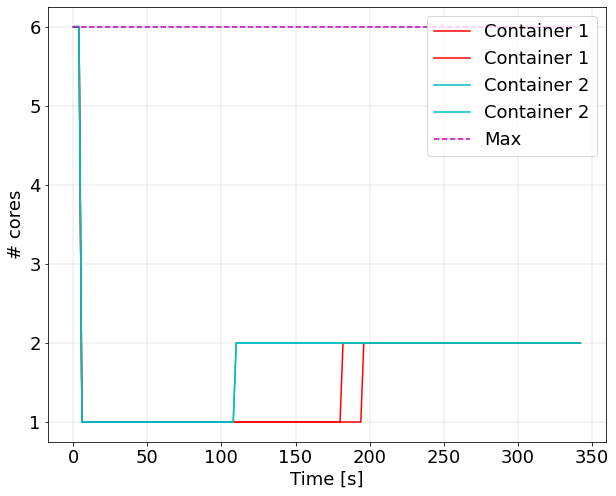

In [96]:
containers = ["ddc9887c279f23d421966bea799e5a1fa5cc4574f24af325da34420725419ec8",
              "201e90c5d501dcbce202add51df82eec3fa6771db7cd60647e99934c1c102dd6",
              "ea5ef811333af1b031b8f206d0208b7b6ae64a94f6fd85b925e01ec859542291",
              "ebe70259b766911e0fc4870750daac4b79055d9149af75b99675b05577a8ac95"]
output_folder = "plot_output/"

samples = 1
filename_1 = "benchmark_skyline_extraction.out"
filename_2 = "benchmark_googlenet.out"

base_folders = []
for sample in range(1,samples+1):
    base_folders.append("complete/control/new/h1/" + str(sample) + "/")
    base_folders.append("complete/control/new/rr/" + str(sample) + "/")
    base_folders.append("complete/no_control_max_cpu/new/rr/" + str(sample) + "/")
    base_folders.append("complete/no_control_min_cpu/new/rr/" + str(sample) + "/")
    base_folders.append("complete/rules/new/rr/" + str(sample) + "/")
    
base_folders.sort()

for base_folder in base_folders:
    print(base_folder)

    """
    print("---------------- Skyline")
    show_stats(base_folder + filename_1, 2)
    print("---------------- GoogLeNet")
    show_stats(base_folder + filename_2, 2)
    """

    print("++++++ AGGREGATED")
    print("---------------- Skyline")
    show_stats(base_folder + filename_1, 2, aggregate=10)
    print("---------------- GoogLeNet")
    show_stats(base_folder + filename_2, 2, aggregate=10)

    """
    plt_rt(1, base_folder + filename_1, 2, 'r')
    plt_rt(2, base_folder + filename_2, 2, 'c')
    plt.show()
    """

    print("++++++ AGGREGATED")
    plt_rt(1, base_folder + filename_1, 2, 'r', aggregate=10)
    plt_rt(2, base_folder + filename_2, 2, 'c', aggregate=10)
    #plt.savefig(output_folder + "rt_" + control.replace("/", "_") + "_" + strategy  + '.pdf', bbox_inches='tight')
    plt.show()

    plt_sent(1, base_folder + filename_1, 2, 'r')
    plt_sent(2, base_folder + filename_2, 2, 'c')
    #plt.savefig(output_folder + "sent_" + control.replace("/", "_") + "_" + strategy  + '.pdf', bbox_inches='tight')
    plt.show()

    plt_req(1, base_folder + filename_1, 2, 'r')
    plt_req(2, base_folder + filename_2, 2, 'c')
    #plt.savefig(output_folder + "req_" + control.replace("/", "_") + "_" + strategy  + '.pdf', bbox_inches='tight')
    plt.show()

    """
    plt_quota(1, base_folder + "benchmark_skyline_extraction.out",2, 'r', show_c=containers)
    plt_quota(2, base_folder + "benchmark_googlenet.out", 2, 'c', max_c=6, show_c=containers)
    plt.show()
    """

    print("++++++ NOT AGGREGATED")
    plt_quota(1, base_folder + filename_1, 2, 'r', show_c=containers, aggregate=False)
    plt_quota(2, base_folder + filename_2, 2, 'c', max_c=6, show_c=containers, aggregate=False)
    #plt.savefig(output_folder + "quota_" + control.replace("/", "_") + "_" + strategy  + '.pdf', bbox_inches='tight')
    plt.show()

### Resnet + Vgg16
- default controller parameters (b_c = 0.21, d_c = 0.17)

complete/control/hyst/h1/1/
++++++ AGGREGATED
---------------- Resnet
RT: avg: 0.1795, max: 0.2404, std: 0.0324

Violations: 0 - 0.00%

Container 9adc1001c5e0deb9248a4aa1cbd58ab901de8d60fc684d9dbe7f3ae9b73d7a0a:
active: 261.40, total: 522.80

Container 442b1fb6f0c17b4962b58598513f2b9817a3ce25fad040b7087198cf6895e3f8:
active: 264.73, total: 529.47

---------------- Vgg16
RT: avg: 0.3530, max: 0.5530, std: 0.1036

Violations: 10 - 5.56%

Container 4b9135318818a5dcf0f32e4a934845fa5a5f7189ba249bad7e5dea0bcc24989c:
active: 551.20, total: 1102.40

Container 499b2807892527832a22ab6883cb1aecb112ce461db33ea877716a622b40c26a:
active: 559.30, total: 1118.60

++++++ AGGREGATED


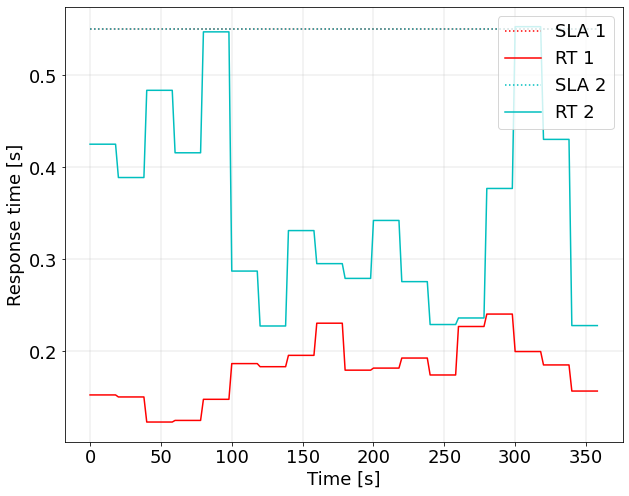

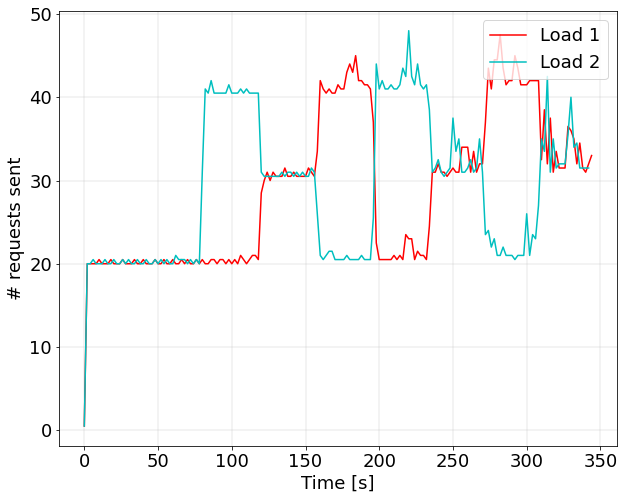

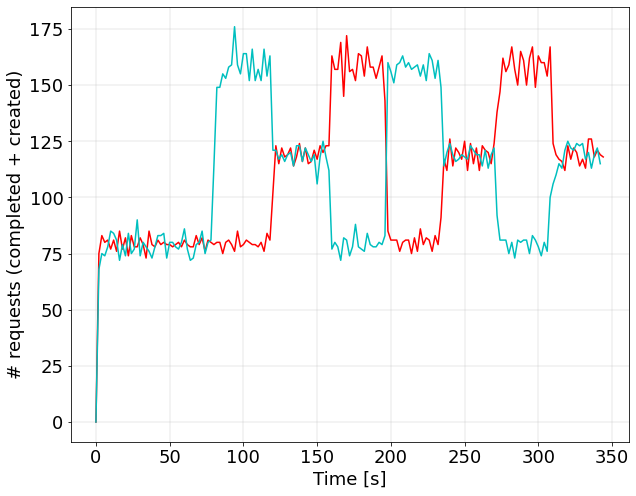

++++++ NOT AGGREGATED


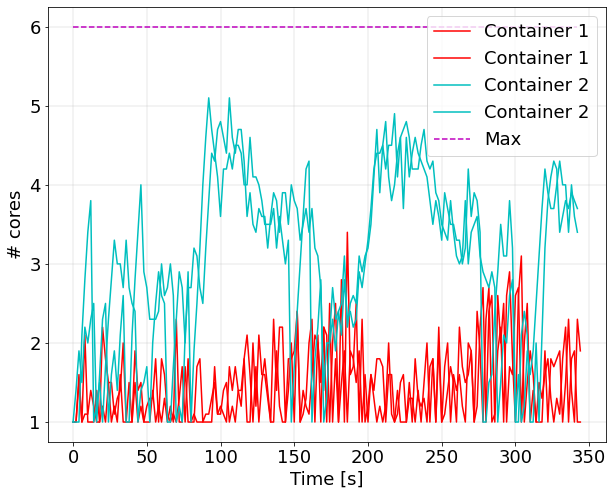

complete/control/hyst/h1/2/
++++++ AGGREGATED
---------------- Resnet
RT: avg: 0.1751, max: 0.2192, std: 0.0335

Violations: 0 - 0.00%

Container 9adc1001c5e0deb9248a4aa1cbd58ab901de8d60fc684d9dbe7f3ae9b73d7a0a:
active: 247.50, total: 495.00

Container 442b1fb6f0c17b4962b58598513f2b9817a3ce25fad040b7087198cf6895e3f8:
active: 262.30, total: 524.60

---------------- Vgg16
RT: avg: 0.3758, max: 0.7367, std: 0.1472

Violations: 30 - 16.67%

Container 4b9135318818a5dcf0f32e4a934845fa5a5f7189ba249bad7e5dea0bcc24989c:
active: 596.95, total: 1193.90

Container 499b2807892527832a22ab6883cb1aecb112ce461db33ea877716a622b40c26a:
active: 625.80, total: 1251.60

++++++ AGGREGATED


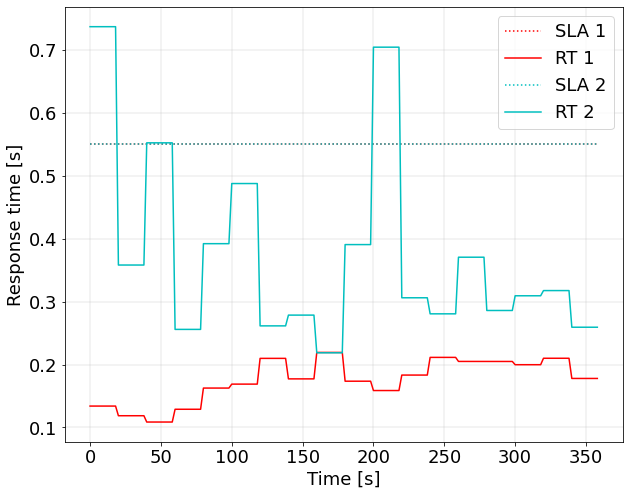

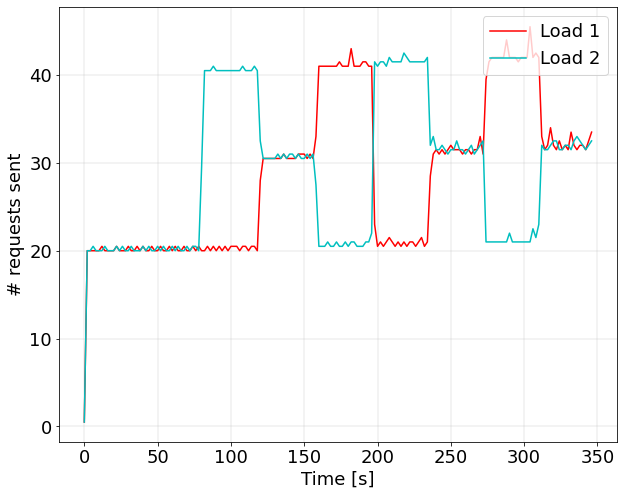

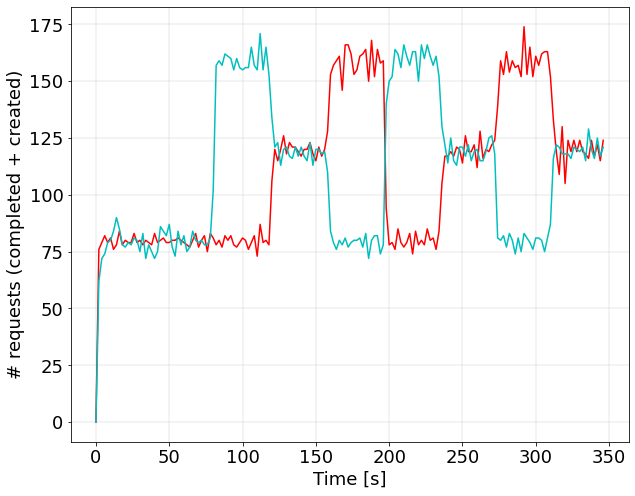

++++++ NOT AGGREGATED


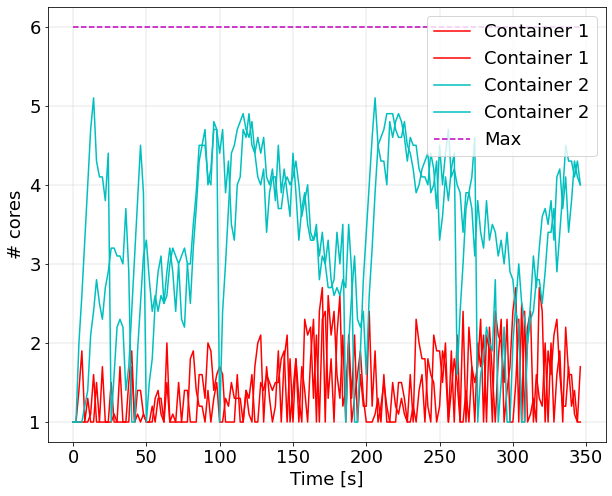

complete/control/hyst/h1/3/
++++++ AGGREGATED
---------------- Resnet
RT: avg: 0.1935, max: 0.2699, std: 0.0485

Violations: 0 - 0.00%

Container 9adc1001c5e0deb9248a4aa1cbd58ab901de8d60fc684d9dbe7f3ae9b73d7a0a:
active: 243.90, total: 487.80

Container 442b1fb6f0c17b4962b58598513f2b9817a3ce25fad040b7087198cf6895e3f8:
active: 280.50, total: 561.00

---------------- Vgg16
RT: avg: 0.3299, max: 0.4324, std: 0.0770

Violations: 0 - 0.00%

Container 4b9135318818a5dcf0f32e4a934845fa5a5f7189ba249bad7e5dea0bcc24989c:
active: 534.40, total: 1068.80

Container 499b2807892527832a22ab6883cb1aecb112ce461db33ea877716a622b40c26a:
active: 502.00, total: 1004.00

++++++ AGGREGATED


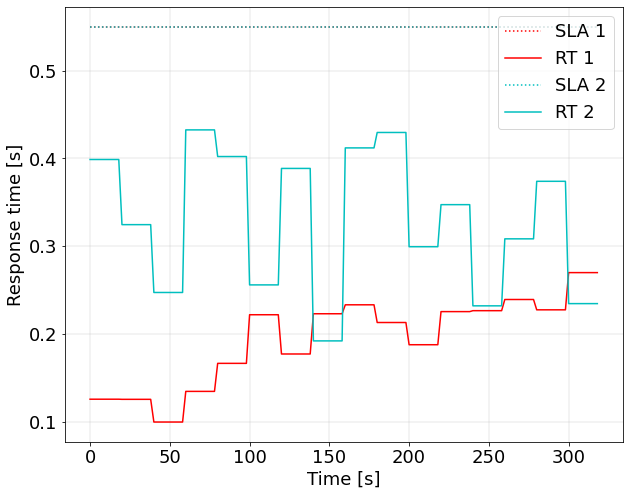

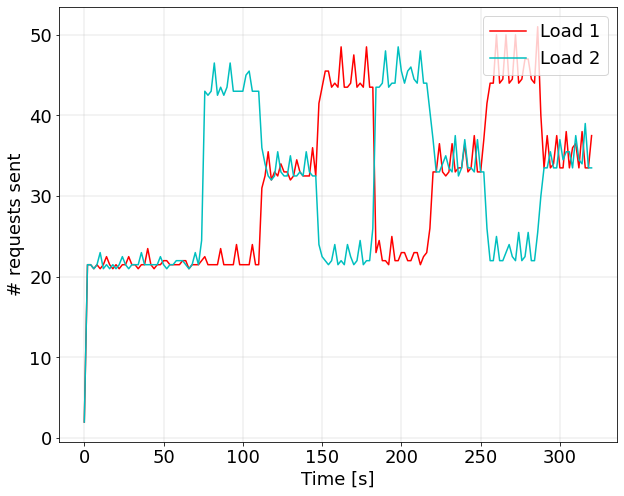

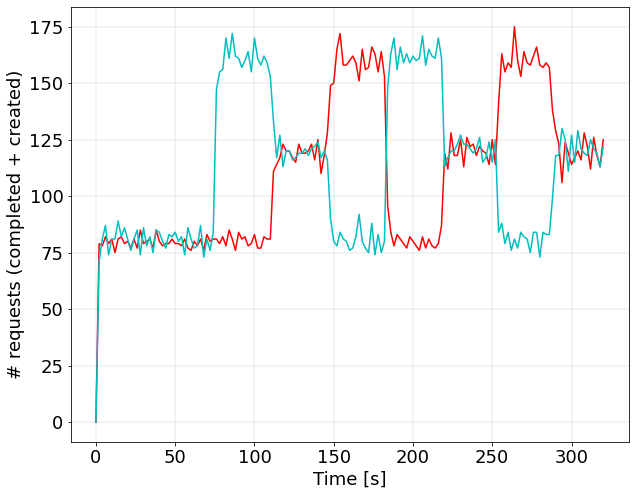

++++++ NOT AGGREGATED


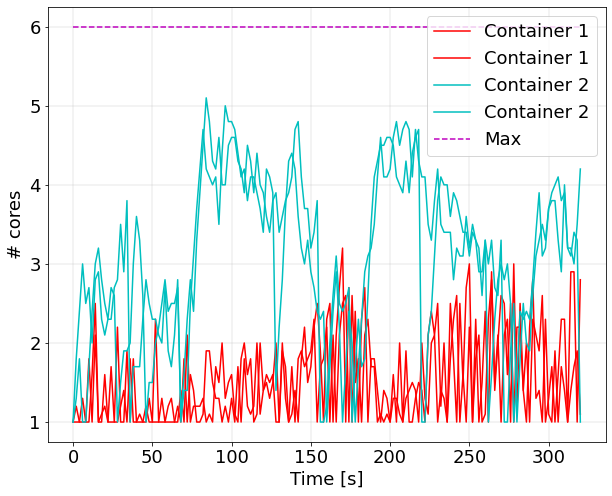

complete/control/hyst/rr/1/
++++++ AGGREGATED
---------------- Resnet
RT: avg: 0.2993, max: 0.3762, std: 0.0436

Violations: 0 - 0.00%

Container 9adc1001c5e0deb9248a4aa1cbd58ab901de8d60fc684d9dbe7f3ae9b73d7a0a:
active: 267.97, total: 535.94

Container 442b1fb6f0c17b4962b58598513f2b9817a3ce25fad040b7087198cf6895e3f8:
active: 281.21, total: 562.43

---------------- Vgg16
RT: avg: 0.5934, max: 0.9493, std: 0.1909

Violations: 70 - 43.75%

Container 4b9135318818a5dcf0f32e4a934845fa5a5f7189ba249bad7e5dea0bcc24989c:
active: 590.07, total: 1180.15

Container 499b2807892527832a22ab6883cb1aecb112ce461db33ea877716a622b40c26a:
active: 610.97, total: 1221.95

++++++ AGGREGATED


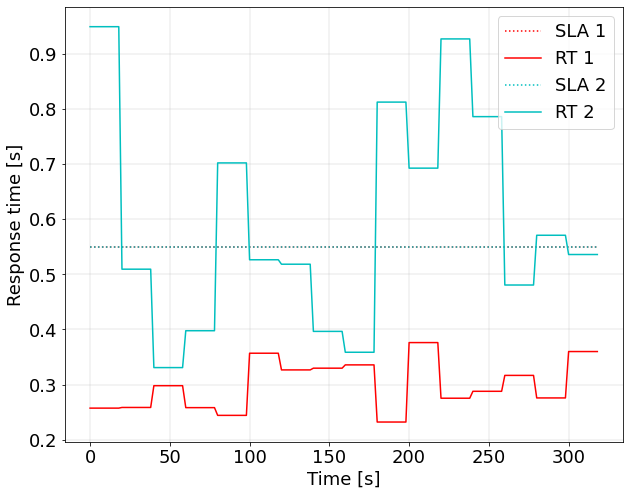

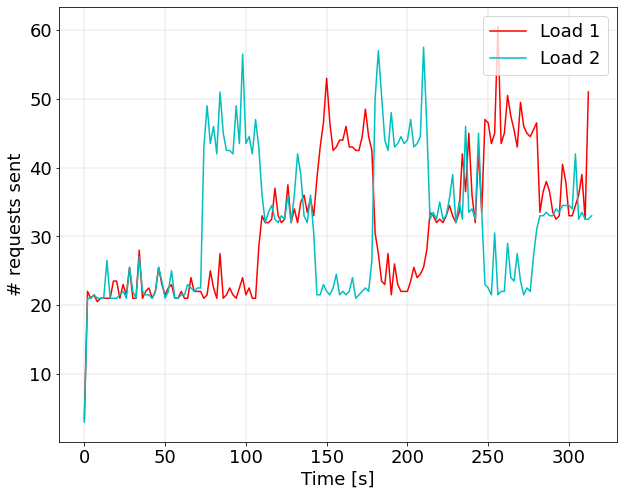

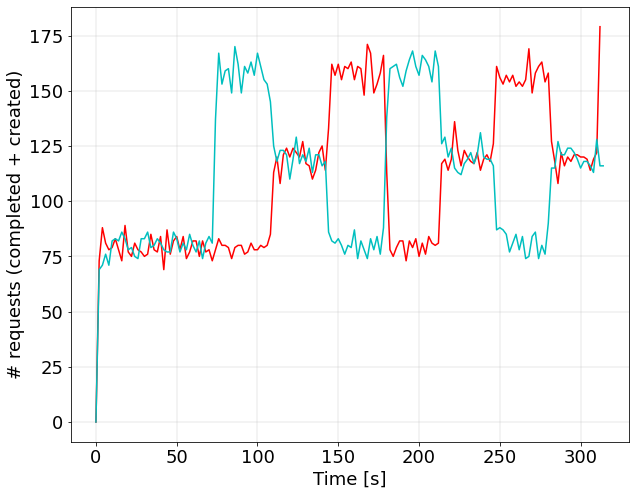

++++++ NOT AGGREGATED


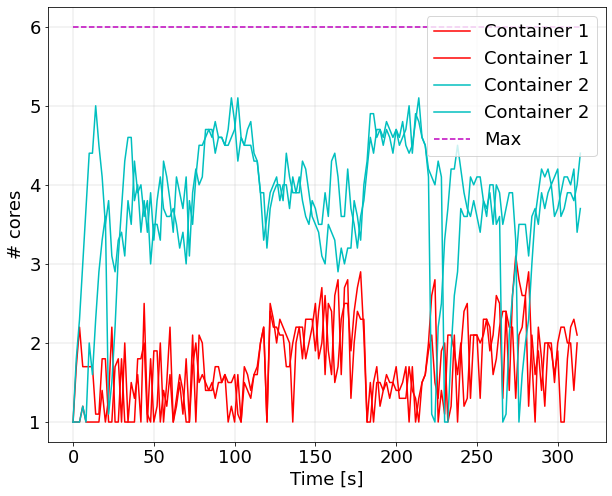

complete/control/hyst/rr/2/
++++++ AGGREGATED
---------------- Resnet
RT: avg: 0.2931, max: 0.4084, std: 0.0480

Violations: 0 - 0.00%

Container 9adc1001c5e0deb9248a4aa1cbd58ab901de8d60fc684d9dbe7f3ae9b73d7a0a:
active: 299.95, total: 599.90

Container 442b1fb6f0c17b4962b58598513f2b9817a3ce25fad040b7087198cf6895e3f8:
active: 311.55, total: 623.10

---------------- Vgg16
RT: avg: 0.5967, max: 1.1356, std: 0.1980

Violations: 80 - 44.44%

Container 4b9135318818a5dcf0f32e4a934845fa5a5f7189ba249bad7e5dea0bcc24989c:
active: 645.30, total: 1290.60

Container 499b2807892527832a22ab6883cb1aecb112ce461db33ea877716a622b40c26a:
active: 706.00, total: 1412.00

++++++ AGGREGATED


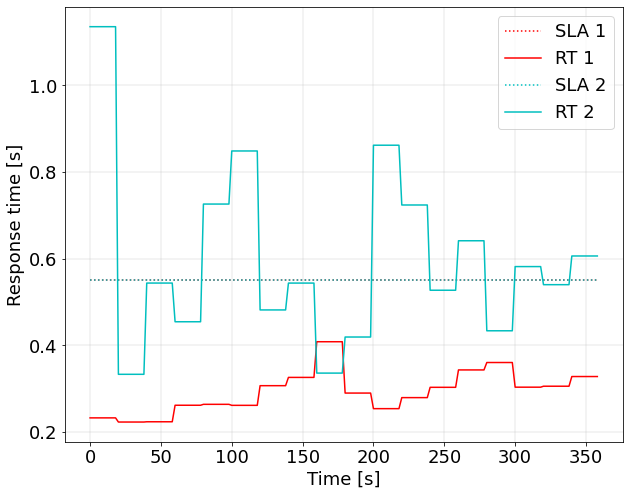

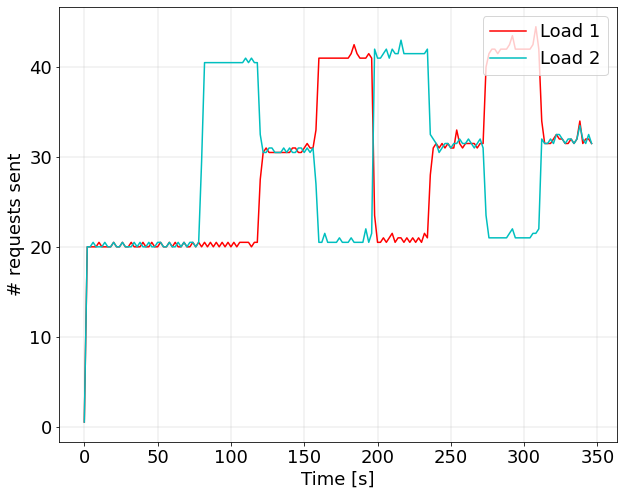

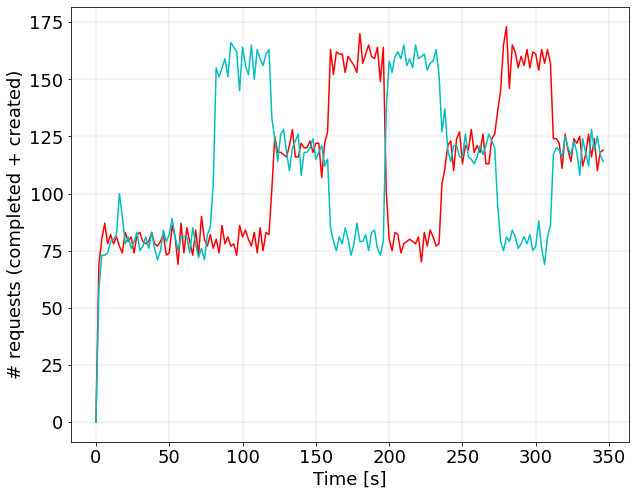

++++++ NOT AGGREGATED


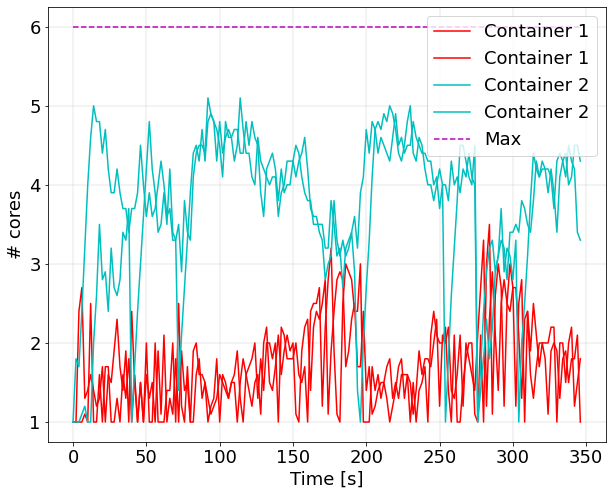

complete/control/hyst/rr/3/
++++++ AGGREGATED
---------------- Resnet
RT: avg: 0.3045, max: 0.4776, std: 0.0701

Violations: 0 - 0.00%

Container 9adc1001c5e0deb9248a4aa1cbd58ab901de8d60fc684d9dbe7f3ae9b73d7a0a:
active: 286.80, total: 573.60

Container 442b1fb6f0c17b4962b58598513f2b9817a3ce25fad040b7087198cf6895e3f8:
active: 291.10, total: 582.20

---------------- Vgg16
RT: avg: 0.5311, max: 0.8141, std: 0.1608

Violations: 70 - 43.75%

Container 4b9135318818a5dcf0f32e4a934845fa5a5f7189ba249bad7e5dea0bcc24989c:
active: 631.70, total: 1263.40

Container 499b2807892527832a22ab6883cb1aecb112ce461db33ea877716a622b40c26a:
active: 636.90, total: 1273.80

++++++ AGGREGATED


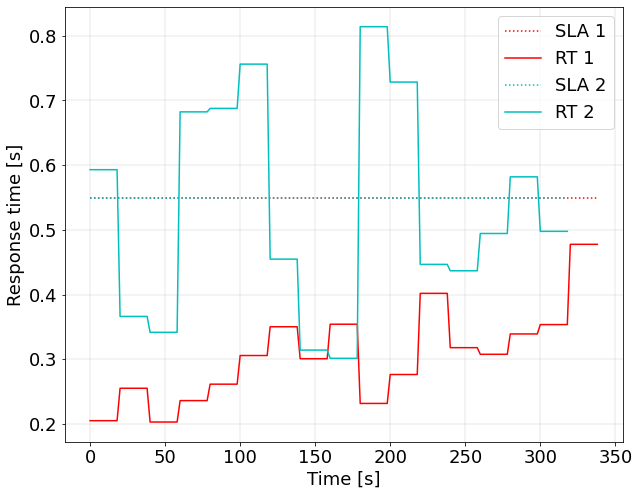

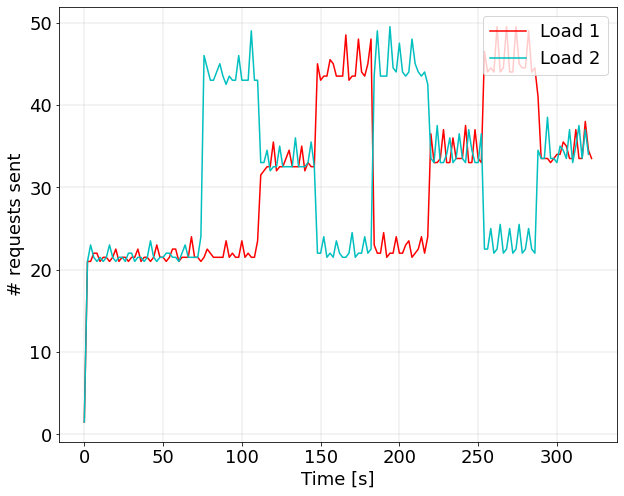

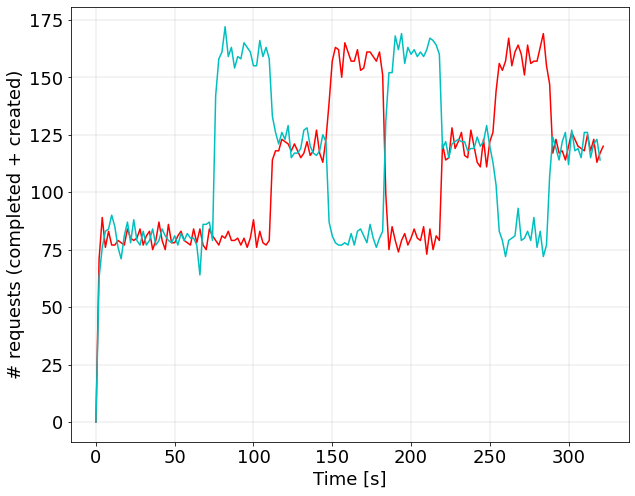

++++++ NOT AGGREGATED


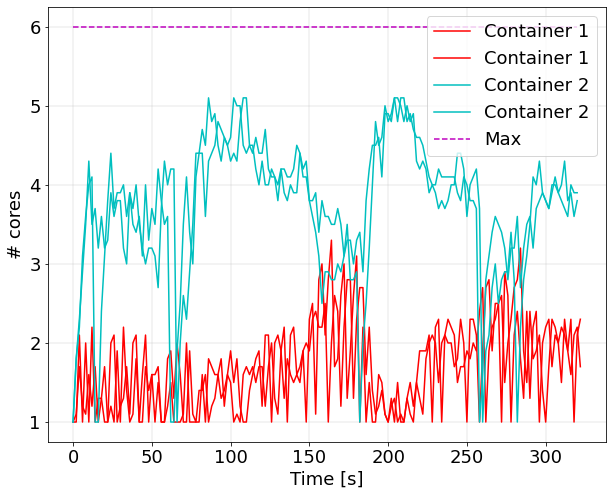

complete/no_control_max_cpu/hyst/rr/1/
++++++ AGGREGATED
---------------- Resnet
RT: avg: 0.2000, max: 0.2539, std: 0.0440

Violations: 0 - 0.00%

Container 9adc1001c5e0deb9248a4aa1cbd58ab901de8d60fc684d9dbe7f3ae9b73d7a0a:
active: 1080.00, total: 2160.00

Container 442b1fb6f0c17b4962b58598513f2b9817a3ce25fad040b7087198cf6895e3f8:
active: 1080.00, total: 2160.00

---------------- Vgg16
RT: avg: 0.4749, max: 0.6950, std: 0.1506

Violations: 60 - 33.33%

Container 4b9135318818a5dcf0f32e4a934845fa5a5f7189ba249bad7e5dea0bcc24989c:
active: 1080.00, total: 2160.00

Container 499b2807892527832a22ab6883cb1aecb112ce461db33ea877716a622b40c26a:
active: 1080.00, total: 2160.00

++++++ AGGREGATED


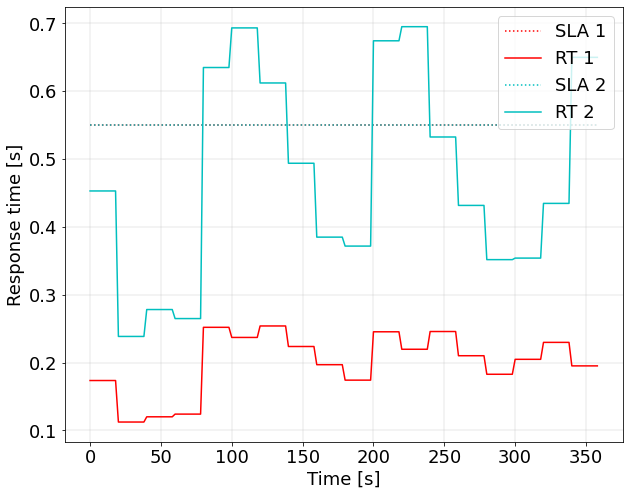

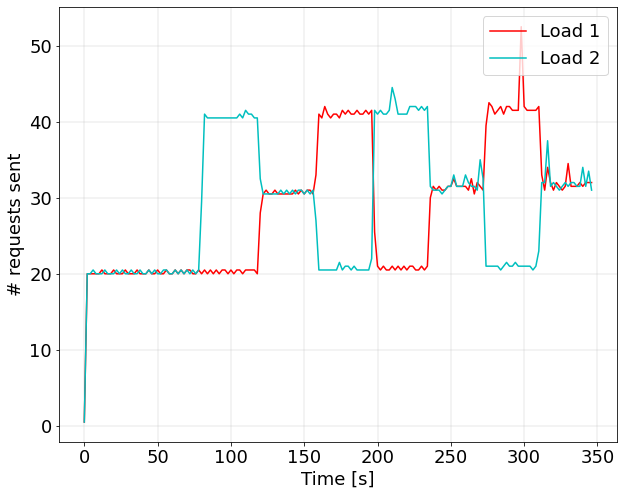

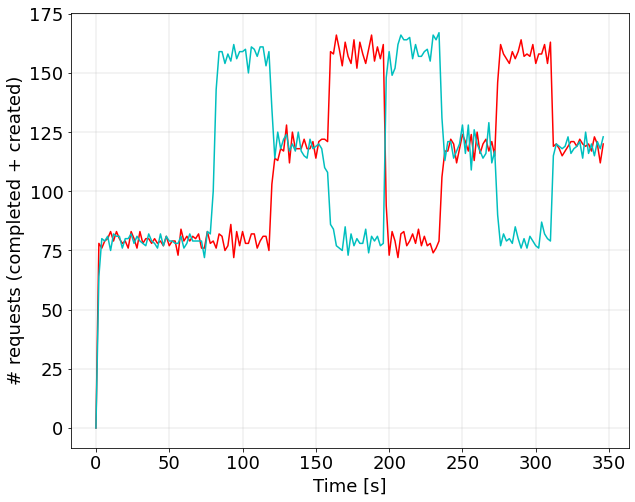

++++++ NOT AGGREGATED


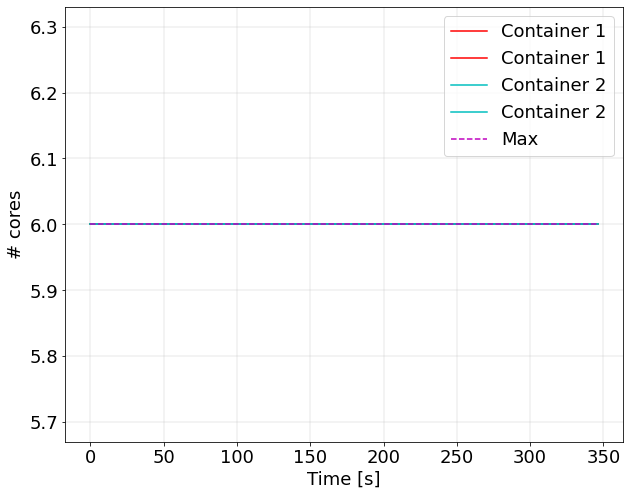

complete/no_control_max_cpu/hyst/rr/2/
++++++ AGGREGATED
---------------- Resnet
RT: avg: 0.1939, max: 0.2614, std: 0.0452

Violations: 0 - 0.00%

Container 9adc1001c5e0deb9248a4aa1cbd58ab901de8d60fc684d9dbe7f3ae9b73d7a0a:
active: 1080.00, total: 2160.00

Container 442b1fb6f0c17b4962b58598513f2b9817a3ce25fad040b7087198cf6895e3f8:
active: 1080.00, total: 2160.00

---------------- Vgg16
RT: avg: 0.4416, max: 0.7122, std: 0.1402

Violations: 40 - 22.22%

Container 4b9135318818a5dcf0f32e4a934845fa5a5f7189ba249bad7e5dea0bcc24989c:
active: 1080.00, total: 2160.00

Container 499b2807892527832a22ab6883cb1aecb112ce461db33ea877716a622b40c26a:
active: 1080.00, total: 2160.00

++++++ AGGREGATED


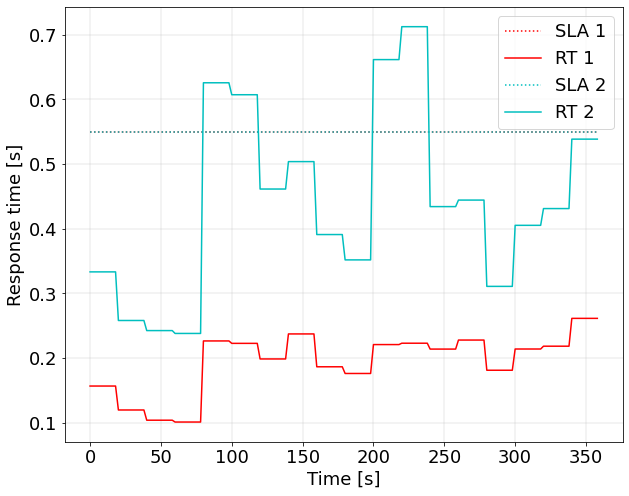

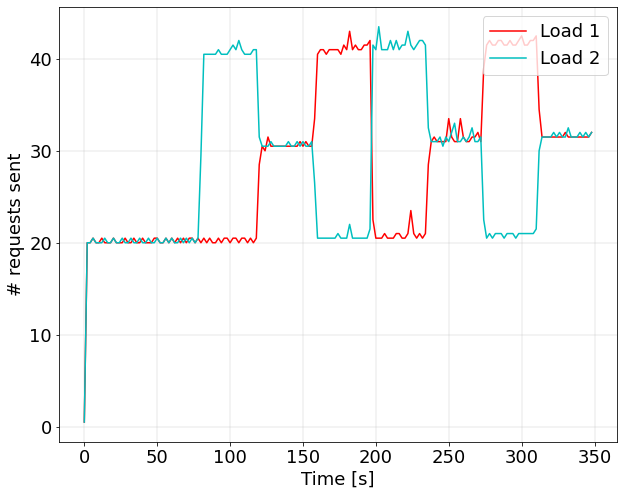

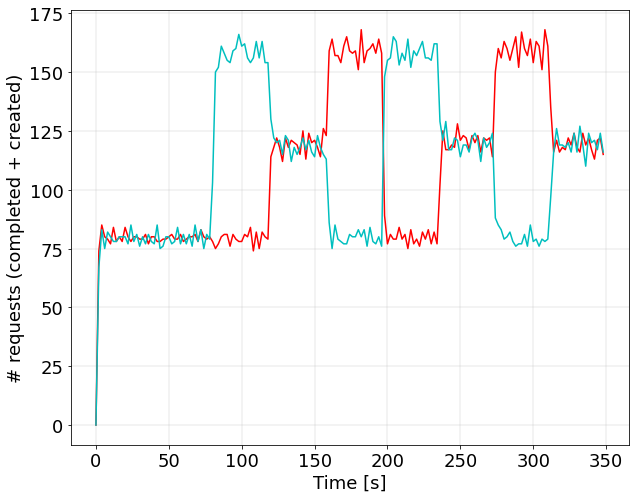

++++++ NOT AGGREGATED


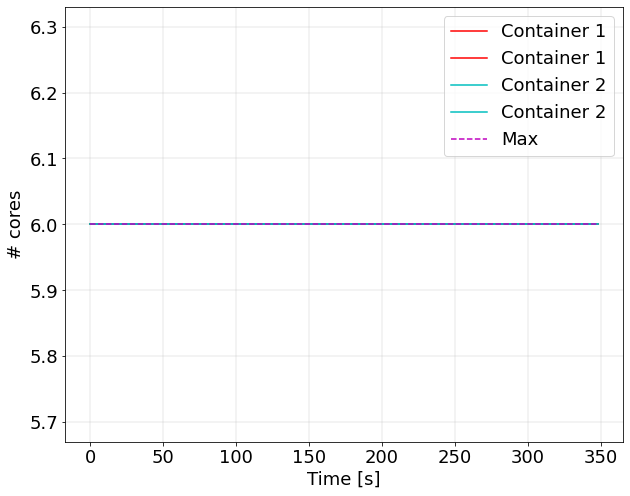

complete/no_control_max_cpu/hyst/rr/3/
++++++ AGGREGATED
---------------- Resnet
RT: avg: 0.1972, max: 0.3143, std: 0.0547

Violations: 0 - 0.00%

Container 9adc1001c5e0deb9248a4aa1cbd58ab901de8d60fc684d9dbe7f3ae9b73d7a0a:
active: 1080.00, total: 2160.00

Container 442b1fb6f0c17b4962b58598513f2b9817a3ce25fad040b7087198cf6895e3f8:
active: 1080.00, total: 2160.00

---------------- Vgg16
RT: avg: 0.4244, max: 0.6409, std: 0.1372

Violations: 30 - 16.67%

Container 4b9135318818a5dcf0f32e4a934845fa5a5f7189ba249bad7e5dea0bcc24989c:
active: 1080.00, total: 2160.00

Container 499b2807892527832a22ab6883cb1aecb112ce461db33ea877716a622b40c26a:
active: 1080.00, total: 2160.00

++++++ AGGREGATED


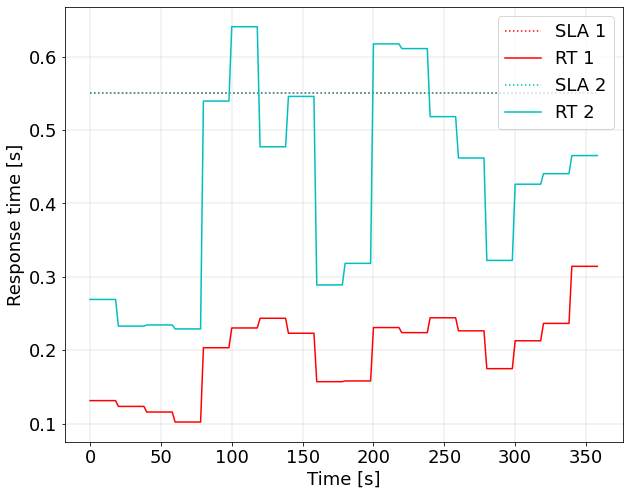

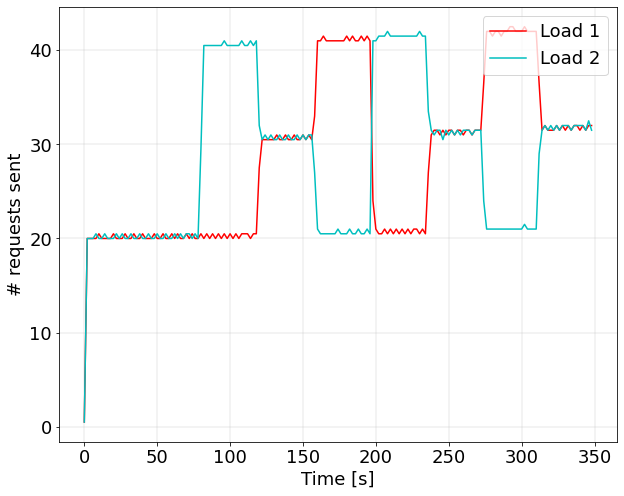

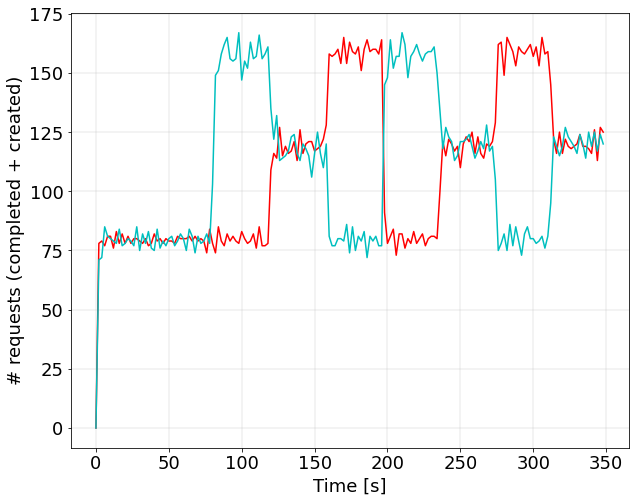

++++++ NOT AGGREGATED


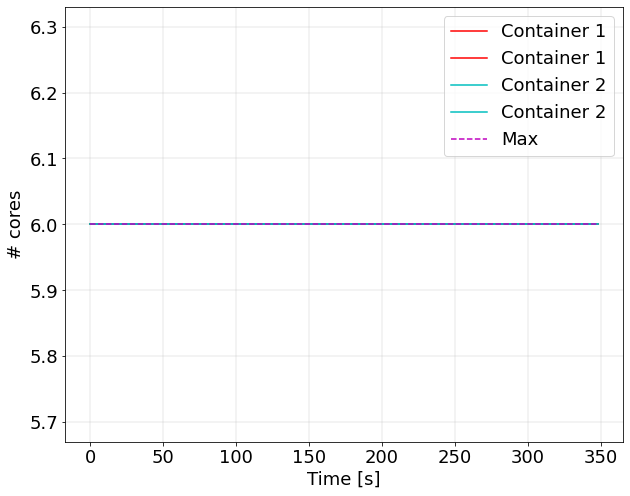

complete/no_control_min_cpu/hyst/rr/1/
++++++ AGGREGATED
---------------- Resnet
RT: avg: 0.1144, max: 0.1963, std: 0.0350

Violations: 0 - 0.00%

Container 9adc1001c5e0deb9248a4aa1cbd58ab901de8d60fc684d9dbe7f3ae9b73d7a0a:
active: 180.00, total: 360.00

Container 442b1fb6f0c17b4962b58598513f2b9817a3ce25fad040b7087198cf6895e3f8:
active: 180.00, total: 360.00

---------------- Vgg16
RT: avg: 2.9671, max: 4.4212, std: 0.8940

Violations: 180 - 100.00%

Container 4b9135318818a5dcf0f32e4a934845fa5a5f7189ba249bad7e5dea0bcc24989c:
active: 180.00, total: 360.00

Container 499b2807892527832a22ab6883cb1aecb112ce461db33ea877716a622b40c26a:
active: 180.00, total: 360.00

++++++ AGGREGATED


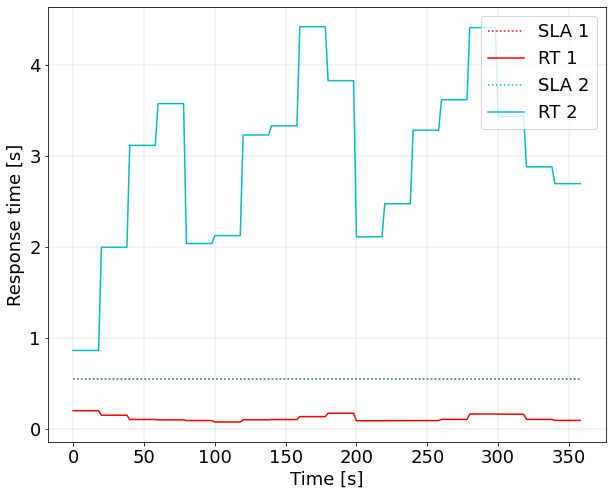

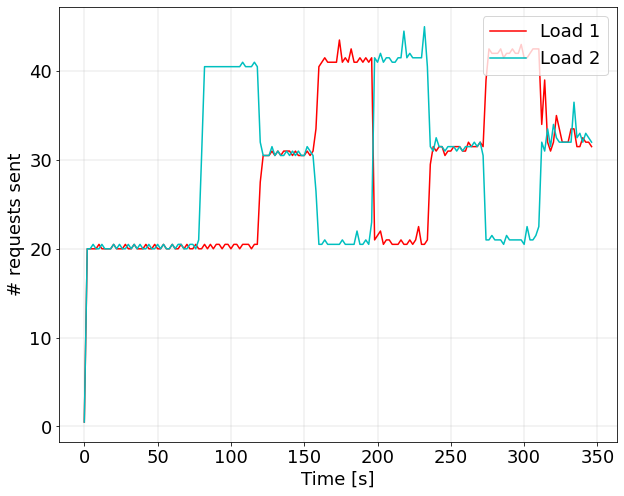

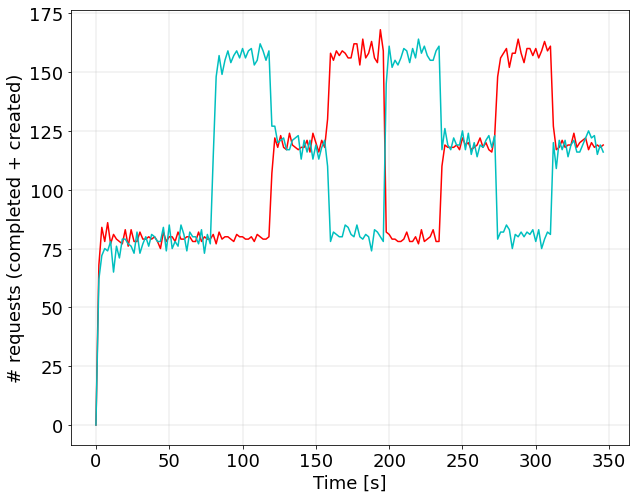

++++++ NOT AGGREGATED


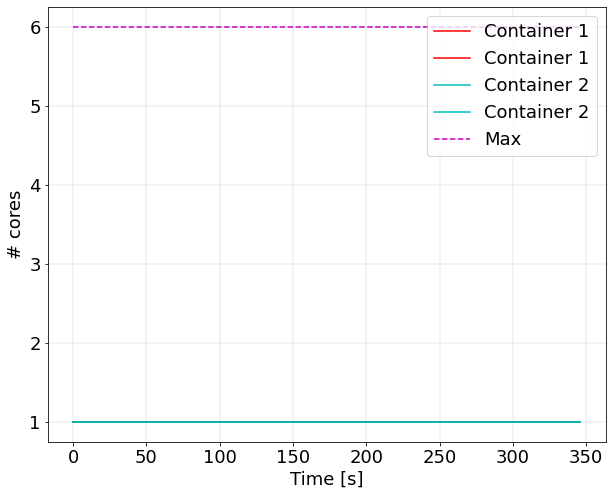

complete/no_control_min_cpu/hyst/rr/2/
++++++ AGGREGATED
---------------- Resnet
RT: avg: 0.1241, max: 0.4935, std: 0.0943

Violations: 0 - 0.00%

Container 9adc1001c5e0deb9248a4aa1cbd58ab901de8d60fc684d9dbe7f3ae9b73d7a0a:
active: 180.00, total: 360.00

Container 442b1fb6f0c17b4962b58598513f2b9817a3ce25fad040b7087198cf6895e3f8:
active: 180.00, total: 360.00

---------------- Vgg16
RT: avg: 2.9362, max: 4.3248, std: 0.9025

Violations: 180 - 100.00%

Container 4b9135318818a5dcf0f32e4a934845fa5a5f7189ba249bad7e5dea0bcc24989c:
active: 180.00, total: 360.00

Container 499b2807892527832a22ab6883cb1aecb112ce461db33ea877716a622b40c26a:
active: 180.00, total: 360.00

++++++ AGGREGATED


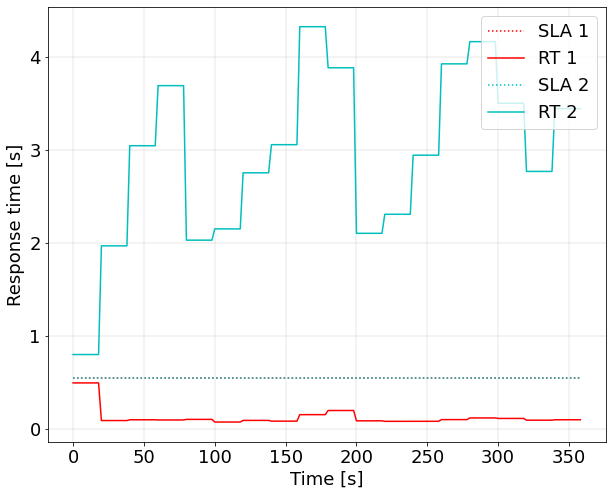

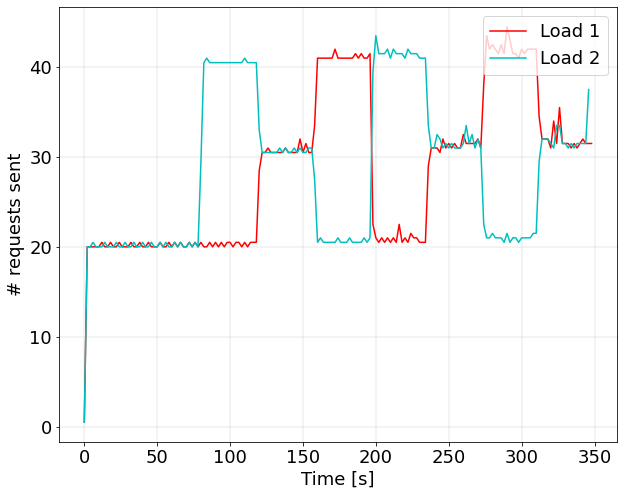

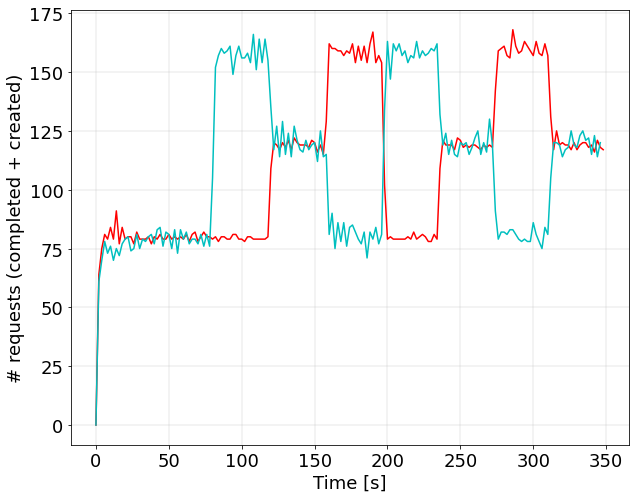

++++++ NOT AGGREGATED


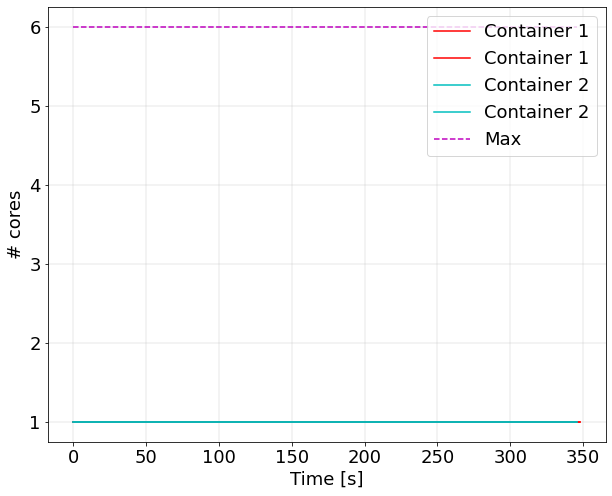

complete/no_control_min_cpu/hyst/rr/3/
++++++ AGGREGATED
---------------- Resnet
RT: avg: 0.1133, max: 0.2258, std: 0.0407

Violations: 0 - 0.00%

Container 9adc1001c5e0deb9248a4aa1cbd58ab901de8d60fc684d9dbe7f3ae9b73d7a0a:
active: 180.00, total: 360.00

Container 442b1fb6f0c17b4962b58598513f2b9817a3ce25fad040b7087198cf6895e3f8:
active: 180.00, total: 360.00

---------------- Vgg16
RT: avg: 2.8830, max: 4.5432, std: 0.9121

Violations: 180 - 100.00%

Container 4b9135318818a5dcf0f32e4a934845fa5a5f7189ba249bad7e5dea0bcc24989c:
active: 180.00, total: 360.00

Container 499b2807892527832a22ab6883cb1aecb112ce461db33ea877716a622b40c26a:
active: 180.00, total: 360.00

++++++ AGGREGATED


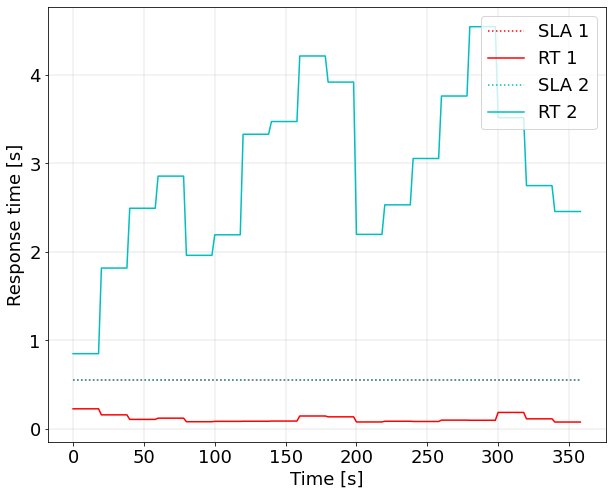

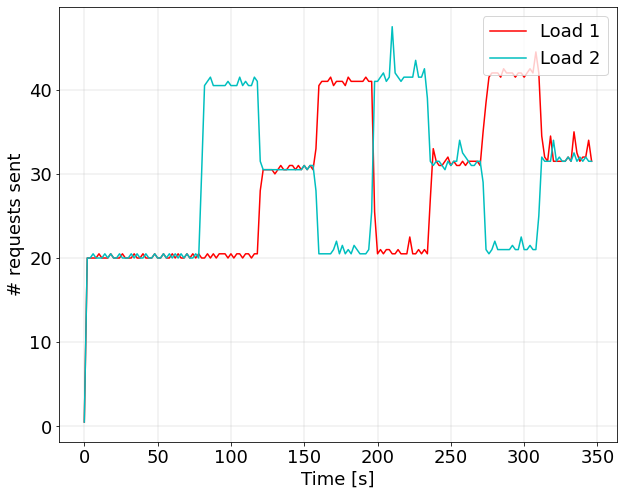

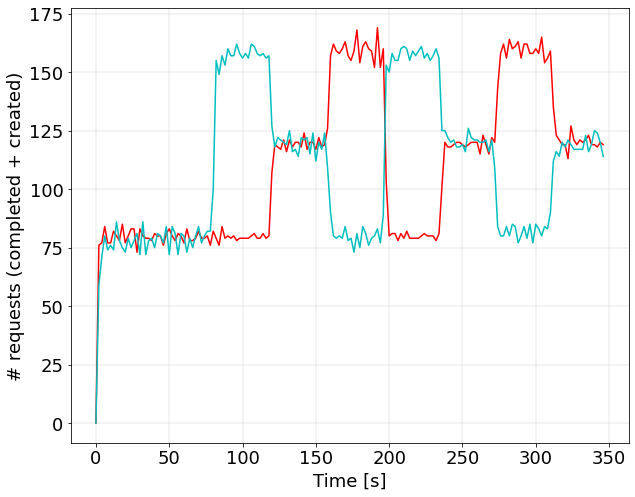

++++++ NOT AGGREGATED


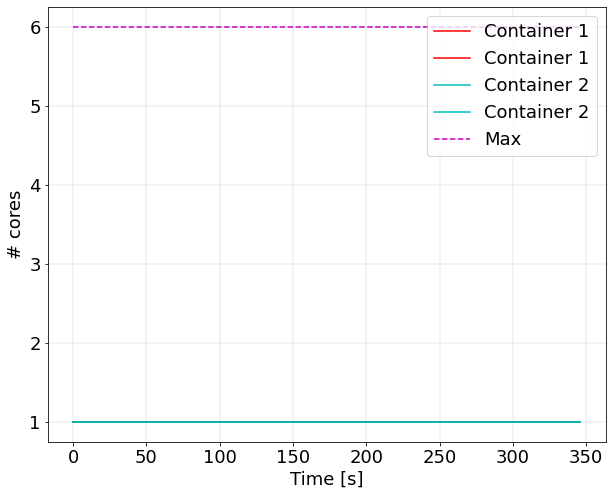

complete/rules/hyst/rr/1/
++++++ AGGREGATED
---------------- Resnet
RT: avg: 0.3043, max: 0.6031, std: 0.1443

Violations: 10 - 5.56%

Container 9adc1001c5e0deb9248a4aa1cbd58ab901de8d60fc684d9dbe7f3ae9b73d7a0a:
active: 273.60, total: 547.20

Container 442b1fb6f0c17b4962b58598513f2b9817a3ce25fad040b7087198cf6895e3f8:
active: 281.70, total: 563.40

---------------- Vgg16
RT: avg: 1.0995, max: 3.8297, std: 0.9131

Violations: 110 - 61.11%

Container 4b9135318818a5dcf0f32e4a934845fa5a5f7189ba249bad7e5dea0bcc24989c:
active: 561.90, total: 1123.80

Container 499b2807892527832a22ab6883cb1aecb112ce461db33ea877716a622b40c26a:
active: 575.50, total: 1151.00

++++++ AGGREGATED


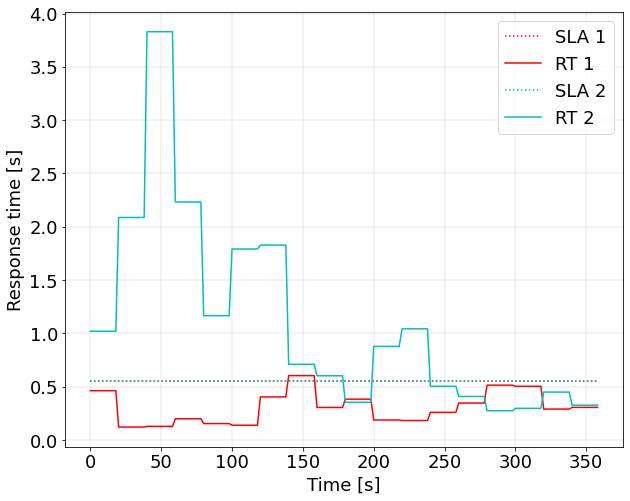

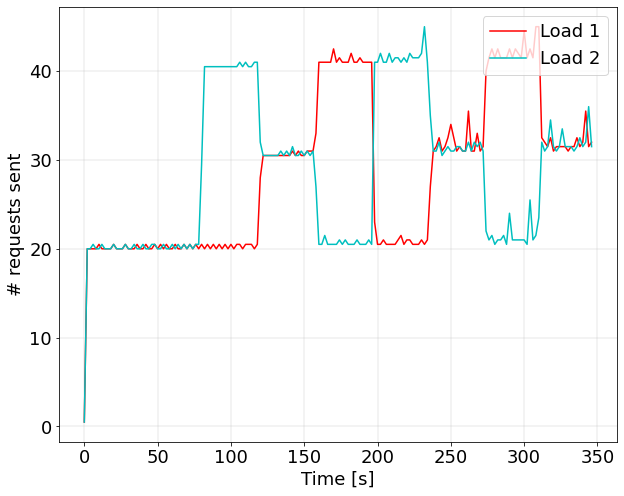

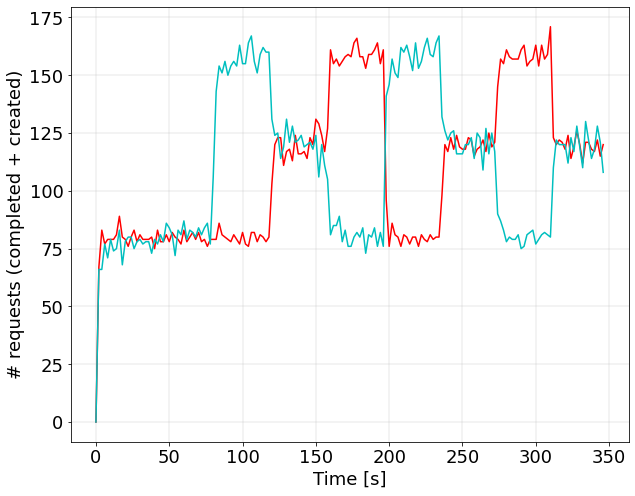

++++++ NOT AGGREGATED


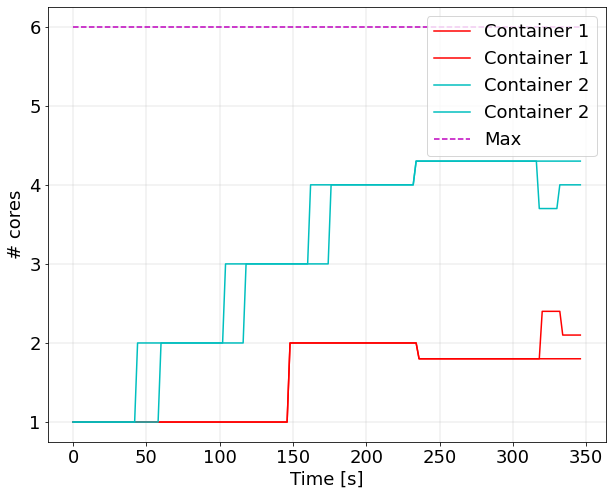

complete/rules/hyst/rr/2/
++++++ AGGREGATED
---------------- Resnet
RT: avg: 0.3335, max: 0.8587, std: 0.2180

Violations: 30 - 16.67%

Container 9adc1001c5e0deb9248a4aa1cbd58ab901de8d60fc684d9dbe7f3ae9b73d7a0a:
active: 262.80, total: 525.60

Container 442b1fb6f0c17b4962b58598513f2b9817a3ce25fad040b7087198cf6895e3f8:
active: 274.40, total: 548.80

---------------- Vgg16
RT: avg: 1.1418, max: 2.8919, std: 0.8333

Violations: 120 - 66.67%

Container 4b9135318818a5dcf0f32e4a934845fa5a5f7189ba249bad7e5dea0bcc24989c:
active: 546.30, total: 1092.60

Container 499b2807892527832a22ab6883cb1aecb112ce461db33ea877716a622b40c26a:
active: 603.80, total: 1207.60

++++++ AGGREGATED


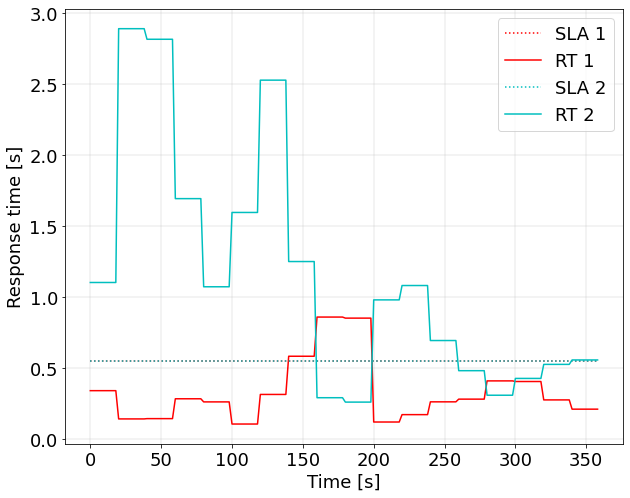

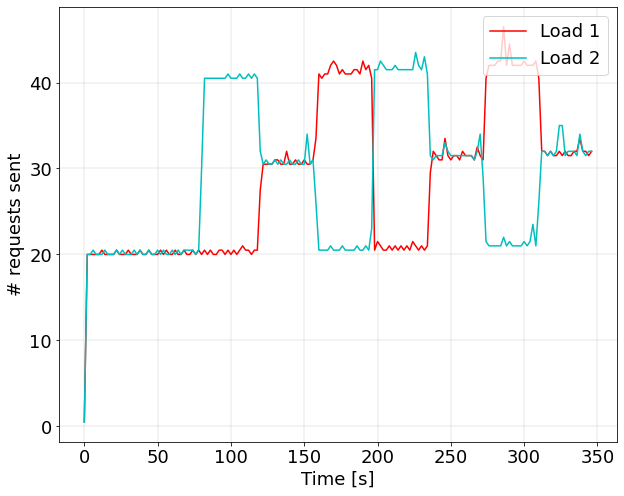

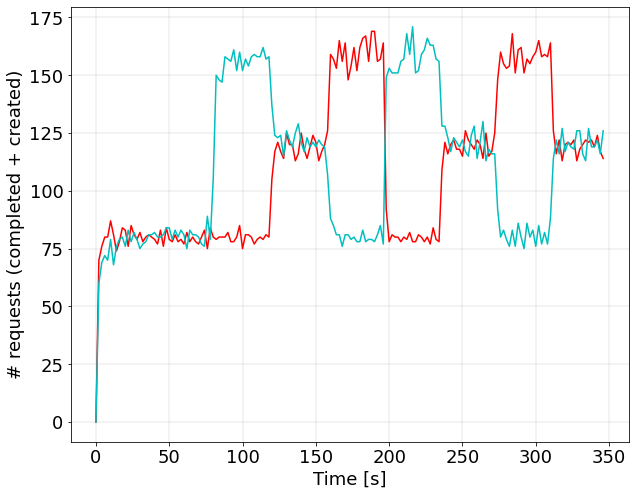

++++++ NOT AGGREGATED


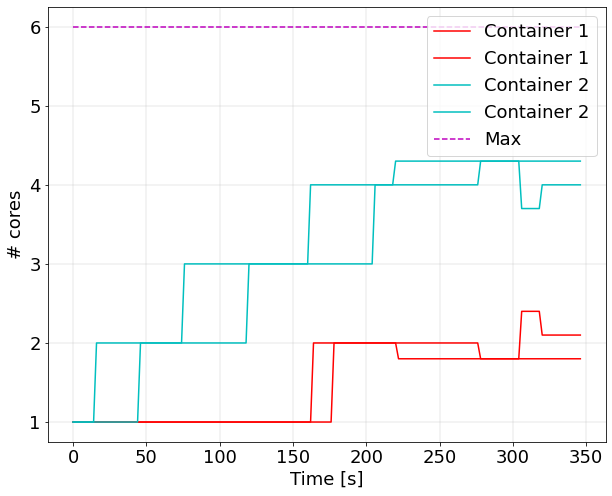

complete/rules/hyst/rr/3/
++++++ AGGREGATED
---------------- Resnet
RT: avg: 0.3173, max: 0.9191, std: 0.2201

Violations: 30 - 16.67%

Container 9adc1001c5e0deb9248a4aa1cbd58ab901de8d60fc684d9dbe7f3ae9b73d7a0a:
active: 288.20, total: 576.40

Container 442b1fb6f0c17b4962b58598513f2b9817a3ce25fad040b7087198cf6895e3f8:
active: 309.40, total: 618.80

---------------- Vgg16
RT: avg: 1.1016, max: 3.4479, std: 0.8989

Violations: 120 - 66.67%

Container 4b9135318818a5dcf0f32e4a934845fa5a5f7189ba249bad7e5dea0bcc24989c:
active: 538.00, total: 1076.00

Container 499b2807892527832a22ab6883cb1aecb112ce461db33ea877716a622b40c26a:
active: 558.00, total: 1116.00

++++++ AGGREGATED


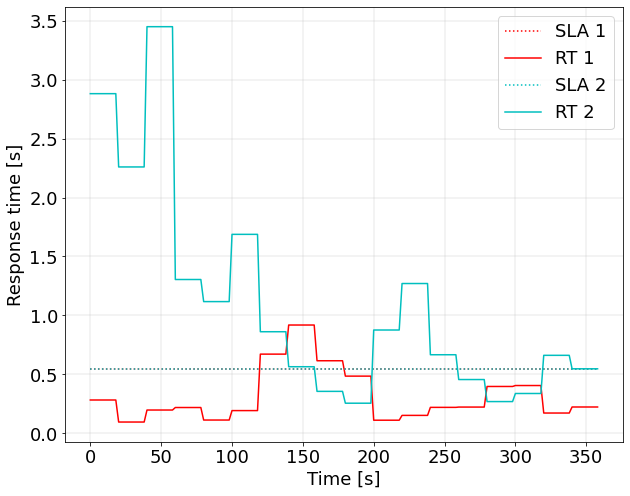

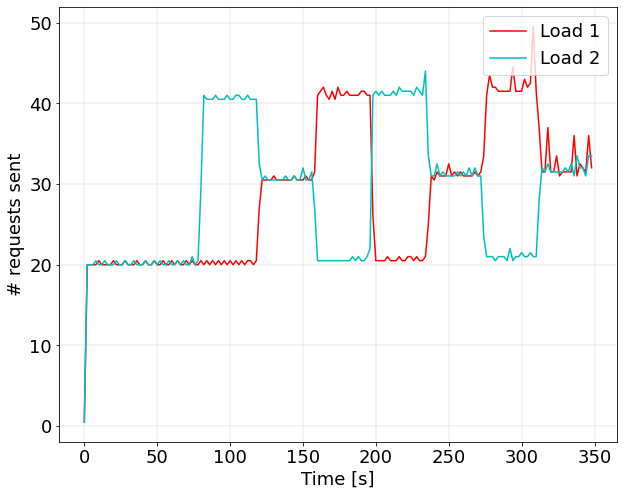

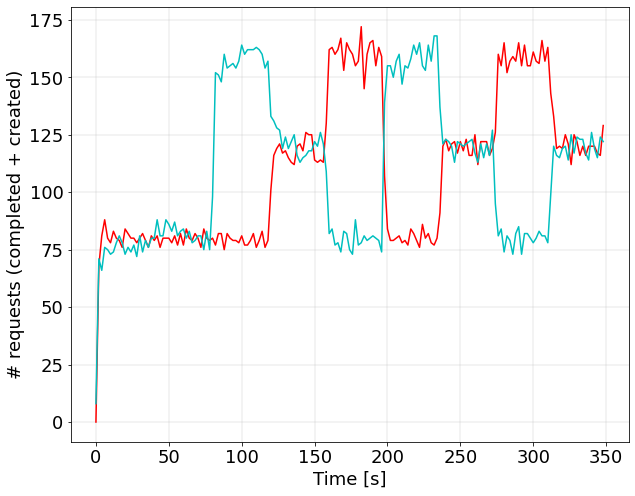

++++++ NOT AGGREGATED


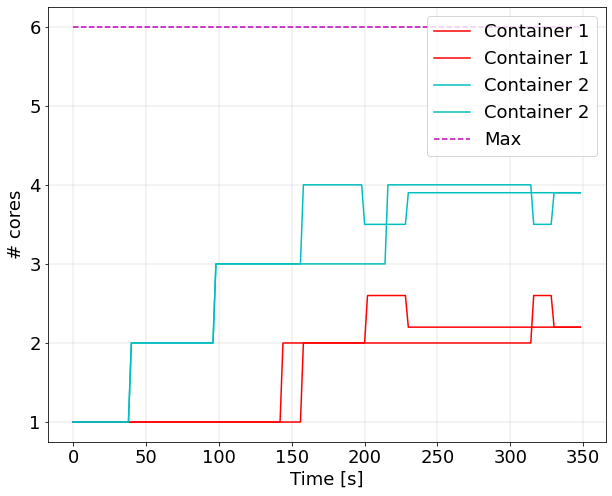

In [97]:
containers = ["9adc1001c5e0deb9248a4aa1cbd58ab901de8d60fc684d9dbe7f3ae9b73d7a0a",
              "442b1fb6f0c17b4962b58598513f2b9817a3ce25fad040b7087198cf6895e3f8",
              "4b9135318818a5dcf0f32e4a934845fa5a5f7189ba249bad7e5dea0bcc24989c",
              "499b2807892527832a22ab6883cb1aecb112ce461db33ea877716a622b40c26a"]
output_folder = "plot_output/"

samples = 3
filename_1 = "benchmark_resnet_NHWC.out"
filename_2 = "benchmark_vgg16.out"

base_folders = []
for sample in range(1,samples+1):
    base_folders.append("complete/control/hyst/h1/" + str(sample) + "/")
    base_folders.append("complete/control/hyst/rr/" + str(sample) + "/")
    base_folders.append("complete/no_control_max_cpu/hyst/rr/" + str(sample) + "/")
    base_folders.append("complete/no_control_min_cpu/hyst/rr/" + str(sample) + "/")
    base_folders.append("complete/rules/hyst/rr/" + str(sample) + "/")
    
base_folders.sort()

for base_folder in base_folders:
    print(base_folder)

    """
    print("---------------- Resnet")
    show_stats(base_folder + filename_1, 2)
    print("---------------- Vgg16")
    show_stats(base_folder + filename_2, 2)
    """

    print("++++++ AGGREGATED")
    print("---------------- Resnet")
    show_stats(base_folder + filename_1, 2, aggregate=10)
    print("---------------- Vgg16")
    show_stats(base_folder + filename_2, 2, aggregate=10)

    """
    plt_rt(1, base_folder + filename_1, 2, 'r')
    plt_rt(2, base_folder + filename_2, 2, 'c')
    plt.show()
    """

    print("++++++ AGGREGATED")
    plt_rt(1, base_folder + filename_1, 2, 'r', aggregate=10)
    plt_rt(2, base_folder + filename_2, 2, 'c', aggregate=10)
    #plt.savefig(output_folder + "rt_" + control.replace("/", "_") + "_" + strategy  + '.pdf', bbox_inches='tight')
    plt.show()

    plt_sent(1, base_folder + filename_1, 2, 'r')
    plt_sent(2, base_folder + filename_2, 2, 'c')
    #plt.savefig(output_folder + "sent_" + control.replace("/", "_") + "_" + strategy  + '.pdf', bbox_inches='tight')
    plt.show()

    plt_req(1, base_folder + filename_1, 2, 'r')
    plt_req(2, base_folder + filename_2, 2, 'c')
    #plt.savefig(output_folder + "req_" + control.replace("/", "_") + "_" + strategy  + '.pdf', bbox_inches='tight')
    plt.show()

    """
    plt_quota(1, base_folder + "benchmark_skyline_extraction.out",2, 'r', show_c=containers)
    plt_quota(2, base_folder + "benchmark_googlenet.out", 2, 'c', max_c=6, show_c=containers)
    plt.show()
    """

    print("++++++ NOT AGGREGATED")
    plt_quota(1, base_folder + filename_1, 2, 'r', show_c=containers, aggregate=False)
    plt_quota(2, base_folder + filename_2, 2, 'c', max_c=6, show_c=containers, aggregate=False)
    #plt.savefig(output_folder + "quota_" + control.replace("/", "_") + "_" + strategy  + '.pdf', bbox_inches='tight')
    plt.show()

### Skyline + GoogLeNet + Resnet + Vgg16
- default controller parameters (b_c = 0.21, d_c = 0.17)

complete/control/4app/h1/1/
++++++ AGGREGATED
---------------- Skyline
RT: avg: 0.1595, max: 0.1849, std: 0.0134

Violations: 0 - 0.00%

Container ddc9887c279f23d421966bea799e5a1fa5cc4574f24af325da34420725419ec8:
active: 160.50, total: 321.00

Container 201e90c5d501dcbce202add51df82eec3fa6771db7cd60647e99934c1c102dd6:
active: 160.50, total: 321.00

---------------- Googlenet
RT: avg: 0.1298, max: 0.1492, std: 0.0114

Violations: 0 - 0.00%

Container ea5ef811333af1b031b8f206d0208b7b6ae64a94f6fd85b925e01ec859542291:
active: 159.90, total: 319.80

Container ebe70259b766911e0fc4870750daac4b79055d9149af75b99675b05577a8ac95:
active: 160.90, total: 321.80

---------------- Resnet
RT: avg: 0.1324, max: 0.2045, std: 0.0343

Violations: 0 - 0.00%

Container a4f59a2a9d0069429b087bc51b2ceca645a3161c56aca09cbf851b6e359d3774:
active: 191.10, total: 382.20

Container 86ef4127c4676dc52d3e070136162e891d3272497bec0887cce691582add76d1:
active: 195.60, total: 391.20

---------------- Vgg16
RT: avg: 0.2473

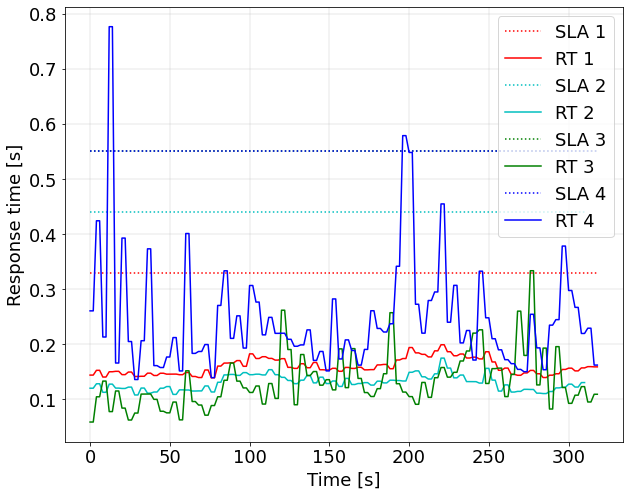

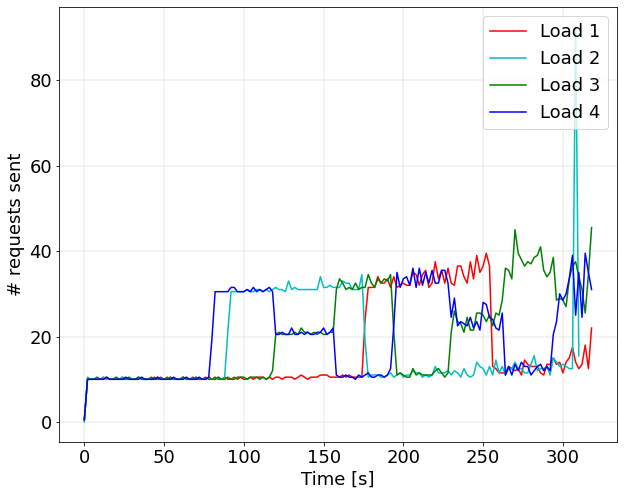

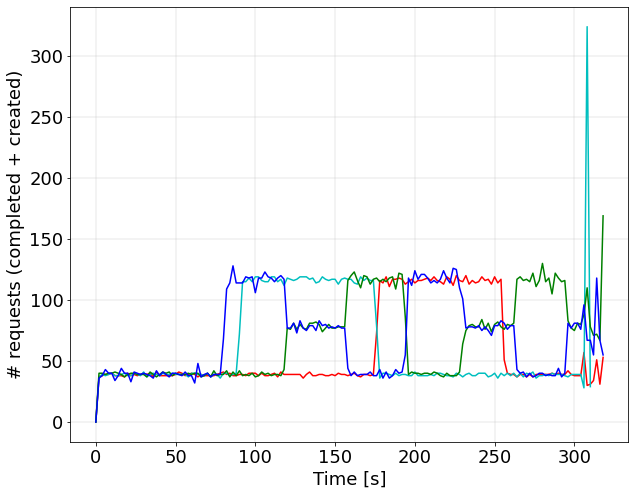

++++++ NOT AGGREGATED


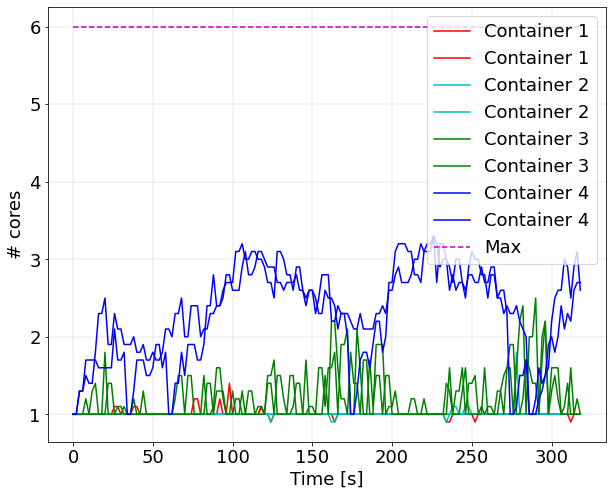

complete/control/4app/h1/2/
++++++ AGGREGATED
---------------- Skyline
RT: avg: 0.1592, max: 0.1875, std: 0.0124

Violations: 0 - 0.00%

Container ddc9887c279f23d421966bea799e5a1fa5cc4574f24af325da34420725419ec8:
active: 171.00, total: 342.00

Container 201e90c5d501dcbce202add51df82eec3fa6771db7cd60647e99934c1c102dd6:
active: 170.40, total: 340.80

---------------- Googlenet
RT: avg: 0.1302, max: 0.1514, std: 0.0118

Violations: 0 - 0.00%

Container ea5ef811333af1b031b8f206d0208b7b6ae64a94f6fd85b925e01ec859542291:
active: 170.70, total: 341.40

Container ebe70259b766911e0fc4870750daac4b79055d9149af75b99675b05577a8ac95:
active: 171.20, total: 342.40

---------------- Resnet
RT: avg: 0.1327, max: 0.1610, std: 0.0210

Violations: 0 - 0.00%

Container a4f59a2a9d0069429b087bc51b2ceca645a3161c56aca09cbf851b6e359d3774:
active: 194.60, total: 389.20

Container 86ef4127c4676dc52d3e070136162e891d3272497bec0887cce691582add76d1:
active: 207.60, total: 415.20

---------------- Vgg16
RT: avg: 0.2454

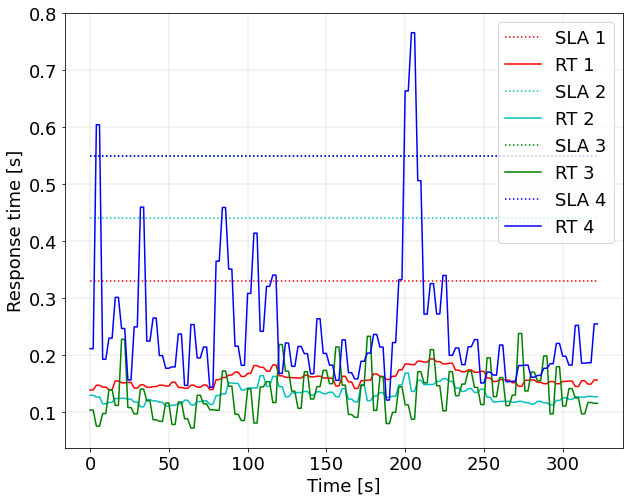

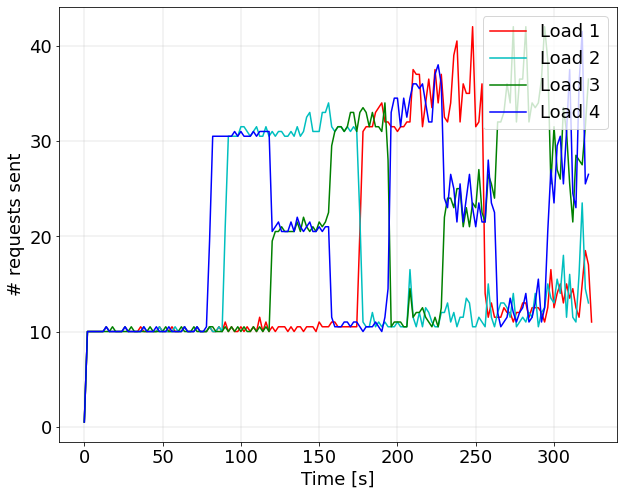

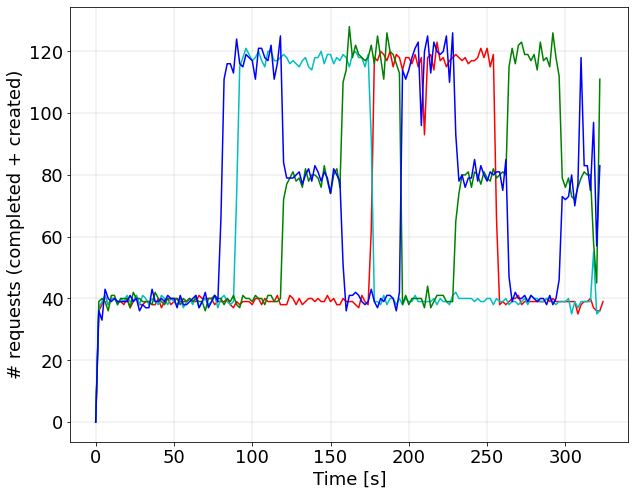

++++++ NOT AGGREGATED


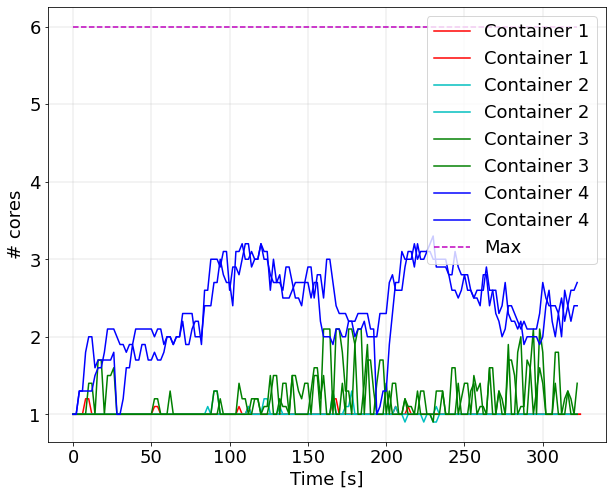

complete/control/4app/h1/3/
++++++ AGGREGATED
---------------- Skyline
RT: avg: 0.2209, max: 0.3306, std: 0.0467

Violations: 10 - 6.67%

Container ddc9887c279f23d421966bea799e5a1fa5cc4574f24af325da34420725419ec8:
active: 151.75, total: 303.50

Container 201e90c5d501dcbce202add51df82eec3fa6771db7cd60647e99934c1c102dd6:
active: 152.20, total: 304.40

---------------- Googlenet
RT: avg: 0.1826, max: 0.2569, std: 0.0390

Violations: 0 - 0.00%

Container ea5ef811333af1b031b8f206d0208b7b6ae64a94f6fd85b925e01ec859542291:
active: 152.20, total: 304.40

Container ebe70259b766911e0fc4870750daac4b79055d9149af75b99675b05577a8ac95:
active: 149.60, total: 299.20

---------------- Resnet
RT: avg: 0.2254, max: 0.3106, std: 0.0560

Violations: 0 - 0.00%

Container a4f59a2a9d0069429b087bc51b2ceca645a3161c56aca09cbf851b6e359d3774:
active: 194.87, total: 389.75

Container 86ef4127c4676dc52d3e070136162e891d3272497bec0887cce691582add76d1:
active: 203.00, total: 406.00

---------------- Vgg16
RT: avg: 0.407

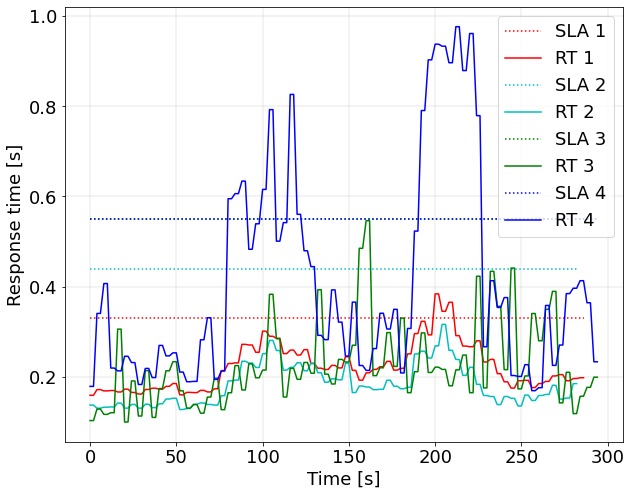

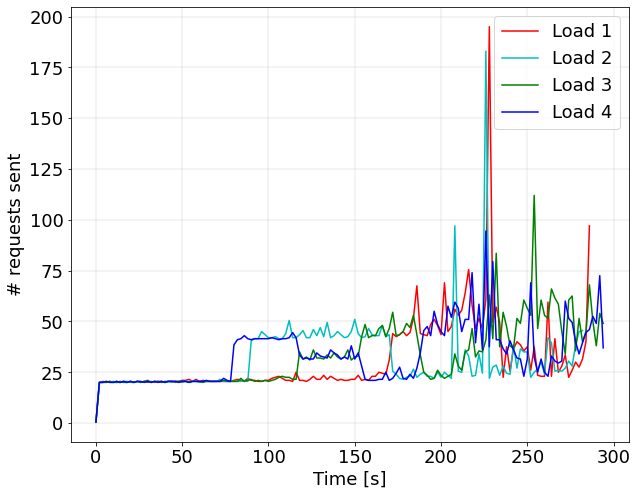

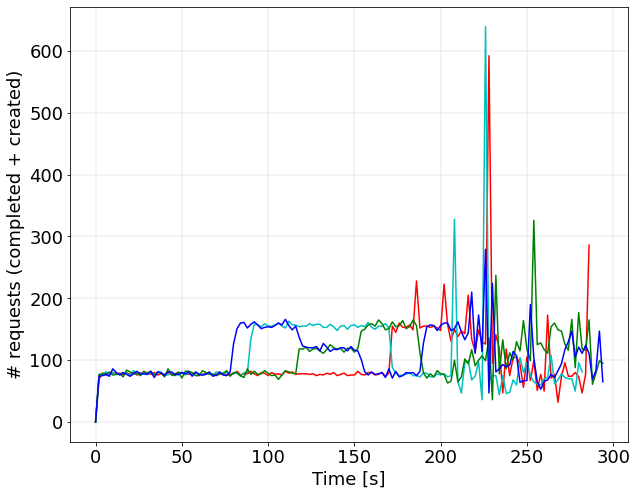

++++++ NOT AGGREGATED


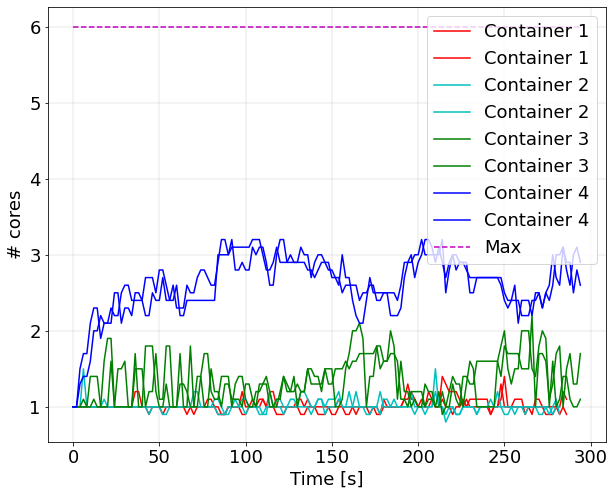

complete/rules/4app/rr/1/
++++++ AGGREGATED
---------------- Skyline
RT: avg: 0.1766, max: 0.2032, std: 0.0180

Violations: 0 - 0.00%

Container ddc9887c279f23d421966bea799e5a1fa5cc4574f24af325da34420725419ec8:
active: 88.10, total: 176.20

Container 201e90c5d501dcbce202add51df82eec3fa6771db7cd60647e99934c1c102dd6:
active: 89.40, total: 178.80

---------------- Googlenet
RT: avg: 0.1602, max: 0.2163, std: 0.0246

Violations: 0 - 0.00%

Container ea5ef811333af1b031b8f206d0208b7b6ae64a94f6fd85b925e01ec859542291:
active: 97.23, total: 194.47

Container ebe70259b766911e0fc4870750daac4b79055d9149af75b99675b05577a8ac95:
active: 98.80, total: 197.60

---------------- Resnet
RT: avg: 0.2376, max: 0.3955, std: 0.0814

Violations: 0 - 0.00%

Container a4f59a2a9d0069429b087bc51b2ceca645a3161c56aca09cbf851b6e359d3774:
active: 117.40, total: 234.80

Container 86ef4127c4676dc52d3e070136162e891d3272497bec0887cce691582add76d1:
active: 112.83, total: 225.67

---------------- Vgg16
RT: avg: 1.4997, max:

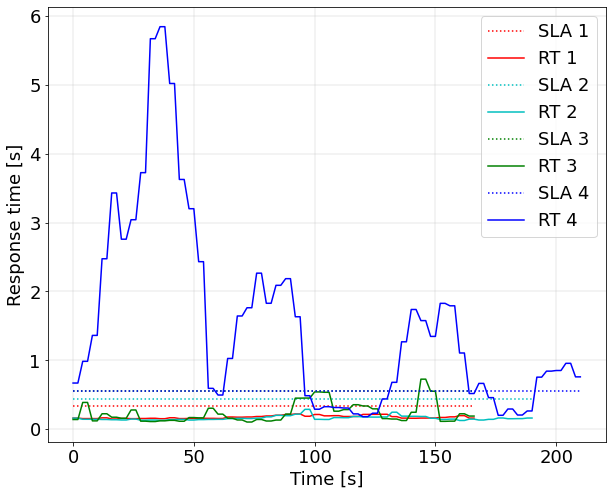

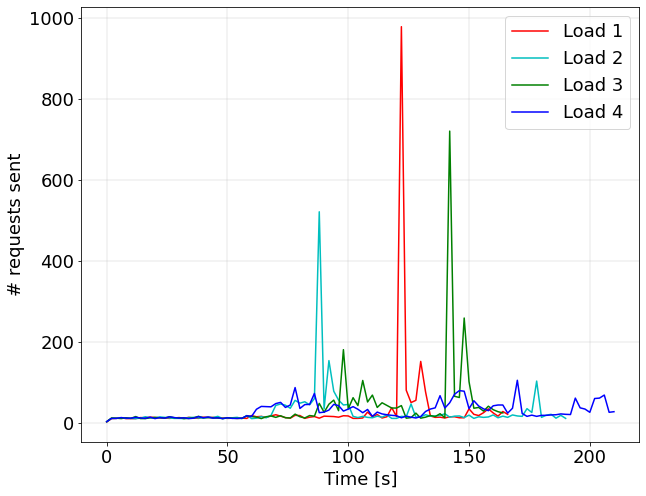

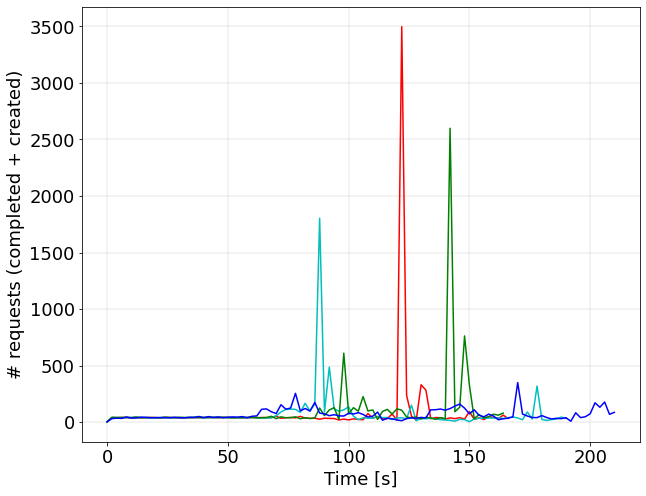

++++++ NOT AGGREGATED


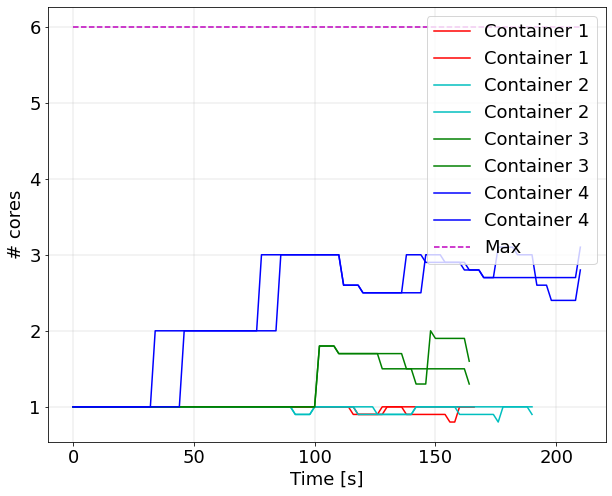

complete/rules/4app/rr/2/
++++++ AGGREGATED
---------------- Skyline
RT: avg: 0.1818, max: 0.2219, std: 0.0218

Violations: 0 - 0.00%

Container ddc9887c279f23d421966bea799e5a1fa5cc4574f24af325da34420725419ec8:
active: 163.30, total: 326.60

Container 201e90c5d501dcbce202add51df82eec3fa6771db7cd60647e99934c1c102dd6:
active: 166.30, total: 332.60

---------------- Googlenet
RT: avg: 0.1673, max: 0.2208, std: 0.0252

Violations: 0 - 0.00%

Container ea5ef811333af1b031b8f206d0208b7b6ae64a94f6fd85b925e01ec859542291:
active: 163.10, total: 326.20

Container ebe70259b766911e0fc4870750daac4b79055d9149af75b99675b05577a8ac95:
active: 166.40, total: 332.80

---------------- Resnet
RT: avg: 0.3798, max: 1.0743, std: 0.2944

Violations: 40 - 23.53%

Container a4f59a2a9d0069429b087bc51b2ceca645a3161c56aca09cbf851b6e359d3774:
active: 214.90, total: 429.80

Container 86ef4127c4676dc52d3e070136162e891d3272497bec0887cce691582add76d1:
active: 206.50, total: 413.00

---------------- Vgg16
RT: avg: 0.9106

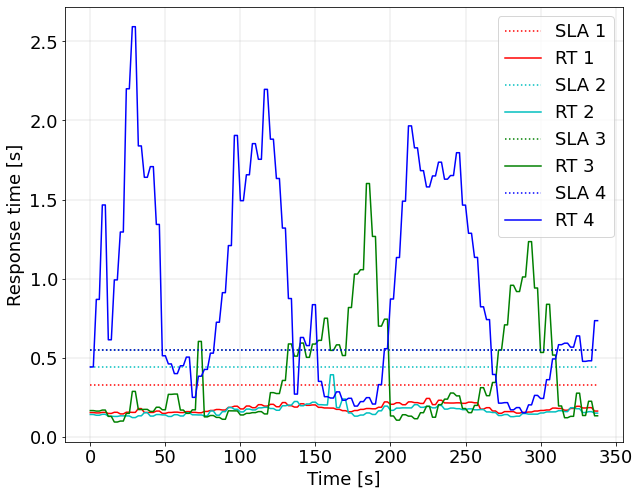

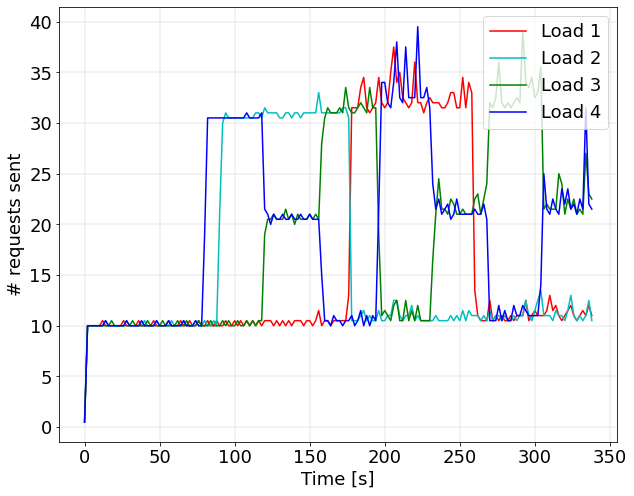

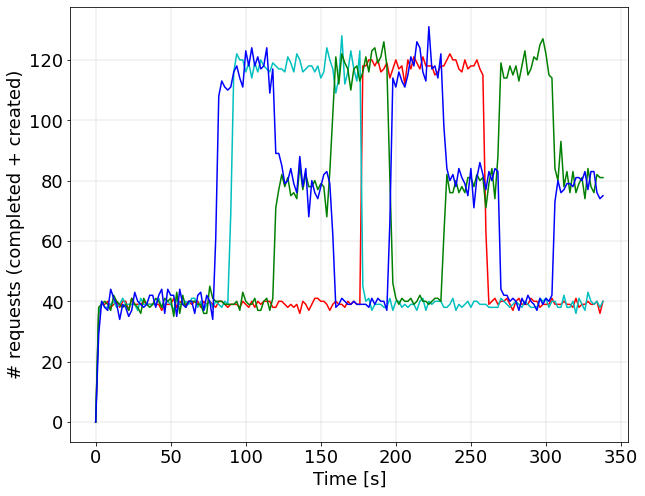

++++++ NOT AGGREGATED


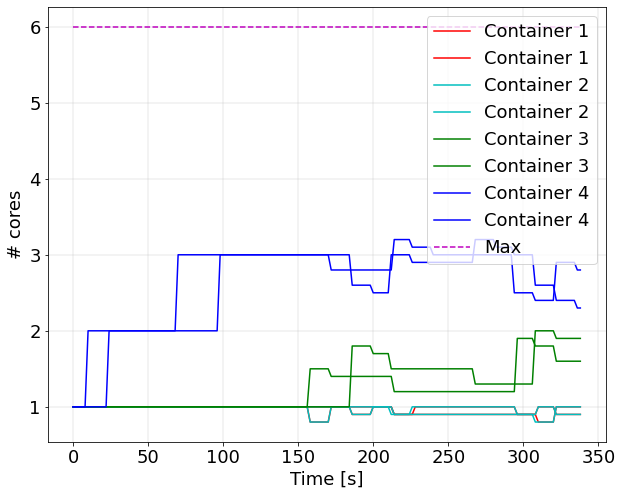

complete/rules/4app/rr/3/
++++++ AGGREGATED
---------------- Skyline
RT: avg: 0.1819, max: 0.2165, std: 0.0224

Violations: 0 - 0.00%

Container ddc9887c279f23d421966bea799e5a1fa5cc4574f24af325da34420725419ec8:
active: 162.60, total: 325.20

Container 201e90c5d501dcbce202add51df82eec3fa6771db7cd60647e99934c1c102dd6:
active: 164.49, total: 328.97

---------------- Googlenet
RT: avg: 0.1622, max: 0.2073, std: 0.0218

Violations: 0 - 0.00%

Container ea5ef811333af1b031b8f206d0208b7b6ae64a94f6fd85b925e01ec859542291:
active: 162.50, total: 325.00

Container ebe70259b766911e0fc4870750daac4b79055d9149af75b99675b05577a8ac95:
active: 164.49, total: 328.97

---------------- Resnet
RT: avg: 0.3425, max: 0.8475, std: 0.2175

Violations: 40 - 23.53%

Container a4f59a2a9d0069429b087bc51b2ceca645a3161c56aca09cbf851b6e359d3774:
active: 223.50, total: 447.00

Container 86ef4127c4676dc52d3e070136162e891d3272497bec0887cce691582add76d1:
active: 222.36, total: 444.71

---------------- Vgg16
RT: avg: 0.8268

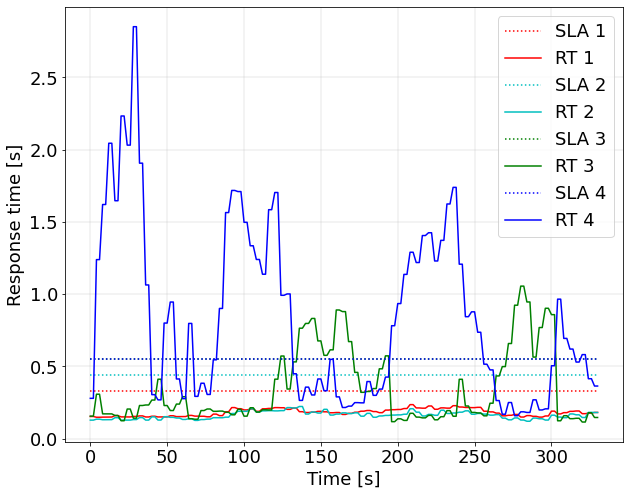

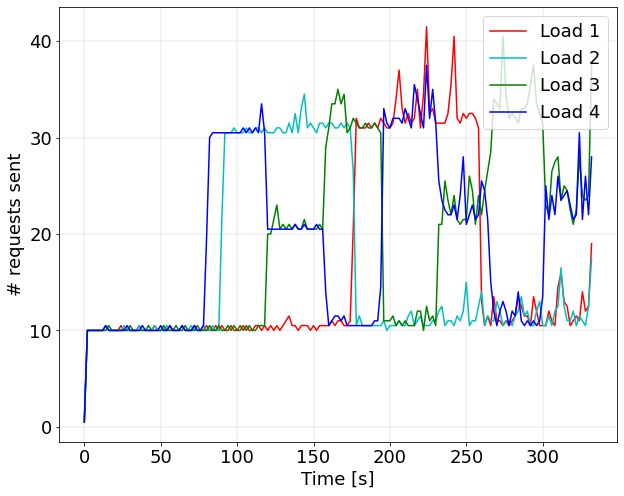

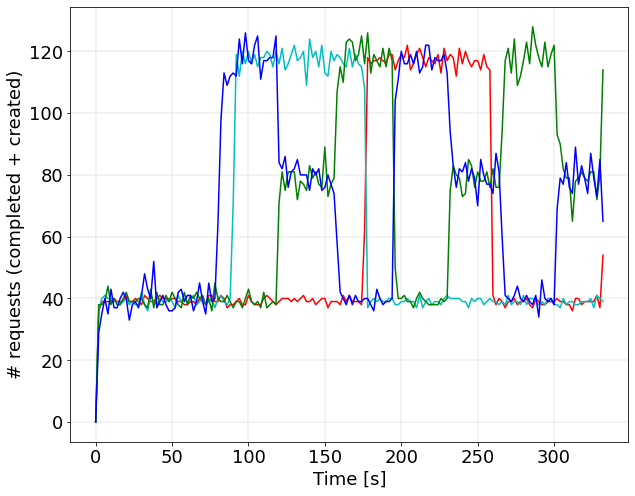

++++++ NOT AGGREGATED


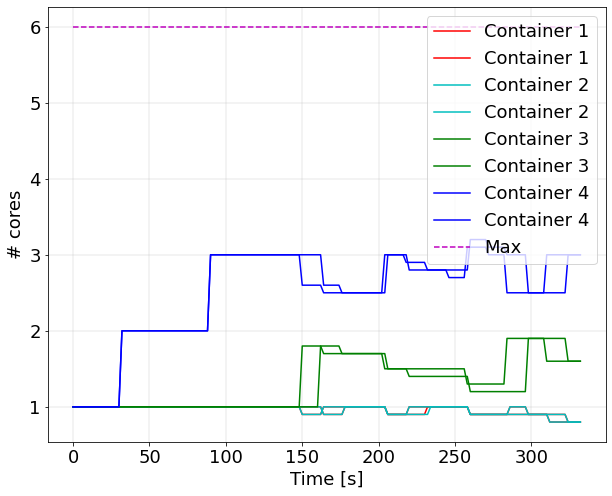

In [98]:
containers = ["ddc9887c279f23d421966bea799e5a1fa5cc4574f24af325da34420725419ec8",
              "201e90c5d501dcbce202add51df82eec3fa6771db7cd60647e99934c1c102dd6",
              "ea5ef811333af1b031b8f206d0208b7b6ae64a94f6fd85b925e01ec859542291",
              "ebe70259b766911e0fc4870750daac4b79055d9149af75b99675b05577a8ac95",
              "a4f59a2a9d0069429b087bc51b2ceca645a3161c56aca09cbf851b6e359d3774",
              "86ef4127c4676dc52d3e070136162e891d3272497bec0887cce691582add76d1",
              "7d727f55cd3d5d9d150041447547a5a8219ff024ba0bece77ae50504e48f7edb",
              "df878b32a7b55aa821035d286afc67062bca0c127eb58f0ce8adeb721e4c3c8a"]
output_folder = "plot_output/"

samples = 3
filename_1 = "benchmark_skyline_extraction.out"
filename_2 = "benchmark_googlenet.out"
filename_3 = "benchmark_resnet_NHWC.out"
filename_4 = "benchmark_vgg16.out"

base_folders = []
for sample in range(1,samples+1):
    base_folders.append("complete/control/4app/h1/" + str(sample) + "/")
    base_folders.append("complete/rules/4app/rr/" + str(sample) + "/")
    
base_folders.sort()

for base_folder in base_folders:
    print(base_folder)

    """
    print("---------------- Resnet")
    show_stats(base_folder + filename_1, 2)
    print("---------------- Vgg16")
    show_stats(base_folder + filename_2, 2)
    """

    print("++++++ AGGREGATED")
    print("---------------- Skyline")
    show_stats(base_folder + filename_1, 2, aggregate=10)
    print("---------------- Googlenet")
    show_stats(base_folder + filename_2, 2, aggregate=10)
    print("---------------- Resnet")
    show_stats(base_folder + filename_3, 2, aggregate=10)
    print("---------------- Vgg16")
    show_stats(base_folder + filename_4, 2, aggregate=10)

    """
    plt_rt(1, base_folder + filename_1, 2, 'r')
    plt_rt(2, base_folder + filename_2, 2, 'c')
    plt.show()
    """

    print("++++++ AGGREGATED")
    plt_rt(1, base_folder + filename_1, 2, 'r', aggregate=2)
    plt_rt(2, base_folder + filename_2, 2, 'c', aggregate=2)
    plt_rt(3, base_folder + filename_3, 2, 'g', aggregate=2)
    plt_rt(4, base_folder + filename_4, 2, 'b', aggregate=2)
    #plt.savefig(output_folder + "rt_" + control.replace("/", "_") + "_" + strategy  + '.pdf', bbox_inches='tight')
    plt.show()

    plt_sent(1, base_folder + filename_1, 2, 'r')
    plt_sent(2, base_folder + filename_2, 2, 'c')
    plt_sent(3, base_folder + filename_3, 2, 'g')
    plt_sent(4, base_folder + filename_4, 2, 'b')
    #plt.savefig(output_folder + "sent_" + control.replace("/", "_") + "_" + strategy  + '.pdf', bbox_inches='tight')
    plt.show()

    plt_req(1, base_folder + filename_1, 2, 'r')
    plt_req(2, base_folder + filename_2, 2, 'c')
    plt_req(3, base_folder + filename_3, 2, 'g')
    plt_req(4, base_folder + filename_4, 2, 'b')
    #plt.savefig(output_folder + "req_" + control.replace("/", "_") + "_" + strategy  + '.pdf', bbox_inches='tight')
    plt.show()

    """
    plt_quota(1, base_folder + "benchmark_skyline_extraction.out",2, 'r', show_c=containers)
    plt_quota(2, base_folder + "benchmark_googlenet.out", 2, 'c', max_c=6, show_c=containers)
    plt.show()
    """

    print("++++++ NOT AGGREGATED")
    plt_quota(1, base_folder + filename_1, 2, 'r', show_c=containers, aggregate=False)
    plt_quota(2, base_folder + filename_2, 2, 'c', show_c=containers, aggregate=False)
    plt_quota(3, base_folder + filename_3, 2, 'g', show_c=containers, aggregate=False)
    plt_quota(4, base_folder + filename_4, 2, 'b', max_c=6, show_c=containers, aggregate=False)    
    #plt.savefig(output_folder + "quota_" + control.replace("/", "_") + "_" + strategy  + '.pdf', bbox_inches='tight')
    plt.show()